In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

In [66]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [67]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [68]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [69]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [70]:
from utils.resources import ClusterReference

crf = ClusterReference("../linguistics/cluster_references/ru-RU/cluster_references.json")

In [71]:
def aggregate_rover(raw_data, rover_class=RoverVotingScheme, treshhold=0.51, cluster_references=None):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    hyps = []
    for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        hyps.append(TextHyp("1", worker_id, text))
    rover = rover_class("1", hyps, cluster_references)
    rover_result = rover.get_result()
    text = " ".join(value for value, score in rover_result if value != "")
    if text == "":
        conf = 0
        text = None
    elif any(score < treshhold for value, score in rover_result):
        conf = 0
        text = None
    else:
        conf = 1
    
    return AggregationResult(text, conf, cost)

In [72]:
class RoverVotingSchemeEmptyDecreased(WordTransitionNetwork):
    def get_result(self):
        result = []
        empty_correction = 0.66
        for edges in self.edges:
            score, _, value = max((len(set(x.sources)) * (1 if x.value else empty_correction), 
                                   len(x.value), 
                                   x.value) for x in edges.values())
            score = float(score)
            if value == "":
                score /= empty_correction
            score /= sum(len(set(x.sources)) for x in edges.values())
            result.append((value, score))
        return result

In [73]:
MAX_NUM_ANSWERS = 10
NO_SOURCE_ID = "NO WORKER"


def extract_prefeatures(data, field_name):
    prefeatures = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
    for row in data:
        toloka_answers = sorted(row[field_name], key=lambda x: x["submit_ts"])
        id_ = row["mds_key"]
        for cost in range(1, len(toloka_answers) + 1):
            hyps = []
            for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in toloka_answers[:cost]]:
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                hyps.append(TextHyp(id_, worker_id, text))
            wtn = WordTransitionNetwork(object_id=id_, hypotheses=hyps)
            ref_text = row.get("text", "")
            ref = WordTransitionNetwork(object_id=id_, hypotheses=[TextHyp(id_, "reference", ref_text)])
            alignment, actions = wtn._align(wtn.edges, ref.edges, wtn.hypotheses_sources, ref.hypotheses_sources)
            expanded_alignment = []  # формируем дополнительные ребра на местах где не было вставок
            skip_next = False
            for item, action in zip(alignment, actions): 
                if action == "I":
                    if skip_next:
                        continue  # берем только первую вставку из нескольких так как они индентичны
                    expanded_alignment.append(item)
                    skip_next = True
                elif skip_next:
                    expanded_alignment.append(item)
                    skip_next = False
                else:
                    expanded_alignment += [
                        {"": WTNEdge("", 
                                     None, 
                                     wtn.hypotheses_sources + ["reference"], 
                                     [None for _ in wtn.hypotheses_sources + ["reference"]])}, item
                    ]
            if not skip_next:
                expanded_alignment.append(
                    {
                        "": WTNEdge(
                            "", 
                            None, 
                            wtn.hypotheses_sources + ["reference"], 
                            [None for _ in wtn.hypotheses_sources + ["reference"]]
                        )
                    }
                )
            for position, edges in enumerate(expanded_alignment):
                correct_word = None
                fixed_edges = {}
                for word, edge in edges.items():
                    if "reference" in edge.sources:
                        edge = WTNEdge(edge[0], edge[1], edge[2][:-1], edge[3][:-1])
                        assert "reference" not in edge.sources
                        assert correct_word is None
                        correct_word = edge.value
                    if len(edge.sources) != 0:
                        fixed_edges[word] = edge
                assert correct_word is not None
                all_submissions = [(edge.value, edge.score, source, original_position)
                                   for edge in fixed_edges.values() 
                                   for source, original_position in zip(edge.sources, edge.original_positions) 
                                   ]
                for word in fixed_edges:
                    submissions_sorted = sorted(
                        (calculate_wer(list(word), list(sub[0]))[1], *sub) for sub in all_submissions
                    )
                    prefeatures[id_][cost][position][word] = (submissions_sorted, word == correct_word)
    return prefeatures    

In [74]:
import re

eng_letter = re.compile("[a-zA-Z]")

def count_eng_letters(text):
    x = re.findall(eng_letter, text)
    return len(x)

In [75]:
def get_word_features(word):
    if word is None:
        return [-100] * 3
    result = [
        len(word), count_eng_letters(word), len(word) - count_eng_letters(word)
    ]
    return result

def get_word_to_word_features(word, hyp_word):
    if word is None or hyp_word is None:
        return [-100] * 3
    result = [
        calculate_wer(list(word), list(hyp_word))[1], 
        len(word) - len(hyp_word),
        count_eng_letters(word) - count_eng_letters(hyp_word)
    ]
    return result

In [76]:
def extract_task_features(row):
    mds_key = row["mds_key"]
    return []

In [141]:
def extract_source_features(data, field_name): # , predresult)
    N_FEATURES = 8
    sources_stats = collections.defaultdict(lambda: np.zeros(N_FEATURES, dtype=np.int32))
    for row in data:
        mds_key = row["mds_key"]
        texts = []
        for cost, assignment in enumerate(sorted(row[field_name], key=lambda x: x["submit_ts"])):
            cost += 1
            source_id = assignment["worker_id"]
            text = assignment["text"]
            texts.append(text)
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            for i in range(cost, MAX_NUM_ANSWERS + 1):
                sources_stats[(source_id, i)] += np.array([
                                                      1, 
                                                      text == "", 
                                                      len(text.split()), 
                                                      len(text), 
                                                      number_of_speakers=="many", 
                                                      count_eng_letters(text),
                                                      count_eng_letters(text) != 0,
                                                      sum(1 for x in texts if x == text)
                                                     ])
    sources_stats[NO_SOURCE_ID] = np.full(fill_value=-1, shape=N_FEATURES)
    for i, value in sources_stats.items():
        n = value[0]
        value = np.concatenate((
            np.array([n], dtype=np.float),
            value[1:] / n
        ))
        sources_stats[i] = list(value)
    for i in range(1, MAX_NUM_ANSWERS + 1):
        sources_stats[(NO_SOURCE_ID, i)] = [-1] * N_FEATURES
    return dict(sources_stats)

In [142]:
def count_eng_words(text):
    return sum(1 for word in text.split() if count_eng_letters(word) != 0)

In [143]:
def extract_task_and_source_features(data, field_name):
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        texts = []
        for assignment in sorted(row[field_name], key=lambda x: x['submit_ts']):
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            texts.append(text)
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            stats[(mds_key, source_id)] = [
                len(text.split()), 
                len(text), 
                number_of_speakers == "many", 
                count_eng_letters(text),
                count_eng_words(text),
                sum(1 for x in texts if x == text)
            ]
        stats[(mds_key, NO_SOURCE_ID)] = [
                -1, 
                -1, 
                -1, 
                -1,
                -1,
                -1
            ]
    return stats

In [144]:
def extract_task_and_source_word_features(data, field_name):
    N_FEATURES = 5
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            text = text.split()
            text_len = len(text)
            for pos, word in enumerate(text):
                stats[(mds_key, source_id, pos)] = [
                    pos, 
                    len(text[pos-1]) if pos > 0 else -1, 
                    len(text[pos+1]) if pos + 1 < text_len else -1,
                    count_eng_letters(text[pos-1]) if pos > 0 else -1, 
                    count_eng_letters(text[pos+1]) if pos + 1 < text_len else -1
                ]
            stats[(mds_key, source_id, None)] = [-1] * N_FEATURES
        stats[(mds_key, NO_SOURCE_ID, None)] = [-1] * N_FEATURES
    return stats

In [145]:
def extract_features(data, field_name):
    task_features = dict((row["mds_key"], extract_task_features(row)) for row in data)
    source_features = extract_source_features(data, field_name)
    task_and_source_features = extract_task_and_source_features(data, field_name)
    task_and_source_word_features = extract_task_and_source_word_features(data, field_name)
    
    features = extract_prefeatures(data, field_name)
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    prefeature, y = item3
                    prefeature += [(-1, None, None, NO_SOURCE_ID, None) for _ in range(MAX_NUM_ANSWERS - len(prefeature))]
                    if len(prefeature) != MAX_NUM_ANSWERS:
                        print(prefeature)
                        assert False
                    x = [position] + task_features[task_id] + get_word_features(word) 
                    for edit_distance, hyp_word, score, source_id, original_position in prefeature:
                        x += get_word_features(hyp_word)
                        x += get_word_to_word_features(word, hyp_word)
                        x += source_features[(source_id, cost)]
                        x += task_and_source_features[(task_id, source_id)]
                        x += task_and_source_word_features[(task_id, source_id, original_position)]
                    features[task_id][cost][position][word] = (x, y)
    return features

In [146]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [147]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [148]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [149]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if (row['text'] != '' and hyp == ''):
            false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    false_empty /= aggregated
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [150]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [151]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [152]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_valid = list(data_assistant_train) + list(data_assistant_test)

In [153]:
len(data_assistant_valid)

7022

In [154]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [155]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_train = list(data_assistant_train)
data_assistant_test = list(data_assistant_test)
for row in data_assistant_test:
    if 'text' in row:
        del row['text']

In [157]:
data_assistant_new_test_features = extract_features(data_assistant_test, 'toloka_results')

In [158]:
data_assistant_new_train_features = extract_features(data_assistant_train, 'toloka_results')

In [159]:
data_assistant_test_valid = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_test_valid = list(data_assistant_test_valid)

In [160]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [161]:
X_train, Y_train = convert_to_array(data_assistant_new_train_features)

In [162]:
clf_new = CatBoostClassifier(iterations=19000, depth=6, thread_count=26, random_seed=42)
clf_new.fit(X_train, Y_train)

Learning rate set to 0.006743
0:	learn: 0.6839108	total: 90.3ms	remaining: 28m 34s
1:	learn: 0.6749854	total: 179ms	remaining: 28m 18s
2:	learn: 0.6662095	total: 267ms	remaining: 28m 9s
3:	learn: 0.6575844	total: 357ms	remaining: 28m 13s
4:	learn: 0.6490770	total: 445ms	remaining: 28m 10s
5:	learn: 0.6409922	total: 536ms	remaining: 28m 18s
6:	learn: 0.6328550	total: 622ms	remaining: 28m 8s
7:	learn: 0.6249659	total: 711ms	remaining: 28m 8s
8:	learn: 0.6172107	total: 799ms	remaining: 28m 5s
9:	learn: 0.6094894	total: 884ms	remaining: 27m 59s
10:	learn: 0.6019506	total: 969ms	remaining: 27m 52s
11:	learn: 0.5945699	total: 1.05s	remaining: 27m 49s
12:	learn: 0.5875036	total: 1.14s	remaining: 27m 45s
13:	learn: 0.5803056	total: 1.22s	remaining: 27m 38s
14:	learn: 0.5735620	total: 1.31s	remaining: 27m 38s
15:	learn: 0.5666930	total: 1.4s	remaining: 27m 37s
16:	learn: 0.5597845	total: 1.48s	remaining: 27m 35s
17:	learn: 0.5531292	total: 1.57s	remaining: 27m 32s
18:	learn: 0.5468145	total: 1.

156:	learn: 0.2399291	total: 13.7s	remaining: 27m 22s
157:	learn: 0.2394153	total: 13.8s	remaining: 27m 22s
158:	learn: 0.2389372	total: 13.9s	remaining: 27m 23s
159:	learn: 0.2384614	total: 14s	remaining: 27m 23s
160:	learn: 0.2379780	total: 14.1s	remaining: 27m 24s
161:	learn: 0.2375067	total: 14.1s	remaining: 27m 24s
162:	learn: 0.2369908	total: 14.2s	remaining: 27m 24s
163:	learn: 0.2364830	total: 14.3s	remaining: 27m 23s
164:	learn: 0.2360223	total: 14.4s	remaining: 27m 23s
165:	learn: 0.2355957	total: 14.5s	remaining: 27m 24s
166:	learn: 0.2351372	total: 14.6s	remaining: 27m 24s
167:	learn: 0.2346951	total: 14.7s	remaining: 27m 23s
168:	learn: 0.2342514	total: 14.8s	remaining: 27m 23s
169:	learn: 0.2338031	total: 14.8s	remaining: 27m 23s
170:	learn: 0.2333643	total: 14.9s	remaining: 27m 23s
171:	learn: 0.2329621	total: 15s	remaining: 27m 24s
172:	learn: 0.2325571	total: 15.1s	remaining: 27m 24s
173:	learn: 0.2321542	total: 15.2s	remaining: 27m 24s
174:	learn: 0.2317168	total: 15.

309:	learn: 0.2056910	total: 27.2s	remaining: 27m 22s
310:	learn: 0.2055876	total: 27.3s	remaining: 27m 22s
311:	learn: 0.2055148	total: 27.4s	remaining: 27m 21s
312:	learn: 0.2054009	total: 27.5s	remaining: 27m 21s
313:	learn: 0.2053276	total: 27.6s	remaining: 27m 21s
314:	learn: 0.2052453	total: 27.7s	remaining: 27m 21s
315:	learn: 0.2051753	total: 27.8s	remaining: 27m 21s
316:	learn: 0.2051001	total: 27.8s	remaining: 27m 21s
317:	learn: 0.2050159	total: 27.9s	remaining: 27m 20s
318:	learn: 0.2049297	total: 28s	remaining: 27m 21s
319:	learn: 0.2048607	total: 28.1s	remaining: 27m 20s
320:	learn: 0.2047693	total: 28.2s	remaining: 27m 20s
321:	learn: 0.2046840	total: 28.3s	remaining: 27m 20s
322:	learn: 0.2046017	total: 28.4s	remaining: 27m 20s
323:	learn: 0.2045159	total: 28.5s	remaining: 27m 20s
324:	learn: 0.2044427	total: 28.6s	remaining: 27m 20s
325:	learn: 0.2043722	total: 28.6s	remaining: 27m 20s
326:	learn: 0.2042923	total: 28.7s	remaining: 27m 20s
327:	learn: 0.2042269	total: 2

462:	learn: 0.1974195	total: 41s	remaining: 27m 20s
463:	learn: 0.1973642	total: 41.1s	remaining: 27m 20s
464:	learn: 0.1973036	total: 41.2s	remaining: 27m 20s
465:	learn: 0.1972479	total: 41.3s	remaining: 27m 20s
466:	learn: 0.1972128	total: 41.3s	remaining: 27m 20s
467:	learn: 0.1971748	total: 41.4s	remaining: 27m 20s
468:	learn: 0.1971551	total: 41.5s	remaining: 27m 20s
469:	learn: 0.1971123	total: 41.6s	remaining: 27m 20s
470:	learn: 0.1970731	total: 41.7s	remaining: 27m 20s
471:	learn: 0.1970476	total: 41.8s	remaining: 27m 20s
472:	learn: 0.1970197	total: 41.9s	remaining: 27m 20s
473:	learn: 0.1969926	total: 42s	remaining: 27m 20s
474:	learn: 0.1969514	total: 42.1s	remaining: 27m 21s
475:	learn: 0.1969255	total: 42.2s	remaining: 27m 20s
476:	learn: 0.1968786	total: 42.3s	remaining: 27m 20s
477:	learn: 0.1968324	total: 42.3s	remaining: 27m 20s
478:	learn: 0.1968032	total: 42.4s	remaining: 27m 21s
479:	learn: 0.1967745	total: 42.5s	remaining: 27m 20s
480:	learn: 0.1967280	total: 42.

617:	learn: 0.1933103	total: 55.1s	remaining: 27m 19s
618:	learn: 0.1932918	total: 55.2s	remaining: 27m 19s
619:	learn: 0.1932735	total: 55.3s	remaining: 27m 19s
620:	learn: 0.1932627	total: 55.4s	remaining: 27m 19s
621:	learn: 0.1932472	total: 55.5s	remaining: 27m 19s
622:	learn: 0.1932241	total: 55.6s	remaining: 27m 19s
623:	learn: 0.1932008	total: 55.7s	remaining: 27m 19s
624:	learn: 0.1931690	total: 55.8s	remaining: 27m 19s
625:	learn: 0.1931432	total: 55.9s	remaining: 27m 19s
626:	learn: 0.1931229	total: 55.9s	remaining: 27m 19s
627:	learn: 0.1931093	total: 56s	remaining: 27m 19s
628:	learn: 0.1930909	total: 56.1s	remaining: 27m 19s
629:	learn: 0.1930735	total: 56.2s	remaining: 27m 19s
630:	learn: 0.1930562	total: 56.3s	remaining: 27m 19s
631:	learn: 0.1930336	total: 56.4s	remaining: 27m 18s
632:	learn: 0.1930158	total: 56.5s	remaining: 27m 19s
633:	learn: 0.1929926	total: 56.6s	remaining: 27m 18s
634:	learn: 0.1929778	total: 56.7s	remaining: 27m 18s
635:	learn: 0.1929685	total: 5

772:	learn: 0.1908568	total: 1m 8s	remaining: 27m 1s
773:	learn: 0.1908394	total: 1m 8s	remaining: 27m 1s
774:	learn: 0.1908202	total: 1m 8s	remaining: 27m 1s
775:	learn: 0.1908020	total: 1m 9s	remaining: 27m 1s
776:	learn: 0.1907864	total: 1m 9s	remaining: 27m 2s
777:	learn: 0.1907715	total: 1m 9s	remaining: 27m 3s
778:	learn: 0.1907530	total: 1m 9s	remaining: 27m 4s
779:	learn: 0.1907400	total: 1m 9s	remaining: 27m 4s
780:	learn: 0.1907238	total: 1m 9s	remaining: 27m 4s
781:	learn: 0.1907078	total: 1m 9s	remaining: 27m 4s
782:	learn: 0.1906965	total: 1m 9s	remaining: 27m 4s
783:	learn: 0.1906902	total: 1m 9s	remaining: 27m 4s
784:	learn: 0.1906798	total: 1m 9s	remaining: 27m 3s
785:	learn: 0.1906695	total: 1m 10s	remaining: 27m 3s
786:	learn: 0.1906601	total: 1m 10s	remaining: 27m 3s
787:	learn: 0.1906393	total: 1m 10s	remaining: 27m 3s
788:	learn: 0.1906247	total: 1m 10s	remaining: 27m 4s
789:	learn: 0.1906128	total: 1m 10s	remaining: 27m 4s
790:	learn: 0.1906031	total: 1m 10s	remai

923:	learn: 0.1890747	total: 1m 22s	remaining: 26m 50s
924:	learn: 0.1890670	total: 1m 22s	remaining: 26m 50s
925:	learn: 0.1890553	total: 1m 22s	remaining: 26m 49s
926:	learn: 0.1890389	total: 1m 22s	remaining: 26m 49s
927:	learn: 0.1890315	total: 1m 22s	remaining: 26m 49s
928:	learn: 0.1890199	total: 1m 22s	remaining: 26m 49s
929:	learn: 0.1890095	total: 1m 22s	remaining: 26m 49s
930:	learn: 0.1890021	total: 1m 22s	remaining: 26m 49s
931:	learn: 0.1889936	total: 1m 22s	remaining: 26m 48s
932:	learn: 0.1889837	total: 1m 23s	remaining: 26m 48s
933:	learn: 0.1889725	total: 1m 23s	remaining: 26m 48s
934:	learn: 0.1889668	total: 1m 23s	remaining: 26m 48s
935:	learn: 0.1889574	total: 1m 23s	remaining: 26m 48s
936:	learn: 0.1889451	total: 1m 23s	remaining: 26m 48s
937:	learn: 0.1889371	total: 1m 23s	remaining: 26m 48s
938:	learn: 0.1889211	total: 1m 23s	remaining: 26m 48s
939:	learn: 0.1889072	total: 1m 23s	remaining: 26m 48s
940:	learn: 0.1888969	total: 1m 23s	remaining: 26m 47s
941:	learn

1073:	learn: 0.1878066	total: 1m 35s	remaining: 26m 27s
1074:	learn: 0.1877991	total: 1m 35s	remaining: 26m 27s
1075:	learn: 0.1877911	total: 1m 35s	remaining: 26m 27s
1076:	learn: 0.1877855	total: 1m 35s	remaining: 26m 27s
1077:	learn: 0.1877805	total: 1m 35s	remaining: 26m 27s
1078:	learn: 0.1877666	total: 1m 35s	remaining: 26m 27s
1079:	learn: 0.1877575	total: 1m 35s	remaining: 26m 27s
1080:	learn: 0.1877474	total: 1m 35s	remaining: 26m 27s
1081:	learn: 0.1877294	total: 1m 35s	remaining: 26m 27s
1082:	learn: 0.1877197	total: 1m 35s	remaining: 26m 27s
1083:	learn: 0.1877088	total: 1m 36s	remaining: 26m 27s
1084:	learn: 0.1876958	total: 1m 36s	remaining: 26m 27s
1085:	learn: 0.1876874	total: 1m 36s	remaining: 26m 27s
1086:	learn: 0.1876834	total: 1m 36s	remaining: 26m 27s
1087:	learn: 0.1876670	total: 1m 36s	remaining: 26m 27s
1088:	learn: 0.1876600	total: 1m 36s	remaining: 26m 26s
1089:	learn: 0.1876550	total: 1m 36s	remaining: 26m 26s
1090:	learn: 0.1876504	total: 1m 36s	remaining: 

1222:	learn: 0.1865589	total: 1m 47s	remaining: 26m 8s
1223:	learn: 0.1865512	total: 1m 48s	remaining: 26m 8s
1224:	learn: 0.1865453	total: 1m 48s	remaining: 26m 8s
1225:	learn: 0.1865406	total: 1m 48s	remaining: 26m 8s
1226:	learn: 0.1865347	total: 1m 48s	remaining: 26m 8s
1227:	learn: 0.1865326	total: 1m 48s	remaining: 26m 7s
1228:	learn: 0.1865273	total: 1m 48s	remaining: 26m 7s
1229:	learn: 0.1865221	total: 1m 48s	remaining: 26m 7s
1230:	learn: 0.1865166	total: 1m 48s	remaining: 26m 7s
1231:	learn: 0.1865093	total: 1m 48s	remaining: 26m 7s
1232:	learn: 0.1864990	total: 1m 48s	remaining: 26m 7s
1233:	learn: 0.1864905	total: 1m 48s	remaining: 26m 6s
1234:	learn: 0.1864803	total: 1m 48s	remaining: 26m 6s
1235:	learn: 0.1864726	total: 1m 49s	remaining: 26m 6s
1236:	learn: 0.1864674	total: 1m 49s	remaining: 26m 6s
1237:	learn: 0.1864648	total: 1m 49s	remaining: 26m 6s
1238:	learn: 0.1864598	total: 1m 49s	remaining: 26m 6s
1239:	learn: 0.1864539	total: 1m 49s	remaining: 26m 6s
1240:	lear

1374:	learn: 0.1855038	total: 2m 1s	remaining: 25m 52s
1375:	learn: 0.1854960	total: 2m 1s	remaining: 25m 52s
1376:	learn: 0.1854912	total: 2m 1s	remaining: 25m 52s
1377:	learn: 0.1854847	total: 2m 1s	remaining: 25m 52s
1378:	learn: 0.1854785	total: 2m 1s	remaining: 25m 52s
1379:	learn: 0.1854731	total: 2m 1s	remaining: 25m 52s
1380:	learn: 0.1854662	total: 2m 1s	remaining: 25m 52s
1381:	learn: 0.1854609	total: 2m 1s	remaining: 25m 51s
1382:	learn: 0.1854566	total: 2m 1s	remaining: 25m 51s
1383:	learn: 0.1854525	total: 2m 1s	remaining: 25m 51s
1384:	learn: 0.1854486	total: 2m 1s	remaining: 25m 51s
1385:	learn: 0.1854454	total: 2m 2s	remaining: 25m 51s
1386:	learn: 0.1854423	total: 2m 2s	remaining: 25m 51s
1387:	learn: 0.1854320	total: 2m 2s	remaining: 25m 51s
1388:	learn: 0.1854285	total: 2m 2s	remaining: 25m 51s
1389:	learn: 0.1854246	total: 2m 2s	remaining: 25m 50s
1390:	learn: 0.1854179	total: 2m 2s	remaining: 25m 50s
1391:	learn: 0.1854149	total: 2m 2s	remaining: 25m 50s
1392:	lear

1523:	learn: 0.1846609	total: 2m 13s	remaining: 25m 34s
1524:	learn: 0.1846583	total: 2m 13s	remaining: 25m 34s
1525:	learn: 0.1846488	total: 2m 14s	remaining: 25m 34s
1526:	learn: 0.1846476	total: 2m 14s	remaining: 25m 34s
1527:	learn: 0.1846435	total: 2m 14s	remaining: 25m 34s
1528:	learn: 0.1846343	total: 2m 14s	remaining: 25m 34s
1529:	learn: 0.1846305	total: 2m 14s	remaining: 25m 34s
1530:	learn: 0.1846205	total: 2m 14s	remaining: 25m 34s
1531:	learn: 0.1846175	total: 2m 14s	remaining: 25m 34s
1532:	learn: 0.1846155	total: 2m 14s	remaining: 25m 33s
1533:	learn: 0.1846085	total: 2m 14s	remaining: 25m 33s
1534:	learn: 0.1846025	total: 2m 14s	remaining: 25m 33s
1535:	learn: 0.1845927	total: 2m 14s	remaining: 25m 33s
1536:	learn: 0.1845865	total: 2m 14s	remaining: 25m 33s
1537:	learn: 0.1845775	total: 2m 15s	remaining: 25m 33s
1538:	learn: 0.1845728	total: 2m 15s	remaining: 25m 33s
1539:	learn: 0.1845686	total: 2m 15s	remaining: 25m 33s
1540:	learn: 0.1845664	total: 2m 15s	remaining: 

1670:	learn: 0.1838752	total: 2m 26s	remaining: 25m 16s
1671:	learn: 0.1838675	total: 2m 26s	remaining: 25m 16s
1672:	learn: 0.1838644	total: 2m 26s	remaining: 25m 16s
1673:	learn: 0.1838586	total: 2m 26s	remaining: 25m 16s
1674:	learn: 0.1838524	total: 2m 26s	remaining: 25m 16s
1675:	learn: 0.1838493	total: 2m 26s	remaining: 25m 16s
1676:	learn: 0.1838452	total: 2m 26s	remaining: 25m 16s
1677:	learn: 0.1838348	total: 2m 26s	remaining: 25m 16s
1678:	learn: 0.1838304	total: 2m 26s	remaining: 25m 16s
1679:	learn: 0.1838207	total: 2m 27s	remaining: 25m 16s
1680:	learn: 0.1838169	total: 2m 27s	remaining: 25m 16s
1681:	learn: 0.1838115	total: 2m 27s	remaining: 25m 15s
1682:	learn: 0.1838075	total: 2m 27s	remaining: 25m 15s
1683:	learn: 0.1838005	total: 2m 27s	remaining: 25m 15s
1684:	learn: 0.1837982	total: 2m 27s	remaining: 25m 15s
1685:	learn: 0.1837906	total: 2m 27s	remaining: 25m 15s
1686:	learn: 0.1837870	total: 2m 27s	remaining: 25m 15s
1687:	learn: 0.1837833	total: 2m 27s	remaining: 

1820:	learn: 0.1831187	total: 2m 39s	remaining: 25m
1821:	learn: 0.1831143	total: 2m 39s	remaining: 25m
1822:	learn: 0.1831086	total: 2m 39s	remaining: 25m
1823:	learn: 0.1831054	total: 2m 39s	remaining: 25m
1824:	learn: 0.1831013	total: 2m 39s	remaining: 25m
1825:	learn: 0.1830990	total: 2m 39s	remaining: 24m 59s
1826:	learn: 0.1830887	total: 2m 39s	remaining: 24m 59s
1827:	learn: 0.1830847	total: 2m 39s	remaining: 24m 59s
1828:	learn: 0.1830823	total: 2m 39s	remaining: 24m 59s
1829:	learn: 0.1830748	total: 2m 39s	remaining: 24m 59s
1830:	learn: 0.1830693	total: 2m 39s	remaining: 24m 59s
1831:	learn: 0.1830597	total: 2m 39s	remaining: 24m 59s
1832:	learn: 0.1830555	total: 2m 40s	remaining: 24m 59s
1833:	learn: 0.1830488	total: 2m 40s	remaining: 24m 59s
1834:	learn: 0.1830448	total: 2m 40s	remaining: 24m 58s
1835:	learn: 0.1830416	total: 2m 40s	remaining: 24m 58s
1836:	learn: 0.1830371	total: 2m 40s	remaining: 24m 58s
1837:	learn: 0.1830329	total: 2m 40s	remaining: 24m 58s
1838:	learn:

1969:	learn: 0.1823363	total: 2m 52s	remaining: 24m 47s
1970:	learn: 0.1823297	total: 2m 52s	remaining: 24m 47s
1971:	learn: 0.1823238	total: 2m 52s	remaining: 24m 47s
1972:	learn: 0.1823191	total: 2m 52s	remaining: 24m 47s
1973:	learn: 0.1823139	total: 2m 52s	remaining: 24m 47s
1974:	learn: 0.1823050	total: 2m 52s	remaining: 24m 47s
1975:	learn: 0.1822992	total: 2m 52s	remaining: 24m 46s
1976:	learn: 0.1822952	total: 2m 52s	remaining: 24m 46s
1977:	learn: 0.1822912	total: 2m 52s	remaining: 24m 46s
1978:	learn: 0.1822878	total: 2m 52s	remaining: 24m 46s
1979:	learn: 0.1822856	total: 2m 52s	remaining: 24m 46s
1980:	learn: 0.1822812	total: 2m 53s	remaining: 24m 46s
1981:	learn: 0.1822789	total: 2m 53s	remaining: 24m 46s
1982:	learn: 0.1822735	total: 2m 53s	remaining: 24m 46s
1983:	learn: 0.1822677	total: 2m 53s	remaining: 24m 46s
1984:	learn: 0.1822640	total: 2m 53s	remaining: 24m 46s
1985:	learn: 0.1822588	total: 2m 53s	remaining: 24m 46s
1986:	learn: 0.1822537	total: 2m 53s	remaining: 

2119:	learn: 0.1816218	total: 3m 5s	remaining: 24m 34s
2120:	learn: 0.1816161	total: 3m 5s	remaining: 24m 34s
2121:	learn: 0.1816136	total: 3m 5s	remaining: 24m 34s
2122:	learn: 0.1816096	total: 3m 5s	remaining: 24m 34s
2123:	learn: 0.1816053	total: 3m 5s	remaining: 24m 33s
2124:	learn: 0.1816026	total: 3m 5s	remaining: 24m 33s
2125:	learn: 0.1815996	total: 3m 5s	remaining: 24m 33s
2126:	learn: 0.1815962	total: 3m 5s	remaining: 24m 33s
2127:	learn: 0.1815923	total: 3m 5s	remaining: 24m 33s
2128:	learn: 0.1815890	total: 3m 5s	remaining: 24m 33s
2129:	learn: 0.1815864	total: 3m 6s	remaining: 24m 33s
2130:	learn: 0.1815823	total: 3m 6s	remaining: 24m 33s
2131:	learn: 0.1815742	total: 3m 6s	remaining: 24m 33s
2132:	learn: 0.1815667	total: 3m 6s	remaining: 24m 33s
2133:	learn: 0.1815621	total: 3m 6s	remaining: 24m 32s
2134:	learn: 0.1815581	total: 3m 6s	remaining: 24m 32s
2135:	learn: 0.1815546	total: 3m 6s	remaining: 24m 32s
2136:	learn: 0.1815522	total: 3m 6s	remaining: 24m 32s
2137:	lear

2267:	learn: 0.1809089	total: 3m 18s	remaining: 24m 21s
2268:	learn: 0.1809021	total: 3m 18s	remaining: 24m 21s
2269:	learn: 0.1808955	total: 3m 18s	remaining: 24m 21s
2270:	learn: 0.1808898	total: 3m 18s	remaining: 24m 20s
2271:	learn: 0.1808873	total: 3m 18s	remaining: 24m 20s
2272:	learn: 0.1808800	total: 3m 18s	remaining: 24m 20s
2273:	learn: 0.1808761	total: 3m 18s	remaining: 24m 20s
2274:	learn: 0.1808712	total: 3m 18s	remaining: 24m 20s
2275:	learn: 0.1808677	total: 3m 18s	remaining: 24m 20s
2276:	learn: 0.1808650	total: 3m 18s	remaining: 24m 20s
2277:	learn: 0.1808598	total: 3m 18s	remaining: 24m 20s
2278:	learn: 0.1808556	total: 3m 19s	remaining: 24m 20s
2279:	learn: 0.1808513	total: 3m 19s	remaining: 24m 20s
2280:	learn: 0.1808471	total: 3m 19s	remaining: 24m 20s
2281:	learn: 0.1808424	total: 3m 19s	remaining: 24m 20s
2282:	learn: 0.1808396	total: 3m 19s	remaining: 24m 20s
2283:	learn: 0.1808363	total: 3m 19s	remaining: 24m 20s
2284:	learn: 0.1808311	total: 3m 19s	remaining: 

2416:	learn: 0.1802142	total: 3m 31s	remaining: 24m 7s
2417:	learn: 0.1802094	total: 3m 31s	remaining: 24m 7s
2418:	learn: 0.1802062	total: 3m 31s	remaining: 24m 7s
2419:	learn: 0.1802014	total: 3m 31s	remaining: 24m 7s
2420:	learn: 0.1801993	total: 3m 31s	remaining: 24m 7s
2421:	learn: 0.1801958	total: 3m 31s	remaining: 24m 7s
2422:	learn: 0.1801889	total: 3m 31s	remaining: 24m 7s
2423:	learn: 0.1801861	total: 3m 31s	remaining: 24m 7s
2424:	learn: 0.1801834	total: 3m 31s	remaining: 24m 7s
2425:	learn: 0.1801763	total: 3m 31s	remaining: 24m 7s
2426:	learn: 0.1801714	total: 3m 31s	remaining: 24m 7s
2427:	learn: 0.1801684	total: 3m 32s	remaining: 24m 6s
2428:	learn: 0.1801660	total: 3m 32s	remaining: 24m 6s
2429:	learn: 0.1801581	total: 3m 32s	remaining: 24m 6s
2430:	learn: 0.1801553	total: 3m 32s	remaining: 24m 6s
2431:	learn: 0.1801515	total: 3m 32s	remaining: 24m 6s
2432:	learn: 0.1801491	total: 3m 32s	remaining: 24m 6s
2433:	learn: 0.1801458	total: 3m 32s	remaining: 24m 6s
2434:	lear

2567:	learn: 0.1795681	total: 3m 44s	remaining: 23m 55s
2568:	learn: 0.1795628	total: 3m 44s	remaining: 23m 55s
2569:	learn: 0.1795554	total: 3m 44s	remaining: 23m 55s
2570:	learn: 0.1795523	total: 3m 44s	remaining: 23m 55s
2571:	learn: 0.1795449	total: 3m 44s	remaining: 23m 54s
2572:	learn: 0.1795430	total: 3m 44s	remaining: 23m 54s
2573:	learn: 0.1795399	total: 3m 44s	remaining: 23m 54s
2574:	learn: 0.1795382	total: 3m 44s	remaining: 23m 54s
2575:	learn: 0.1795335	total: 3m 44s	remaining: 23m 54s
2576:	learn: 0.1795304	total: 3m 45s	remaining: 23m 54s
2577:	learn: 0.1795275	total: 3m 45s	remaining: 23m 54s
2578:	learn: 0.1795214	total: 3m 45s	remaining: 23m 54s
2579:	learn: 0.1795196	total: 3m 45s	remaining: 23m 54s
2580:	learn: 0.1795173	total: 3m 45s	remaining: 23m 53s
2581:	learn: 0.1795123	total: 3m 45s	remaining: 23m 53s
2582:	learn: 0.1795096	total: 3m 45s	remaining: 23m 53s
2583:	learn: 0.1795077	total: 3m 45s	remaining: 23m 53s
2584:	learn: 0.1795034	total: 3m 45s	remaining: 

2714:	learn: 0.1790175	total: 3m 56s	remaining: 23m 41s
2715:	learn: 0.1790151	total: 3m 57s	remaining: 23m 41s
2716:	learn: 0.1790115	total: 3m 57s	remaining: 23m 41s
2717:	learn: 0.1790093	total: 3m 57s	remaining: 23m 41s
2718:	learn: 0.1790069	total: 3m 57s	remaining: 23m 41s
2719:	learn: 0.1790039	total: 3m 57s	remaining: 23m 40s
2720:	learn: 0.1790003	total: 3m 57s	remaining: 23m 40s
2721:	learn: 0.1789977	total: 3m 57s	remaining: 23m 40s
2722:	learn: 0.1789949	total: 3m 57s	remaining: 23m 40s
2723:	learn: 0.1789927	total: 3m 57s	remaining: 23m 40s
2724:	learn: 0.1789894	total: 3m 57s	remaining: 23m 40s
2725:	learn: 0.1789845	total: 3m 57s	remaining: 23m 40s
2726:	learn: 0.1789816	total: 3m 57s	remaining: 23m 40s
2727:	learn: 0.1789730	total: 3m 58s	remaining: 23m 40s
2728:	learn: 0.1789688	total: 3m 58s	remaining: 23m 40s
2729:	learn: 0.1789652	total: 3m 58s	remaining: 23m 39s
2730:	learn: 0.1789627	total: 3m 58s	remaining: 23m 39s
2731:	learn: 0.1789591	total: 3m 58s	remaining: 

2863:	learn: 0.1784432	total: 4m 9s	remaining: 23m 25s
2864:	learn: 0.1784380	total: 4m 9s	remaining: 23m 25s
2865:	learn: 0.1784329	total: 4m 9s	remaining: 23m 25s
2866:	learn: 0.1784292	total: 4m 9s	remaining: 23m 25s
2867:	learn: 0.1784235	total: 4m 9s	remaining: 23m 25s
2868:	learn: 0.1784213	total: 4m 9s	remaining: 23m 25s
2869:	learn: 0.1784187	total: 4m 10s	remaining: 23m 25s
2870:	learn: 0.1784139	total: 4m 10s	remaining: 23m 25s
2871:	learn: 0.1784098	total: 4m 10s	remaining: 23m 25s
2872:	learn: 0.1784075	total: 4m 10s	remaining: 23m 25s
2873:	learn: 0.1784026	total: 4m 10s	remaining: 23m 24s
2874:	learn: 0.1784012	total: 4m 10s	remaining: 23m 24s
2875:	learn: 0.1783989	total: 4m 10s	remaining: 23m 24s
2876:	learn: 0.1783963	total: 4m 10s	remaining: 23m 24s
2877:	learn: 0.1783932	total: 4m 10s	remaining: 23m 24s
2878:	learn: 0.1783833	total: 4m 10s	remaining: 23m 24s
2879:	learn: 0.1783795	total: 4m 10s	remaining: 23m 24s
2880:	learn: 0.1783759	total: 4m 10s	remaining: 23m 24

3011:	learn: 0.1779059	total: 4m 22s	remaining: 23m 12s
3012:	learn: 0.1778999	total: 4m 22s	remaining: 23m 12s
3013:	learn: 0.1778961	total: 4m 22s	remaining: 23m 11s
3014:	learn: 0.1778936	total: 4m 22s	remaining: 23m 11s
3015:	learn: 0.1778866	total: 4m 22s	remaining: 23m 11s
3016:	learn: 0.1778829	total: 4m 22s	remaining: 23m 11s
3017:	learn: 0.1778785	total: 4m 22s	remaining: 23m 11s
3018:	learn: 0.1778768	total: 4m 22s	remaining: 23m 11s
3019:	learn: 0.1778734	total: 4m 22s	remaining: 23m 11s
3020:	learn: 0.1778717	total: 4m 23s	remaining: 23m 11s
3021:	learn: 0.1778658	total: 4m 23s	remaining: 23m 11s
3022:	learn: 0.1778615	total: 4m 23s	remaining: 23m 10s
3023:	learn: 0.1778571	total: 4m 23s	remaining: 23m 10s
3024:	learn: 0.1778531	total: 4m 23s	remaining: 23m 10s
3025:	learn: 0.1778489	total: 4m 23s	remaining: 23m 10s
3026:	learn: 0.1778459	total: 4m 23s	remaining: 23m 10s
3027:	learn: 0.1778419	total: 4m 23s	remaining: 23m 10s
3028:	learn: 0.1778368	total: 4m 23s	remaining: 

3161:	learn: 0.1773345	total: 4m 35s	remaining: 23m
3162:	learn: 0.1773329	total: 4m 35s	remaining: 22m 59s
3163:	learn: 0.1773309	total: 4m 35s	remaining: 22m 59s
3164:	learn: 0.1773258	total: 4m 35s	remaining: 22m 59s
3165:	learn: 0.1773179	total: 4m 35s	remaining: 22m 59s
3166:	learn: 0.1773163	total: 4m 35s	remaining: 22m 59s
3167:	learn: 0.1773103	total: 4m 36s	remaining: 22m 59s
3168:	learn: 0.1773094	total: 4m 36s	remaining: 22m 59s
3169:	learn: 0.1773044	total: 4m 36s	remaining: 22m 59s
3170:	learn: 0.1773012	total: 4m 36s	remaining: 22m 59s
3171:	learn: 0.1772987	total: 4m 36s	remaining: 22m 58s
3172:	learn: 0.1772967	total: 4m 36s	remaining: 22m 58s
3173:	learn: 0.1772953	total: 4m 36s	remaining: 22m 58s
3174:	learn: 0.1772897	total: 4m 36s	remaining: 22m 58s
3175:	learn: 0.1772852	total: 4m 36s	remaining: 22m 58s
3176:	learn: 0.1772807	total: 4m 36s	remaining: 22m 58s
3177:	learn: 0.1772759	total: 4m 36s	remaining: 22m 58s
3178:	learn: 0.1772685	total: 4m 36s	remaining: 22m 

3310:	learn: 0.1768106	total: 4m 48s	remaining: 22m 45s
3311:	learn: 0.1768039	total: 4m 48s	remaining: 22m 45s
3312:	learn: 0.1767973	total: 4m 48s	remaining: 22m 45s
3313:	learn: 0.1767894	total: 4m 48s	remaining: 22m 45s
3314:	learn: 0.1767856	total: 4m 48s	remaining: 22m 45s
3315:	learn: 0.1767823	total: 4m 48s	remaining: 22m 45s
3316:	learn: 0.1767790	total: 4m 48s	remaining: 22m 45s
3317:	learn: 0.1767756	total: 4m 48s	remaining: 22m 45s
3318:	learn: 0.1767696	total: 4m 48s	remaining: 22m 45s
3319:	learn: 0.1767685	total: 4m 49s	remaining: 22m 44s
3320:	learn: 0.1767650	total: 4m 49s	remaining: 22m 44s
3321:	learn: 0.1767629	total: 4m 49s	remaining: 22m 44s
3322:	learn: 0.1767607	total: 4m 49s	remaining: 22m 44s
3323:	learn: 0.1767586	total: 4m 49s	remaining: 22m 44s
3324:	learn: 0.1767566	total: 4m 49s	remaining: 22m 44s
3325:	learn: 0.1767553	total: 4m 49s	remaining: 22m 44s
3326:	learn: 0.1767504	total: 4m 49s	remaining: 22m 44s
3327:	learn: 0.1767470	total: 4m 49s	remaining: 

3457:	learn: 0.1763087	total: 5m	remaining: 22m 30s
3458:	learn: 0.1763073	total: 5m	remaining: 22m 30s
3459:	learn: 0.1763020	total: 5m	remaining: 22m 30s
3460:	learn: 0.1762993	total: 5m	remaining: 22m 30s
3461:	learn: 0.1762955	total: 5m	remaining: 22m 30s
3462:	learn: 0.1762903	total: 5m	remaining: 22m 30s
3463:	learn: 0.1762880	total: 5m 1s	remaining: 22m 30s
3464:	learn: 0.1762847	total: 5m 1s	remaining: 22m 30s
3465:	learn: 0.1762826	total: 5m 1s	remaining: 22m 29s
3466:	learn: 0.1762815	total: 5m 1s	remaining: 22m 29s
3467:	learn: 0.1762800	total: 5m 1s	remaining: 22m 29s
3468:	learn: 0.1762761	total: 5m 1s	remaining: 22m 29s
3469:	learn: 0.1762732	total: 5m 1s	remaining: 22m 29s
3470:	learn: 0.1762692	total: 5m 1s	remaining: 22m 29s
3471:	learn: 0.1762664	total: 5m 1s	remaining: 22m 29s
3472:	learn: 0.1762621	total: 5m 1s	remaining: 22m 29s
3473:	learn: 0.1762589	total: 5m 1s	remaining: 22m 28s
3474:	learn: 0.1762554	total: 5m 1s	remaining: 22m 28s
3475:	learn: 0.1762521	total

3608:	learn: 0.1758237	total: 5m 13s	remaining: 22m 16s
3609:	learn: 0.1758212	total: 5m 13s	remaining: 22m 16s
3610:	learn: 0.1758200	total: 5m 13s	remaining: 22m 16s
3611:	learn: 0.1758148	total: 5m 13s	remaining: 22m 16s
3612:	learn: 0.1758109	total: 5m 13s	remaining: 22m 16s
3613:	learn: 0.1758069	total: 5m 13s	remaining: 22m 16s
3614:	learn: 0.1757995	total: 5m 13s	remaining: 22m 15s
3615:	learn: 0.1757963	total: 5m 13s	remaining: 22m 15s
3616:	learn: 0.1757922	total: 5m 14s	remaining: 22m 15s
3617:	learn: 0.1757889	total: 5m 14s	remaining: 22m 15s
3618:	learn: 0.1757860	total: 5m 14s	remaining: 22m 15s
3619:	learn: 0.1757834	total: 5m 14s	remaining: 22m 15s
3620:	learn: 0.1757802	total: 5m 14s	remaining: 22m 15s
3621:	learn: 0.1757786	total: 5m 14s	remaining: 22m 15s
3622:	learn: 0.1757763	total: 5m 14s	remaining: 22m 15s
3623:	learn: 0.1757721	total: 5m 14s	remaining: 22m 14s
3624:	learn: 0.1757674	total: 5m 14s	remaining: 22m 14s
3625:	learn: 0.1757642	total: 5m 14s	remaining: 

3756:	learn: 0.1753358	total: 5m 25s	remaining: 22m 1s
3757:	learn: 0.1753325	total: 5m 25s	remaining: 22m 1s
3758:	learn: 0.1753297	total: 5m 25s	remaining: 22m 1s
3759:	learn: 0.1753253	total: 5m 25s	remaining: 22m 1s
3760:	learn: 0.1753204	total: 5m 26s	remaining: 22m 1s
3761:	learn: 0.1753174	total: 5m 26s	remaining: 22m 1s
3762:	learn: 0.1753127	total: 5m 26s	remaining: 22m
3763:	learn: 0.1753106	total: 5m 26s	remaining: 22m
3764:	learn: 0.1753082	total: 5m 26s	remaining: 22m
3765:	learn: 0.1753067	total: 5m 26s	remaining: 22m
3766:	learn: 0.1753039	total: 5m 26s	remaining: 22m
3767:	learn: 0.1752983	total: 5m 26s	remaining: 22m
3768:	learn: 0.1752959	total: 5m 26s	remaining: 22m
3769:	learn: 0.1752924	total: 5m 26s	remaining: 22m
3770:	learn: 0.1752894	total: 5m 26s	remaining: 21m 59s
3771:	learn: 0.1752877	total: 5m 26s	remaining: 21m 59s
3772:	learn: 0.1752844	total: 5m 27s	remaining: 21m 59s
3773:	learn: 0.1752801	total: 5m 27s	remaining: 21m 59s
3774:	learn: 0.1752774	total: 

3903:	learn: 0.1748417	total: 5m 38s	remaining: 21m 47s
3904:	learn: 0.1748391	total: 5m 38s	remaining: 21m 47s
3905:	learn: 0.1748363	total: 5m 38s	remaining: 21m 47s
3906:	learn: 0.1748332	total: 5m 38s	remaining: 21m 46s
3907:	learn: 0.1748309	total: 5m 38s	remaining: 21m 46s
3908:	learn: 0.1748294	total: 5m 38s	remaining: 21m 46s
3909:	learn: 0.1748267	total: 5m 38s	remaining: 21m 46s
3910:	learn: 0.1748236	total: 5m 38s	remaining: 21m 46s
3911:	learn: 0.1748226	total: 5m 38s	remaining: 21m 46s
3912:	learn: 0.1748204	total: 5m 38s	remaining: 21m 46s
3913:	learn: 0.1748177	total: 5m 38s	remaining: 21m 46s
3914:	learn: 0.1748157	total: 5m 38s	remaining: 21m 45s
3915:	learn: 0.1748134	total: 5m 39s	remaining: 21m 45s
3916:	learn: 0.1748120	total: 5m 39s	remaining: 21m 45s
3917:	learn: 0.1748075	total: 5m 39s	remaining: 21m 45s
3918:	learn: 0.1748060	total: 5m 39s	remaining: 21m 45s
3919:	learn: 0.1748041	total: 5m 39s	remaining: 21m 45s
3920:	learn: 0.1748016	total: 5m 39s	remaining: 

4052:	learn: 0.1743834	total: 5m 51s	remaining: 21m 34s
4053:	learn: 0.1743816	total: 5m 51s	remaining: 21m 34s
4054:	learn: 0.1743784	total: 5m 51s	remaining: 21m 34s
4055:	learn: 0.1743761	total: 5m 51s	remaining: 21m 34s
4056:	learn: 0.1743700	total: 5m 51s	remaining: 21m 34s
4057:	learn: 0.1743675	total: 5m 51s	remaining: 21m 34s
4058:	learn: 0.1743641	total: 5m 51s	remaining: 21m 34s
4059:	learn: 0.1743612	total: 5m 51s	remaining: 21m 34s
4060:	learn: 0.1743591	total: 5m 51s	remaining: 21m 33s
4061:	learn: 0.1743558	total: 5m 51s	remaining: 21m 33s
4062:	learn: 0.1743513	total: 5m 51s	remaining: 21m 33s
4063:	learn: 0.1743486	total: 5m 52s	remaining: 21m 33s
4064:	learn: 0.1743434	total: 5m 52s	remaining: 21m 33s
4065:	learn: 0.1743413	total: 5m 52s	remaining: 21m 33s
4066:	learn: 0.1743369	total: 5m 52s	remaining: 21m 33s
4067:	learn: 0.1743311	total: 5m 52s	remaining: 21m 33s
4068:	learn: 0.1743240	total: 5m 52s	remaining: 21m 33s
4069:	learn: 0.1743211	total: 5m 52s	remaining: 

4202:	learn: 0.1738931	total: 6m 4s	remaining: 21m 22s
4203:	learn: 0.1738910	total: 6m 4s	remaining: 21m 22s
4204:	learn: 0.1738884	total: 6m 4s	remaining: 21m 21s
4205:	learn: 0.1738850	total: 6m 4s	remaining: 21m 21s
4206:	learn: 0.1738801	total: 6m 4s	remaining: 21m 21s
4207:	learn: 0.1738780	total: 6m 4s	remaining: 21m 21s
4208:	learn: 0.1738730	total: 6m 4s	remaining: 21m 21s
4209:	learn: 0.1738719	total: 6m 4s	remaining: 21m 21s
4210:	learn: 0.1738692	total: 6m 4s	remaining: 21m 21s
4211:	learn: 0.1738646	total: 6m 4s	remaining: 21m 21s
4212:	learn: 0.1738614	total: 6m 5s	remaining: 21m 21s
4213:	learn: 0.1738551	total: 6m 5s	remaining: 21m 21s
4214:	learn: 0.1738511	total: 6m 5s	remaining: 21m 21s
4215:	learn: 0.1738455	total: 6m 5s	remaining: 21m 21s
4216:	learn: 0.1738405	total: 6m 5s	remaining: 21m 21s
4217:	learn: 0.1738371	total: 6m 5s	remaining: 21m 21s
4218:	learn: 0.1738358	total: 6m 5s	remaining: 21m 20s
4219:	learn: 0.1738342	total: 6m 5s	remaining: 21m 20s
4220:	lear

4351:	learn: 0.1734513	total: 6m 17s	remaining: 21m 9s
4352:	learn: 0.1734467	total: 6m 17s	remaining: 21m 9s
4353:	learn: 0.1734454	total: 6m 17s	remaining: 21m 8s
4354:	learn: 0.1734422	total: 6m 17s	remaining: 21m 8s
4355:	learn: 0.1734406	total: 6m 17s	remaining: 21m 8s
4356:	learn: 0.1734348	total: 6m 17s	remaining: 21m 8s
4357:	learn: 0.1734321	total: 6m 17s	remaining: 21m 8s
4358:	learn: 0.1734278	total: 6m 17s	remaining: 21m 8s
4359:	learn: 0.1734240	total: 6m 17s	remaining: 21m 8s
4360:	learn: 0.1734211	total: 6m 17s	remaining: 21m 8s
4361:	learn: 0.1734195	total: 6m 17s	remaining: 21m 8s
4362:	learn: 0.1734159	total: 6m 17s	remaining: 21m 8s
4363:	learn: 0.1734130	total: 6m 18s	remaining: 21m 8s
4364:	learn: 0.1734107	total: 6m 18s	remaining: 21m 7s
4365:	learn: 0.1734086	total: 6m 18s	remaining: 21m 7s
4366:	learn: 0.1734023	total: 6m 18s	remaining: 21m 7s
4367:	learn: 0.1734013	total: 6m 18s	remaining: 21m 7s
4368:	learn: 0.1733995	total: 6m 18s	remaining: 21m 7s
4369:	lear

4501:	learn: 0.1730301	total: 6m 30s	remaining: 20m 56s
4502:	learn: 0.1730282	total: 6m 30s	remaining: 20m 56s
4503:	learn: 0.1730255	total: 6m 30s	remaining: 20m 56s
4504:	learn: 0.1730231	total: 6m 30s	remaining: 20m 56s
4505:	learn: 0.1730191	total: 6m 30s	remaining: 20m 56s
4506:	learn: 0.1730139	total: 6m 30s	remaining: 20m 55s
4507:	learn: 0.1730110	total: 6m 30s	remaining: 20m 55s
4508:	learn: 0.1730066	total: 6m 30s	remaining: 20m 55s
4509:	learn: 0.1730005	total: 6m 30s	remaining: 20m 55s
4510:	learn: 0.1729983	total: 6m 30s	remaining: 20m 55s
4511:	learn: 0.1729955	total: 6m 31s	remaining: 20m 55s
4512:	learn: 0.1729908	total: 6m 31s	remaining: 20m 55s
4513:	learn: 0.1729883	total: 6m 31s	remaining: 20m 55s
4514:	learn: 0.1729850	total: 6m 31s	remaining: 20m 55s
4515:	learn: 0.1729827	total: 6m 31s	remaining: 20m 55s
4516:	learn: 0.1729791	total: 6m 31s	remaining: 20m 55s
4517:	learn: 0.1729756	total: 6m 31s	remaining: 20m 55s
4518:	learn: 0.1729735	total: 6m 31s	remaining: 

4650:	learn: 0.1726254	total: 6m 43s	remaining: 20m 43s
4651:	learn: 0.1726238	total: 6m 43s	remaining: 20m 43s
4652:	learn: 0.1726221	total: 6m 43s	remaining: 20m 43s
4653:	learn: 0.1726199	total: 6m 43s	remaining: 20m 43s
4654:	learn: 0.1726178	total: 6m 43s	remaining: 20m 43s
4655:	learn: 0.1726154	total: 6m 43s	remaining: 20m 43s
4656:	learn: 0.1726136	total: 6m 43s	remaining: 20m 43s
4657:	learn: 0.1726117	total: 6m 43s	remaining: 20m 43s
4658:	learn: 0.1726098	total: 6m 43s	remaining: 20m 43s
4659:	learn: 0.1726030	total: 6m 43s	remaining: 20m 43s
4660:	learn: 0.1726006	total: 6m 44s	remaining: 20m 42s
4661:	learn: 0.1725984	total: 6m 44s	remaining: 20m 42s
4662:	learn: 0.1725968	total: 6m 44s	remaining: 20m 42s
4663:	learn: 0.1725933	total: 6m 44s	remaining: 20m 42s
4664:	learn: 0.1725889	total: 6m 44s	remaining: 20m 42s
4665:	learn: 0.1725869	total: 6m 44s	remaining: 20m 42s
4666:	learn: 0.1725828	total: 6m 44s	remaining: 20m 42s
4667:	learn: 0.1725809	total: 6m 44s	remaining: 

4798:	learn: 0.1722270	total: 6m 56s	remaining: 20m 31s
4799:	learn: 0.1722231	total: 6m 56s	remaining: 20m 31s
4800:	learn: 0.1722206	total: 6m 56s	remaining: 20m 30s
4801:	learn: 0.1722191	total: 6m 56s	remaining: 20m 30s
4802:	learn: 0.1722135	total: 6m 56s	remaining: 20m 30s
4803:	learn: 0.1722113	total: 6m 56s	remaining: 20m 30s
4804:	learn: 0.1722097	total: 6m 56s	remaining: 20m 30s
4805:	learn: 0.1722054	total: 6m 56s	remaining: 20m 30s
4806:	learn: 0.1722023	total: 6m 56s	remaining: 20m 30s
4807:	learn: 0.1721998	total: 6m 56s	remaining: 20m 30s
4808:	learn: 0.1721977	total: 6m 56s	remaining: 20m 30s
4809:	learn: 0.1721952	total: 6m 57s	remaining: 20m 30s
4810:	learn: 0.1721916	total: 6m 57s	remaining: 20m 30s
4811:	learn: 0.1721902	total: 6m 57s	remaining: 20m 30s
4812:	learn: 0.1721853	total: 6m 57s	remaining: 20m 29s
4813:	learn: 0.1721828	total: 6m 57s	remaining: 20m 29s
4814:	learn: 0.1721796	total: 6m 57s	remaining: 20m 29s
4815:	learn: 0.1721771	total: 6m 57s	remaining: 

4947:	learn: 0.1718101	total: 7m 8s	remaining: 20m 18s
4948:	learn: 0.1718089	total: 7m 8s	remaining: 20m 17s
4949:	learn: 0.1718072	total: 7m 9s	remaining: 20m 17s
4950:	learn: 0.1718027	total: 7m 9s	remaining: 20m 17s
4951:	learn: 0.1717984	total: 7m 9s	remaining: 20m 17s
4952:	learn: 0.1717959	total: 7m 9s	remaining: 20m 17s
4953:	learn: 0.1717931	total: 7m 9s	remaining: 20m 17s
4954:	learn: 0.1717886	total: 7m 9s	remaining: 20m 17s
4955:	learn: 0.1717858	total: 7m 9s	remaining: 20m 17s
4956:	learn: 0.1717850	total: 7m 9s	remaining: 20m 17s
4957:	learn: 0.1717816	total: 7m 9s	remaining: 20m 17s
4958:	learn: 0.1717771	total: 7m 9s	remaining: 20m 16s
4959:	learn: 0.1717716	total: 7m 9s	remaining: 20m 16s
4960:	learn: 0.1717699	total: 7m 9s	remaining: 20m 16s
4961:	learn: 0.1717682	total: 7m 10s	remaining: 20m 16s
4962:	learn: 0.1717638	total: 7m 10s	remaining: 20m 16s
4963:	learn: 0.1717612	total: 7m 10s	remaining: 20m 16s
4964:	learn: 0.1717578	total: 7m 10s	remaining: 20m 16s
4965:	

5096:	learn: 0.1713747	total: 7m 21s	remaining: 20m 5s
5097:	learn: 0.1713729	total: 7m 21s	remaining: 20m 5s
5098:	learn: 0.1713696	total: 7m 22s	remaining: 20m 5s
5099:	learn: 0.1713672	total: 7m 22s	remaining: 20m 5s
5100:	learn: 0.1713661	total: 7m 22s	remaining: 20m 5s
5101:	learn: 0.1713640	total: 7m 22s	remaining: 20m 4s
5102:	learn: 0.1713589	total: 7m 22s	remaining: 20m 4s
5103:	learn: 0.1713564	total: 7m 22s	remaining: 20m 4s
5104:	learn: 0.1713539	total: 7m 22s	remaining: 20m 4s
5105:	learn: 0.1713518	total: 7m 22s	remaining: 20m 4s
5106:	learn: 0.1713491	total: 7m 22s	remaining: 20m 4s
5107:	learn: 0.1713463	total: 7m 22s	remaining: 20m 4s
5108:	learn: 0.1713438	total: 7m 22s	remaining: 20m 4s
5109:	learn: 0.1713421	total: 7m 23s	remaining: 20m 4s
5110:	learn: 0.1713376	total: 7m 23s	remaining: 20m 4s
5111:	learn: 0.1713346	total: 7m 23s	remaining: 20m 4s
5112:	learn: 0.1713324	total: 7m 23s	remaining: 20m 4s
5113:	learn: 0.1713306	total: 7m 23s	remaining: 20m 4s
5114:	lear

5245:	learn: 0.1709656	total: 7m 34s	remaining: 19m 52s
5246:	learn: 0.1709614	total: 7m 35s	remaining: 19m 52s
5247:	learn: 0.1709588	total: 7m 35s	remaining: 19m 52s
5248:	learn: 0.1709566	total: 7m 35s	remaining: 19m 52s
5249:	learn: 0.1709534	total: 7m 35s	remaining: 19m 52s
5250:	learn: 0.1709520	total: 7m 35s	remaining: 19m 52s
5251:	learn: 0.1709481	total: 7m 35s	remaining: 19m 52s
5252:	learn: 0.1709465	total: 7m 35s	remaining: 19m 52s
5253:	learn: 0.1709440	total: 7m 35s	remaining: 19m 51s
5254:	learn: 0.1709413	total: 7m 35s	remaining: 19m 51s
5255:	learn: 0.1709392	total: 7m 35s	remaining: 19m 51s
5256:	learn: 0.1709360	total: 7m 35s	remaining: 19m 51s
5257:	learn: 0.1709344	total: 7m 35s	remaining: 19m 51s
5258:	learn: 0.1709325	total: 7m 36s	remaining: 19m 51s
5259:	learn: 0.1709285	total: 7m 36s	remaining: 19m 51s
5260:	learn: 0.1709254	total: 7m 36s	remaining: 19m 51s
5261:	learn: 0.1709239	total: 7m 36s	remaining: 19m 51s
5262:	learn: 0.1709217	total: 7m 36s	remaining: 

5394:	learn: 0.1705922	total: 7m 47s	remaining: 19m 39s
5395:	learn: 0.1705898	total: 7m 47s	remaining: 19m 39s
5396:	learn: 0.1705875	total: 7m 47s	remaining: 19m 39s
5397:	learn: 0.1705860	total: 7m 47s	remaining: 19m 39s
5398:	learn: 0.1705843	total: 7m 48s	remaining: 19m 38s
5399:	learn: 0.1705832	total: 7m 48s	remaining: 19m 38s
5400:	learn: 0.1705823	total: 7m 48s	remaining: 19m 38s
5401:	learn: 0.1705785	total: 7m 48s	remaining: 19m 38s
5402:	learn: 0.1705753	total: 7m 48s	remaining: 19m 38s
5403:	learn: 0.1705738	total: 7m 48s	remaining: 19m 38s
5404:	learn: 0.1705706	total: 7m 48s	remaining: 19m 38s
5405:	learn: 0.1705665	total: 7m 48s	remaining: 19m 38s
5406:	learn: 0.1705635	total: 7m 48s	remaining: 19m 38s
5407:	learn: 0.1705616	total: 7m 48s	remaining: 19m 38s
5408:	learn: 0.1705592	total: 7m 48s	remaining: 19m 38s
5409:	learn: 0.1705547	total: 7m 48s	remaining: 19m 37s
5410:	learn: 0.1705526	total: 7m 48s	remaining: 19m 37s
5411:	learn: 0.1705492	total: 7m 49s	remaining: 

5542:	learn: 0.1702349	total: 8m	remaining: 19m 25s
5543:	learn: 0.1702338	total: 8m	remaining: 19m 25s
5544:	learn: 0.1702313	total: 8m	remaining: 19m 25s
5545:	learn: 0.1702294	total: 8m	remaining: 19m 25s
5546:	learn: 0.1702260	total: 8m	remaining: 19m 24s
5547:	learn: 0.1702241	total: 8m	remaining: 19m 24s
5548:	learn: 0.1702227	total: 8m	remaining: 19m 24s
5549:	learn: 0.1702205	total: 8m	remaining: 19m 24s
5550:	learn: 0.1702191	total: 8m	remaining: 19m 24s
5551:	learn: 0.1702152	total: 8m	remaining: 19m 24s
5552:	learn: 0.1702131	total: 8m	remaining: 19m 24s
5553:	learn: 0.1702095	total: 8m	remaining: 19m 24s
5554:	learn: 0.1702078	total: 8m	remaining: 19m 24s
5555:	learn: 0.1702057	total: 8m 1s	remaining: 19m 24s
5556:	learn: 0.1702046	total: 8m 1s	remaining: 19m 23s
5557:	learn: 0.1702031	total: 8m 1s	remaining: 19m 23s
5558:	learn: 0.1702014	total: 8m 1s	remaining: 19m 23s
5559:	learn: 0.1702004	total: 8m 1s	remaining: 19m 23s
5560:	learn: 0.1701975	total: 8m 1s	remaining: 19

5692:	learn: 0.1698560	total: 8m 12s	remaining: 19m 11s
5693:	learn: 0.1698520	total: 8m 12s	remaining: 19m 11s
5694:	learn: 0.1698500	total: 8m 12s	remaining: 19m 11s
5695:	learn: 0.1698467	total: 8m 13s	remaining: 19m 11s
5696:	learn: 0.1698457	total: 8m 13s	remaining: 19m 11s
5697:	learn: 0.1698451	total: 8m 13s	remaining: 19m 11s
5698:	learn: 0.1698420	total: 8m 13s	remaining: 19m 11s
5699:	learn: 0.1698394	total: 8m 13s	remaining: 19m 11s
5700:	learn: 0.1698375	total: 8m 13s	remaining: 19m 11s
5701:	learn: 0.1698351	total: 8m 13s	remaining: 19m 11s
5702:	learn: 0.1698320	total: 8m 13s	remaining: 19m 10s
5703:	learn: 0.1698308	total: 8m 13s	remaining: 19m 10s
5704:	learn: 0.1698296	total: 8m 13s	remaining: 19m 10s
5705:	learn: 0.1698279	total: 8m 13s	remaining: 19m 10s
5706:	learn: 0.1698246	total: 8m 13s	remaining: 19m 10s
5707:	learn: 0.1698220	total: 8m 14s	remaining: 19m 10s
5708:	learn: 0.1698200	total: 8m 14s	remaining: 19m 10s
5709:	learn: 0.1698173	total: 8m 14s	remaining: 

5842:	learn: 0.1694527	total: 8m 25s	remaining: 18m 58s
5843:	learn: 0.1694492	total: 8m 25s	remaining: 18m 58s
5844:	learn: 0.1694469	total: 8m 25s	remaining: 18m 58s
5845:	learn: 0.1694458	total: 8m 25s	remaining: 18m 58s
5846:	learn: 0.1694436	total: 8m 25s	remaining: 18m 58s
5847:	learn: 0.1694402	total: 8m 26s	remaining: 18m 58s
5848:	learn: 0.1694386	total: 8m 26s	remaining: 18m 57s
5849:	learn: 0.1694350	total: 8m 26s	remaining: 18m 57s
5850:	learn: 0.1694333	total: 8m 26s	remaining: 18m 57s
5851:	learn: 0.1694297	total: 8m 26s	remaining: 18m 57s
5852:	learn: 0.1694281	total: 8m 26s	remaining: 18m 57s
5853:	learn: 0.1694253	total: 8m 26s	remaining: 18m 57s
5854:	learn: 0.1694239	total: 8m 26s	remaining: 18m 57s
5855:	learn: 0.1694224	total: 8m 26s	remaining: 18m 57s
5856:	learn: 0.1694199	total: 8m 26s	remaining: 18m 57s
5857:	learn: 0.1694178	total: 8m 26s	remaining: 18m 57s
5858:	learn: 0.1694147	total: 8m 26s	remaining: 18m 56s
5859:	learn: 0.1694128	total: 8m 27s	remaining: 

5991:	learn: 0.1690787	total: 8m 38s	remaining: 18m 45s
5992:	learn: 0.1690764	total: 8m 38s	remaining: 18m 45s
5993:	learn: 0.1690739	total: 8m 38s	remaining: 18m 45s
5994:	learn: 0.1690727	total: 8m 38s	remaining: 18m 45s
5995:	learn: 0.1690685	total: 8m 38s	remaining: 18m 45s
5996:	learn: 0.1690658	total: 8m 38s	remaining: 18m 45s
5997:	learn: 0.1690637	total: 8m 38s	remaining: 18m 44s
5998:	learn: 0.1690603	total: 8m 39s	remaining: 18m 44s
5999:	learn: 0.1690553	total: 8m 39s	remaining: 18m 44s
6000:	learn: 0.1690529	total: 8m 39s	remaining: 18m 44s
6001:	learn: 0.1690517	total: 8m 39s	remaining: 18m 44s
6002:	learn: 0.1690505	total: 8m 39s	remaining: 18m 44s
6003:	learn: 0.1690493	total: 8m 39s	remaining: 18m 44s
6004:	learn: 0.1690481	total: 8m 39s	remaining: 18m 44s
6005:	learn: 0.1690458	total: 8m 39s	remaining: 18m 44s
6006:	learn: 0.1690426	total: 8m 39s	remaining: 18m 44s
6007:	learn: 0.1690404	total: 8m 39s	remaining: 18m 44s
6008:	learn: 0.1690375	total: 8m 39s	remaining: 

6140:	learn: 0.1687236	total: 8m 51s	remaining: 18m 33s
6141:	learn: 0.1687219	total: 8m 51s	remaining: 18m 32s
6142:	learn: 0.1687160	total: 8m 51s	remaining: 18m 32s
6143:	learn: 0.1687138	total: 8m 51s	remaining: 18m 32s
6144:	learn: 0.1687126	total: 8m 51s	remaining: 18m 32s
6145:	learn: 0.1687103	total: 8m 51s	remaining: 18m 32s
6146:	learn: 0.1687084	total: 8m 52s	remaining: 18m 32s
6147:	learn: 0.1687062	total: 8m 52s	remaining: 18m 32s
6148:	learn: 0.1687043	total: 8m 52s	remaining: 18m 32s
6149:	learn: 0.1687027	total: 8m 52s	remaining: 18m 32s
6150:	learn: 0.1687009	total: 8m 52s	remaining: 18m 32s
6151:	learn: 0.1686979	total: 8m 52s	remaining: 18m 32s
6152:	learn: 0.1686957	total: 8m 52s	remaining: 18m 31s
6153:	learn: 0.1686947	total: 8m 52s	remaining: 18m 31s
6154:	learn: 0.1686939	total: 8m 52s	remaining: 18m 31s
6155:	learn: 0.1686918	total: 8m 52s	remaining: 18m 31s
6156:	learn: 0.1686887	total: 8m 52s	remaining: 18m 31s
6157:	learn: 0.1686852	total: 8m 53s	remaining: 

6288:	learn: 0.1683865	total: 9m 4s	remaining: 18m 20s
6289:	learn: 0.1683844	total: 9m 4s	remaining: 18m 19s
6290:	learn: 0.1683814	total: 9m 4s	remaining: 18m 19s
6291:	learn: 0.1683803	total: 9m 4s	remaining: 18m 19s
6292:	learn: 0.1683778	total: 9m 4s	remaining: 18m 19s
6293:	learn: 0.1683751	total: 9m 4s	remaining: 18m 19s
6294:	learn: 0.1683727	total: 9m 4s	remaining: 18m 19s
6295:	learn: 0.1683708	total: 9m 4s	remaining: 18m 19s
6296:	learn: 0.1683687	total: 9m 4s	remaining: 18m 19s
6297:	learn: 0.1683674	total: 9m 5s	remaining: 18m 19s
6298:	learn: 0.1683657	total: 9m 5s	remaining: 18m 19s
6299:	learn: 0.1683629	total: 9m 5s	remaining: 18m 18s
6300:	learn: 0.1683580	total: 9m 5s	remaining: 18m 18s
6301:	learn: 0.1683559	total: 9m 5s	remaining: 18m 18s
6302:	learn: 0.1683538	total: 9m 5s	remaining: 18m 18s
6303:	learn: 0.1683499	total: 9m 5s	remaining: 18m 18s
6304:	learn: 0.1683480	total: 9m 5s	remaining: 18m 18s
6305:	learn: 0.1683463	total: 9m 5s	remaining: 18m 18s
6306:	lear

6437:	learn: 0.1680184	total: 9m 17s	remaining: 18m 6s
6438:	learn: 0.1680158	total: 9m 17s	remaining: 18m 6s
6439:	learn: 0.1680128	total: 9m 17s	remaining: 18m 6s
6440:	learn: 0.1680109	total: 9m 17s	remaining: 18m 6s
6441:	learn: 0.1680083	total: 9m 17s	remaining: 18m 6s
6442:	learn: 0.1680064	total: 9m 17s	remaining: 18m 6s
6443:	learn: 0.1680032	total: 9m 17s	remaining: 18m 6s
6444:	learn: 0.1680001	total: 9m 17s	remaining: 18m 6s
6445:	learn: 0.1679988	total: 9m 17s	remaining: 18m 6s
6446:	learn: 0.1679966	total: 9m 17s	remaining: 18m 6s
6447:	learn: 0.1679946	total: 9m 17s	remaining: 18m 5s
6448:	learn: 0.1679923	total: 9m 17s	remaining: 18m 5s
6449:	learn: 0.1679884	total: 9m 18s	remaining: 18m 5s
6450:	learn: 0.1679847	total: 9m 18s	remaining: 18m 5s
6451:	learn: 0.1679827	total: 9m 18s	remaining: 18m 5s
6452:	learn: 0.1679819	total: 9m 18s	remaining: 18m 5s
6453:	learn: 0.1679806	total: 9m 18s	remaining: 18m 5s
6454:	learn: 0.1679774	total: 9m 18s	remaining: 18m 5s
6455:	lear

6587:	learn: 0.1676858	total: 9m 29s	remaining: 17m 53s
6588:	learn: 0.1676828	total: 9m 29s	remaining: 17m 52s
6589:	learn: 0.1676801	total: 9m 29s	remaining: 17m 52s
6590:	learn: 0.1676787	total: 9m 29s	remaining: 17m 52s
6591:	learn: 0.1676770	total: 9m 29s	remaining: 17m 52s
6592:	learn: 0.1676741	total: 9m 29s	remaining: 17m 52s
6593:	learn: 0.1676702	total: 9m 30s	remaining: 17m 52s
6594:	learn: 0.1676680	total: 9m 30s	remaining: 17m 52s
6595:	learn: 0.1676640	total: 9m 30s	remaining: 17m 52s
6596:	learn: 0.1676629	total: 9m 30s	remaining: 17m 52s
6597:	learn: 0.1676622	total: 9m 30s	remaining: 17m 52s
6598:	learn: 0.1676599	total: 9m 30s	remaining: 17m 52s
6599:	learn: 0.1676576	total: 9m 30s	remaining: 17m 51s
6600:	learn: 0.1676558	total: 9m 30s	remaining: 17m 51s
6601:	learn: 0.1676541	total: 9m 30s	remaining: 17m 51s
6602:	learn: 0.1676503	total: 9m 30s	remaining: 17m 51s
6603:	learn: 0.1676481	total: 9m 30s	remaining: 17m 51s
6604:	learn: 0.1676454	total: 9m 30s	remaining: 

6734:	learn: 0.1673653	total: 9m 42s	remaining: 17m 39s
6735:	learn: 0.1673623	total: 9m 42s	remaining: 17m 39s
6736:	learn: 0.1673593	total: 9m 42s	remaining: 17m 39s
6737:	learn: 0.1673576	total: 9m 42s	remaining: 17m 39s
6738:	learn: 0.1673550	total: 9m 42s	remaining: 17m 39s
6739:	learn: 0.1673526	total: 9m 42s	remaining: 17m 39s
6740:	learn: 0.1673465	total: 9m 42s	remaining: 17m 39s
6741:	learn: 0.1673448	total: 9m 42s	remaining: 17m 39s
6742:	learn: 0.1673410	total: 9m 42s	remaining: 17m 39s
6743:	learn: 0.1673367	total: 9m 42s	remaining: 17m 39s
6744:	learn: 0.1673337	total: 9m 42s	remaining: 17m 39s
6745:	learn: 0.1673310	total: 9m 43s	remaining: 17m 39s
6746:	learn: 0.1673295	total: 9m 43s	remaining: 17m 38s
6747:	learn: 0.1673284	total: 9m 43s	remaining: 17m 38s
6748:	learn: 0.1673264	total: 9m 43s	remaining: 17m 38s
6749:	learn: 0.1673229	total: 9m 43s	remaining: 17m 38s
6750:	learn: 0.1673218	total: 9m 43s	remaining: 17m 38s
6751:	learn: 0.1673207	total: 9m 43s	remaining: 

6883:	learn: 0.1670282	total: 9m 54s	remaining: 17m 26s
6884:	learn: 0.1670240	total: 9m 54s	remaining: 17m 26s
6885:	learn: 0.1670214	total: 9m 54s	remaining: 17m 26s
6886:	learn: 0.1670192	total: 9m 55s	remaining: 17m 26s
6887:	learn: 0.1670173	total: 9m 55s	remaining: 17m 26s
6888:	learn: 0.1670161	total: 9m 55s	remaining: 17m 26s
6889:	learn: 0.1670146	total: 9m 55s	remaining: 17m 26s
6890:	learn: 0.1670133	total: 9m 55s	remaining: 17m 26s
6891:	learn: 0.1670118	total: 9m 55s	remaining: 17m 26s
6892:	learn: 0.1670094	total: 9m 55s	remaining: 17m 26s
6893:	learn: 0.1670082	total: 9m 55s	remaining: 17m 25s
6894:	learn: 0.1670022	total: 9m 55s	remaining: 17m 25s
6895:	learn: 0.1669994	total: 9m 55s	remaining: 17m 25s
6896:	learn: 0.1669983	total: 9m 55s	remaining: 17m 25s
6897:	learn: 0.1669967	total: 9m 55s	remaining: 17m 25s
6898:	learn: 0.1669946	total: 9m 56s	remaining: 17m 25s
6899:	learn: 0.1669932	total: 9m 56s	remaining: 17m 25s
6900:	learn: 0.1669915	total: 9m 56s	remaining: 

7032:	learn: 0.1666987	total: 10m 7s	remaining: 17m 14s
7033:	learn: 0.1666922	total: 10m 7s	remaining: 17m 13s
7034:	learn: 0.1666898	total: 10m 7s	remaining: 17m 13s
7035:	learn: 0.1666871	total: 10m 7s	remaining: 17m 13s
7036:	learn: 0.1666862	total: 10m 8s	remaining: 17m 13s
7037:	learn: 0.1666837	total: 10m 8s	remaining: 17m 13s
7038:	learn: 0.1666823	total: 10m 8s	remaining: 17m 13s
7039:	learn: 0.1666801	total: 10m 8s	remaining: 17m 13s
7040:	learn: 0.1666779	total: 10m 8s	remaining: 17m 13s
7041:	learn: 0.1666745	total: 10m 8s	remaining: 17m 13s
7042:	learn: 0.1666721	total: 10m 8s	remaining: 17m 13s
7043:	learn: 0.1666694	total: 10m 8s	remaining: 17m 13s
7044:	learn: 0.1666685	total: 10m 8s	remaining: 17m 12s
7045:	learn: 0.1666628	total: 10m 8s	remaining: 17m 12s
7046:	learn: 0.1666619	total: 10m 8s	remaining: 17m 12s
7047:	learn: 0.1666602	total: 10m 8s	remaining: 17m 12s
7048:	learn: 0.1666589	total: 10m 9s	remaining: 17m 12s
7049:	learn: 0.1666562	total: 10m 9s	remaining: 

7179:	learn: 0.1663840	total: 10m 20s	remaining: 17m
7180:	learn: 0.1663816	total: 10m 20s	remaining: 17m
7181:	learn: 0.1663804	total: 10m 20s	remaining: 17m
7182:	learn: 0.1663784	total: 10m 20s	remaining: 17m
7183:	learn: 0.1663770	total: 10m 20s	remaining: 17m
7184:	learn: 0.1663756	total: 10m 20s	remaining: 17m
7185:	learn: 0.1663731	total: 10m 20s	remaining: 17m
7186:	learn: 0.1663704	total: 10m 20s	remaining: 17m
7187:	learn: 0.1663685	total: 10m 20s	remaining: 17m
7188:	learn: 0.1663672	total: 10m 20s	remaining: 17m
7189:	learn: 0.1663651	total: 10m 20s	remaining: 17m
7190:	learn: 0.1663637	total: 10m 21s	remaining: 16m 59s
7191:	learn: 0.1663621	total: 10m 21s	remaining: 16m 59s
7192:	learn: 0.1663604	total: 10m 21s	remaining: 16m 59s
7193:	learn: 0.1663578	total: 10m 21s	remaining: 16m 59s
7194:	learn: 0.1663543	total: 10m 21s	remaining: 16m 59s
7195:	learn: 0.1663513	total: 10m 21s	remaining: 16m 59s
7196:	learn: 0.1663495	total: 10m 21s	remaining: 16m 59s
7197:	learn: 0.166

7325:	learn: 0.1660854	total: 10m 32s	remaining: 16m 48s
7326:	learn: 0.1660836	total: 10m 33s	remaining: 16m 48s
7327:	learn: 0.1660819	total: 10m 33s	remaining: 16m 48s
7328:	learn: 0.1660790	total: 10m 33s	remaining: 16m 48s
7329:	learn: 0.1660777	total: 10m 33s	remaining: 16m 48s
7330:	learn: 0.1660757	total: 10m 33s	remaining: 16m 48s
7331:	learn: 0.1660737	total: 10m 33s	remaining: 16m 48s
7332:	learn: 0.1660697	total: 10m 33s	remaining: 16m 47s
7333:	learn: 0.1660687	total: 10m 33s	remaining: 16m 47s
7334:	learn: 0.1660671	total: 10m 33s	remaining: 16m 47s
7335:	learn: 0.1660651	total: 10m 33s	remaining: 16m 47s
7336:	learn: 0.1660638	total: 10m 33s	remaining: 16m 47s
7337:	learn: 0.1660623	total: 10m 33s	remaining: 16m 47s
7338:	learn: 0.1660606	total: 10m 34s	remaining: 16m 47s
7339:	learn: 0.1660592	total: 10m 34s	remaining: 16m 47s
7340:	learn: 0.1660571	total: 10m 34s	remaining: 16m 47s
7341:	learn: 0.1660545	total: 10m 34s	remaining: 16m 47s
7342:	learn: 0.1660523	total: 1

7470:	learn: 0.1657584	total: 10m 45s	remaining: 16m 36s
7471:	learn: 0.1657559	total: 10m 45s	remaining: 16m 36s
7472:	learn: 0.1657539	total: 10m 45s	remaining: 16m 36s
7473:	learn: 0.1657528	total: 10m 45s	remaining: 16m 36s
7474:	learn: 0.1657513	total: 10m 46s	remaining: 16m 36s
7475:	learn: 0.1657484	total: 10m 46s	remaining: 16m 36s
7476:	learn: 0.1657460	total: 10m 46s	remaining: 16m 35s
7477:	learn: 0.1657442	total: 10m 46s	remaining: 16m 35s
7478:	learn: 0.1657400	total: 10m 46s	remaining: 16m 35s
7479:	learn: 0.1657357	total: 10m 46s	remaining: 16m 35s
7480:	learn: 0.1657313	total: 10m 46s	remaining: 16m 35s
7481:	learn: 0.1657299	total: 10m 46s	remaining: 16m 35s
7482:	learn: 0.1657265	total: 10m 46s	remaining: 16m 35s
7483:	learn: 0.1657256	total: 10m 46s	remaining: 16m 35s
7484:	learn: 0.1657240	total: 10m 46s	remaining: 16m 35s
7485:	learn: 0.1657204	total: 10m 47s	remaining: 16m 35s
7486:	learn: 0.1657188	total: 10m 47s	remaining: 16m 35s
7487:	learn: 0.1657167	total: 1

7616:	learn: 0.1654497	total: 10m 58s	remaining: 16m 23s
7617:	learn: 0.1654470	total: 10m 58s	remaining: 16m 23s
7618:	learn: 0.1654460	total: 10m 58s	remaining: 16m 23s
7619:	learn: 0.1654448	total: 10m 58s	remaining: 16m 23s
7620:	learn: 0.1654430	total: 10m 58s	remaining: 16m 23s
7621:	learn: 0.1654418	total: 10m 58s	remaining: 16m 23s
7622:	learn: 0.1654402	total: 10m 58s	remaining: 16m 23s
7623:	learn: 0.1654380	total: 10m 58s	remaining: 16m 23s
7624:	learn: 0.1654366	total: 10m 59s	remaining: 16m 23s
7625:	learn: 0.1654307	total: 10m 59s	remaining: 16m 23s
7626:	learn: 0.1654290	total: 10m 59s	remaining: 16m 22s
7627:	learn: 0.1654260	total: 10m 59s	remaining: 16m 22s
7628:	learn: 0.1654246	total: 10m 59s	remaining: 16m 22s
7629:	learn: 0.1654210	total: 10m 59s	remaining: 16m 22s
7630:	learn: 0.1654202	total: 10m 59s	remaining: 16m 22s
7631:	learn: 0.1654194	total: 10m 59s	remaining: 16m 22s
7632:	learn: 0.1654178	total: 10m 59s	remaining: 16m 22s
7633:	learn: 0.1654149	total: 1

7764:	learn: 0.1651265	total: 11m 11s	remaining: 16m 11s
7765:	learn: 0.1651243	total: 11m 11s	remaining: 16m 11s
7766:	learn: 0.1651229	total: 11m 11s	remaining: 16m 11s
7767:	learn: 0.1651219	total: 11m 11s	remaining: 16m 11s
7768:	learn: 0.1651207	total: 11m 11s	remaining: 16m 11s
7769:	learn: 0.1651177	total: 11m 11s	remaining: 16m 10s
7770:	learn: 0.1651165	total: 11m 11s	remaining: 16m 10s
7771:	learn: 0.1651143	total: 11m 11s	remaining: 16m 10s
7772:	learn: 0.1651122	total: 11m 12s	remaining: 16m 10s
7773:	learn: 0.1651111	total: 11m 12s	remaining: 16m 10s
7774:	learn: 0.1651083	total: 11m 12s	remaining: 16m 10s
7775:	learn: 0.1651067	total: 11m 12s	remaining: 16m 10s
7776:	learn: 0.1651035	total: 11m 12s	remaining: 16m 10s
7777:	learn: 0.1651008	total: 11m 12s	remaining: 16m 10s
7778:	learn: 0.1650957	total: 11m 12s	remaining: 16m 10s
7779:	learn: 0.1650948	total: 11m 12s	remaining: 16m 10s
7780:	learn: 0.1650926	total: 11m 12s	remaining: 16m 10s
7781:	learn: 0.1650901	total: 1

7912:	learn: 0.1648060	total: 11m 24s	remaining: 15m 58s
7913:	learn: 0.1648018	total: 11m 24s	remaining: 15m 58s
7914:	learn: 0.1648001	total: 11m 24s	remaining: 15m 58s
7915:	learn: 0.1647979	total: 11m 24s	remaining: 15m 58s
7916:	learn: 0.1647972	total: 11m 24s	remaining: 15m 58s
7917:	learn: 0.1647955	total: 11m 24s	remaining: 15m 58s
7918:	learn: 0.1647915	total: 11m 24s	remaining: 15m 58s
7919:	learn: 0.1647909	total: 11m 24s	remaining: 15m 58s
7920:	learn: 0.1647885	total: 11m 25s	remaining: 15m 58s
7921:	learn: 0.1647876	total: 11m 25s	remaining: 15m 58s
7922:	learn: 0.1647843	total: 11m 25s	remaining: 15m 58s
7923:	learn: 0.1647823	total: 11m 25s	remaining: 15m 57s
7924:	learn: 0.1647800	total: 11m 25s	remaining: 15m 57s
7925:	learn: 0.1647780	total: 11m 25s	remaining: 15m 57s
7926:	learn: 0.1647755	total: 11m 25s	remaining: 15m 57s
7927:	learn: 0.1647742	total: 11m 25s	remaining: 15m 57s
7928:	learn: 0.1647732	total: 11m 25s	remaining: 15m 57s
7929:	learn: 0.1647715	total: 1

8058:	learn: 0.1645019	total: 11m 37s	remaining: 15m 46s
8059:	learn: 0.1645005	total: 11m 37s	remaining: 15m 46s
8060:	learn: 0.1644995	total: 11m 37s	remaining: 15m 46s
8061:	learn: 0.1644976	total: 11m 37s	remaining: 15m 46s
8062:	learn: 0.1644936	total: 11m 37s	remaining: 15m 46s
8063:	learn: 0.1644891	total: 11m 37s	remaining: 15m 46s
8064:	learn: 0.1644876	total: 11m 37s	remaining: 15m 46s
8065:	learn: 0.1644864	total: 11m 38s	remaining: 15m 46s
8066:	learn: 0.1644854	total: 11m 38s	remaining: 15m 46s
8067:	learn: 0.1644832	total: 11m 38s	remaining: 15m 46s
8068:	learn: 0.1644824	total: 11m 38s	remaining: 15m 45s
8069:	learn: 0.1644807	total: 11m 38s	remaining: 15m 45s
8070:	learn: 0.1644775	total: 11m 38s	remaining: 15m 45s
8071:	learn: 0.1644754	total: 11m 38s	remaining: 15m 45s
8072:	learn: 0.1644739	total: 11m 38s	remaining: 15m 45s
8073:	learn: 0.1644722	total: 11m 38s	remaining: 15m 45s
8074:	learn: 0.1644708	total: 11m 38s	remaining: 15m 45s
8075:	learn: 0.1644676	total: 1

8204:	learn: 0.1642107	total: 11m 49s	remaining: 15m 33s
8205:	learn: 0.1642096	total: 11m 49s	remaining: 15m 33s
8206:	learn: 0.1642079	total: 11m 49s	remaining: 15m 33s
8207:	learn: 0.1642048	total: 11m 49s	remaining: 15m 33s
8208:	learn: 0.1642024	total: 11m 49s	remaining: 15m 33s
8209:	learn: 0.1641998	total: 11m 50s	remaining: 15m 33s
8210:	learn: 0.1641987	total: 11m 50s	remaining: 15m 33s
8211:	learn: 0.1641959	total: 11m 50s	remaining: 15m 32s
8212:	learn: 0.1641951	total: 11m 50s	remaining: 15m 32s
8213:	learn: 0.1641930	total: 11m 50s	remaining: 15m 32s
8214:	learn: 0.1641874	total: 11m 50s	remaining: 15m 32s
8215:	learn: 0.1641851	total: 11m 50s	remaining: 15m 32s
8216:	learn: 0.1641833	total: 11m 50s	remaining: 15m 32s
8217:	learn: 0.1641826	total: 11m 50s	remaining: 15m 32s
8218:	learn: 0.1641812	total: 11m 50s	remaining: 15m 32s
8219:	learn: 0.1641783	total: 11m 50s	remaining: 15m 32s
8220:	learn: 0.1641775	total: 11m 50s	remaining: 15m 32s
8221:	learn: 0.1641752	total: 1

8350:	learn: 0.1639234	total: 12m 1s	remaining: 15m 20s
8351:	learn: 0.1639217	total: 12m 2s	remaining: 15m 20s
8352:	learn: 0.1639205	total: 12m 2s	remaining: 15m 20s
8353:	learn: 0.1639168	total: 12m 2s	remaining: 15m 20s
8354:	learn: 0.1639138	total: 12m 2s	remaining: 15m 20s
8355:	learn: 0.1639111	total: 12m 2s	remaining: 15m 20s
8356:	learn: 0.1639080	total: 12m 2s	remaining: 15m 20s
8357:	learn: 0.1639061	total: 12m 2s	remaining: 15m 20s
8358:	learn: 0.1639045	total: 12m 2s	remaining: 15m 19s
8359:	learn: 0.1639029	total: 12m 2s	remaining: 15m 19s
8360:	learn: 0.1639008	total: 12m 2s	remaining: 15m 19s
8361:	learn: 0.1638991	total: 12m 2s	remaining: 15m 19s
8362:	learn: 0.1638966	total: 12m 3s	remaining: 15m 19s
8363:	learn: 0.1638942	total: 12m 3s	remaining: 15m 19s
8364:	learn: 0.1638922	total: 12m 3s	remaining: 15m 19s
8365:	learn: 0.1638910	total: 12m 3s	remaining: 15m 19s
8366:	learn: 0.1638895	total: 12m 3s	remaining: 15m 19s
8367:	learn: 0.1638867	total: 12m 3s	remaining: 

8496:	learn: 0.1636434	total: 12m 14s	remaining: 15m 8s
8497:	learn: 0.1636419	total: 12m 14s	remaining: 15m 8s
8498:	learn: 0.1636401	total: 12m 14s	remaining: 15m 8s
8499:	learn: 0.1636336	total: 12m 15s	remaining: 15m 8s
8500:	learn: 0.1636314	total: 12m 15s	remaining: 15m 7s
8501:	learn: 0.1636275	total: 12m 15s	remaining: 15m 7s
8502:	learn: 0.1636261	total: 12m 15s	remaining: 15m 7s
8503:	learn: 0.1636251	total: 12m 15s	remaining: 15m 7s
8504:	learn: 0.1636233	total: 12m 15s	remaining: 15m 7s
8505:	learn: 0.1636217	total: 12m 15s	remaining: 15m 7s
8506:	learn: 0.1636187	total: 12m 15s	remaining: 15m 7s
8507:	learn: 0.1636174	total: 12m 15s	remaining: 15m 7s
8508:	learn: 0.1636159	total: 12m 15s	remaining: 15m 7s
8509:	learn: 0.1636143	total: 12m 15s	remaining: 15m 7s
8510:	learn: 0.1636126	total: 12m 15s	remaining: 15m 7s
8511:	learn: 0.1636095	total: 12m 16s	remaining: 15m 6s
8512:	learn: 0.1636073	total: 12m 16s	remaining: 15m 6s
8513:	learn: 0.1636059	total: 12m 16s	remaining:

8644:	learn: 0.1633588	total: 12m 27s	remaining: 14m 55s
8645:	learn: 0.1633578	total: 12m 27s	remaining: 14m 55s
8646:	learn: 0.1633572	total: 12m 27s	remaining: 14m 55s
8647:	learn: 0.1633536	total: 12m 27s	remaining: 14m 55s
8648:	learn: 0.1633522	total: 12m 27s	remaining: 14m 55s
8649:	learn: 0.1633509	total: 12m 27s	remaining: 14m 54s
8650:	learn: 0.1633484	total: 12m 28s	remaining: 14m 54s
8651:	learn: 0.1633473	total: 12m 28s	remaining: 14m 54s
8652:	learn: 0.1633434	total: 12m 28s	remaining: 14m 54s
8653:	learn: 0.1633421	total: 12m 28s	remaining: 14m 54s
8654:	learn: 0.1633403	total: 12m 28s	remaining: 14m 54s
8655:	learn: 0.1633382	total: 12m 28s	remaining: 14m 54s
8656:	learn: 0.1633370	total: 12m 28s	remaining: 14m 54s
8657:	learn: 0.1633321	total: 12m 28s	remaining: 14m 54s
8658:	learn: 0.1633282	total: 12m 28s	remaining: 14m 54s
8659:	learn: 0.1633267	total: 12m 28s	remaining: 14m 54s
8660:	learn: 0.1633236	total: 12m 28s	remaining: 14m 53s
8661:	learn: 0.1633222	total: 1

8790:	learn: 0.1630945	total: 12m 39s	remaining: 14m 42s
8791:	learn: 0.1630934	total: 12m 39s	remaining: 14m 42s
8792:	learn: 0.1630916	total: 12m 39s	remaining: 14m 42s
8793:	learn: 0.1630885	total: 12m 40s	remaining: 14m 42s
8794:	learn: 0.1630852	total: 12m 40s	remaining: 14m 41s
8795:	learn: 0.1630836	total: 12m 40s	remaining: 14m 41s
8796:	learn: 0.1630823	total: 12m 40s	remaining: 14m 41s
8797:	learn: 0.1630808	total: 12m 40s	remaining: 14m 41s
8798:	learn: 0.1630787	total: 12m 40s	remaining: 14m 41s
8799:	learn: 0.1630765	total: 12m 40s	remaining: 14m 41s
8800:	learn: 0.1630745	total: 12m 40s	remaining: 14m 41s
8801:	learn: 0.1630737	total: 12m 40s	remaining: 14m 41s
8802:	learn: 0.1630731	total: 12m 40s	remaining: 14m 41s
8803:	learn: 0.1630706	total: 12m 40s	remaining: 14m 41s
8804:	learn: 0.1630680	total: 12m 40s	remaining: 14m 41s
8805:	learn: 0.1630657	total: 12m 41s	remaining: 14m 40s
8806:	learn: 0.1630643	total: 12m 41s	remaining: 14m 40s
8807:	learn: 0.1630614	total: 1

8934:	learn: 0.1628332	total: 12m 52s	remaining: 14m 29s
8935:	learn: 0.1628311	total: 12m 52s	remaining: 14m 29s
8936:	learn: 0.1628296	total: 12m 52s	remaining: 14m 29s
8937:	learn: 0.1628259	total: 12m 52s	remaining: 14m 29s
8938:	learn: 0.1628228	total: 12m 52s	remaining: 14m 29s
8939:	learn: 0.1628211	total: 12m 52s	remaining: 14m 29s
8940:	learn: 0.1628202	total: 12m 52s	remaining: 14m 29s
8941:	learn: 0.1628189	total: 12m 52s	remaining: 14m 29s
8942:	learn: 0.1628155	total: 12m 52s	remaining: 14m 29s
8943:	learn: 0.1628135	total: 12m 52s	remaining: 14m 29s
8944:	learn: 0.1628110	total: 12m 53s	remaining: 14m 28s
8945:	learn: 0.1628076	total: 12m 53s	remaining: 14m 28s
8946:	learn: 0.1628048	total: 12m 53s	remaining: 14m 28s
8947:	learn: 0.1628036	total: 12m 53s	remaining: 14m 28s
8948:	learn: 0.1628012	total: 12m 53s	remaining: 14m 28s
8949:	learn: 0.1627994	total: 12m 53s	remaining: 14m 28s
8950:	learn: 0.1627942	total: 12m 53s	remaining: 14m 28s
8951:	learn: 0.1627913	total: 1

9082:	learn: 0.1625354	total: 13m 5s	remaining: 14m 17s
9083:	learn: 0.1625332	total: 13m 5s	remaining: 14m 17s
9084:	learn: 0.1625325	total: 13m 5s	remaining: 14m 17s
9085:	learn: 0.1625304	total: 13m 5s	remaining: 14m 16s
9086:	learn: 0.1625296	total: 13m 5s	remaining: 14m 16s
9087:	learn: 0.1625269	total: 13m 5s	remaining: 14m 16s
9088:	learn: 0.1625246	total: 13m 5s	remaining: 14m 16s
9089:	learn: 0.1625226	total: 13m 5s	remaining: 14m 16s
9090:	learn: 0.1625199	total: 13m 5s	remaining: 14m 16s
9091:	learn: 0.1625165	total: 13m 5s	remaining: 14m 16s
9092:	learn: 0.1625149	total: 13m 6s	remaining: 14m 16s
9093:	learn: 0.1625131	total: 13m 6s	remaining: 14m 16s
9094:	learn: 0.1625122	total: 13m 6s	remaining: 14m 16s
9095:	learn: 0.1625095	total: 13m 6s	remaining: 14m 16s
9096:	learn: 0.1625087	total: 13m 6s	remaining: 14m 16s
9097:	learn: 0.1625072	total: 13m 6s	remaining: 14m 15s
9098:	learn: 0.1625048	total: 13m 6s	remaining: 14m 15s
9099:	learn: 0.1624997	total: 13m 6s	remaining: 

9229:	learn: 0.1622666	total: 13m 17s	remaining: 14m 4s
9230:	learn: 0.1622640	total: 13m 18s	remaining: 14m 4s
9231:	learn: 0.1622623	total: 13m 18s	remaining: 14m 4s
9232:	learn: 0.1622602	total: 13m 18s	remaining: 14m 4s
9233:	learn: 0.1622585	total: 13m 18s	remaining: 14m 4s
9234:	learn: 0.1622570	total: 13m 18s	remaining: 14m 4s
9235:	learn: 0.1622559	total: 13m 18s	remaining: 14m 4s
9236:	learn: 0.1622546	total: 13m 18s	remaining: 14m 4s
9237:	learn: 0.1622501	total: 13m 18s	remaining: 14m 3s
9238:	learn: 0.1622478	total: 13m 18s	remaining: 14m 3s
9239:	learn: 0.1622473	total: 13m 18s	remaining: 14m 3s
9240:	learn: 0.1622451	total: 13m 18s	remaining: 14m 3s
9241:	learn: 0.1622439	total: 13m 18s	remaining: 14m 3s
9242:	learn: 0.1622420	total: 13m 19s	remaining: 14m 3s
9243:	learn: 0.1622392	total: 13m 19s	remaining: 14m 3s
9244:	learn: 0.1622381	total: 13m 19s	remaining: 14m 3s
9245:	learn: 0.1622365	total: 13m 19s	remaining: 14m 3s
9246:	learn: 0.1622349	total: 13m 19s	remaining:

9377:	learn: 0.1619933	total: 13m 31s	remaining: 13m 52s
9378:	learn: 0.1619915	total: 13m 31s	remaining: 13m 52s
9379:	learn: 0.1619899	total: 13m 31s	remaining: 13m 52s
9380:	learn: 0.1619878	total: 13m 31s	remaining: 13m 51s
9381:	learn: 0.1619848	total: 13m 31s	remaining: 13m 51s
9382:	learn: 0.1619823	total: 13m 31s	remaining: 13m 51s
9383:	learn: 0.1619789	total: 13m 31s	remaining: 13m 51s
9384:	learn: 0.1619760	total: 13m 31s	remaining: 13m 51s
9385:	learn: 0.1619752	total: 13m 31s	remaining: 13m 51s
9386:	learn: 0.1619738	total: 13m 31s	remaining: 13m 51s
9387:	learn: 0.1619714	total: 13m 31s	remaining: 13m 51s
9388:	learn: 0.1619692	total: 13m 32s	remaining: 13m 51s
9389:	learn: 0.1619680	total: 13m 32s	remaining: 13m 51s
9390:	learn: 0.1619667	total: 13m 32s	remaining: 13m 51s
9391:	learn: 0.1619650	total: 13m 32s	remaining: 13m 50s
9392:	learn: 0.1619633	total: 13m 32s	remaining: 13m 50s
9393:	learn: 0.1619609	total: 13m 32s	remaining: 13m 50s
9394:	learn: 0.1619592	total: 1

9523:	learn: 0.1617040	total: 13m 43s	remaining: 13m 39s
9524:	learn: 0.1617035	total: 13m 43s	remaining: 13m 39s
9525:	learn: 0.1617025	total: 13m 44s	remaining: 13m 39s
9526:	learn: 0.1617016	total: 13m 44s	remaining: 13m 39s
9527:	learn: 0.1616992	total: 13m 44s	remaining: 13m 39s
9528:	learn: 0.1616971	total: 13m 44s	remaining: 13m 39s
9529:	learn: 0.1616966	total: 13m 44s	remaining: 13m 39s
9530:	learn: 0.1616957	total: 13m 44s	remaining: 13m 39s
9531:	learn: 0.1616949	total: 13m 44s	remaining: 13m 39s
9532:	learn: 0.1616937	total: 13m 44s	remaining: 13m 38s
9533:	learn: 0.1616912	total: 13m 44s	remaining: 13m 38s
9534:	learn: 0.1616898	total: 13m 44s	remaining: 13m 38s
9535:	learn: 0.1616879	total: 13m 44s	remaining: 13m 38s
9536:	learn: 0.1616862	total: 13m 45s	remaining: 13m 38s
9537:	learn: 0.1616848	total: 13m 45s	remaining: 13m 38s
9538:	learn: 0.1616806	total: 13m 45s	remaining: 13m 38s
9539:	learn: 0.1616797	total: 13m 45s	remaining: 13m 38s
9540:	learn: 0.1616786	total: 1

9669:	learn: 0.1614303	total: 13m 56s	remaining: 13m 27s
9670:	learn: 0.1614295	total: 13m 56s	remaining: 13m 26s
9671:	learn: 0.1614275	total: 13m 56s	remaining: 13m 26s
9672:	learn: 0.1614258	total: 13m 56s	remaining: 13m 26s
9673:	learn: 0.1614236	total: 13m 56s	remaining: 13m 26s
9674:	learn: 0.1614225	total: 13m 56s	remaining: 13m 26s
9675:	learn: 0.1614218	total: 13m 56s	remaining: 13m 26s
9676:	learn: 0.1614207	total: 13m 56s	remaining: 13m 26s
9677:	learn: 0.1614196	total: 13m 57s	remaining: 13m 26s
9678:	learn: 0.1614180	total: 13m 57s	remaining: 13m 26s
9679:	learn: 0.1614137	total: 13m 57s	remaining: 13m 26s
9680:	learn: 0.1614127	total: 13m 57s	remaining: 13m 26s
9681:	learn: 0.1614116	total: 13m 57s	remaining: 13m 25s
9682:	learn: 0.1614093	total: 13m 57s	remaining: 13m 25s
9683:	learn: 0.1614087	total: 13m 57s	remaining: 13m 25s
9684:	learn: 0.1614060	total: 13m 57s	remaining: 13m 25s
9685:	learn: 0.1614025	total: 13m 57s	remaining: 13m 25s
9686:	learn: 0.1614008	total: 1

9816:	learn: 0.1611742	total: 14m 8s	remaining: 13m 13s
9817:	learn: 0.1611736	total: 14m 8s	remaining: 13m 13s
9818:	learn: 0.1611709	total: 14m 8s	remaining: 13m 13s
9819:	learn: 0.1611692	total: 14m 8s	remaining: 13m 13s
9820:	learn: 0.1611672	total: 14m 9s	remaining: 13m 13s
9821:	learn: 0.1611664	total: 14m 9s	remaining: 13m 13s
9822:	learn: 0.1611638	total: 14m 9s	remaining: 13m 13s
9823:	learn: 0.1611621	total: 14m 9s	remaining: 13m 13s
9824:	learn: 0.1611602	total: 14m 9s	remaining: 13m 13s
9825:	learn: 0.1611590	total: 14m 9s	remaining: 13m 13s
9826:	learn: 0.1611578	total: 14m 9s	remaining: 13m 13s
9827:	learn: 0.1611556	total: 14m 9s	remaining: 13m 12s
9828:	learn: 0.1611543	total: 14m 9s	remaining: 13m 12s
9829:	learn: 0.1611516	total: 14m 9s	remaining: 13m 12s
9830:	learn: 0.1611479	total: 14m 9s	remaining: 13m 12s
9831:	learn: 0.1611470	total: 14m 10s	remaining: 13m 12s
9832:	learn: 0.1611449	total: 14m 10s	remaining: 13m 12s
9833:	learn: 0.1611440	total: 14m 10s	remainin

9962:	learn: 0.1609280	total: 14m 21s	remaining: 13m 1s
9963:	learn: 0.1609268	total: 14m 21s	remaining: 13m 1s
9964:	learn: 0.1609235	total: 14m 21s	remaining: 13m 1s
9965:	learn: 0.1609202	total: 14m 21s	remaining: 13m 1s
9966:	learn: 0.1609192	total: 14m 21s	remaining: 13m 1s
9967:	learn: 0.1609184	total: 14m 21s	remaining: 13m
9968:	learn: 0.1609179	total: 14m 21s	remaining: 13m
9969:	learn: 0.1609163	total: 14m 22s	remaining: 13m
9970:	learn: 0.1609141	total: 14m 22s	remaining: 13m
9971:	learn: 0.1609125	total: 14m 22s	remaining: 13m
9972:	learn: 0.1609114	total: 14m 22s	remaining: 13m
9973:	learn: 0.1609107	total: 14m 22s	remaining: 13m
9974:	learn: 0.1609085	total: 14m 22s	remaining: 13m
9975:	learn: 0.1609069	total: 14m 22s	remaining: 13m
9976:	learn: 0.1609056	total: 14m 22s	remaining: 13m
9977:	learn: 0.1609044	total: 14m 22s	remaining: 13m
9978:	learn: 0.1609018	total: 14m 22s	remaining: 13m
9979:	learn: 0.1609007	total: 14m 22s	remaining: 12m 59s
9980:	learn: 0.1608995	tota

10105:	learn: 0.1606735	total: 14m 33s	remaining: 12m 48s
10106:	learn: 0.1606703	total: 14m 33s	remaining: 12m 48s
10107:	learn: 0.1606691	total: 14m 33s	remaining: 12m 48s
10108:	learn: 0.1606672	total: 14m 33s	remaining: 12m 48s
10109:	learn: 0.1606658	total: 14m 33s	remaining: 12m 48s
10110:	learn: 0.1606641	total: 14m 33s	remaining: 12m 48s
10111:	learn: 0.1606621	total: 14m 34s	remaining: 12m 48s
10112:	learn: 0.1606602	total: 14m 34s	remaining: 12m 48s
10113:	learn: 0.1606577	total: 14m 34s	remaining: 12m 48s
10114:	learn: 0.1606548	total: 14m 34s	remaining: 12m 47s
10115:	learn: 0.1606515	total: 14m 34s	remaining: 12m 47s
10116:	learn: 0.1606494	total: 14m 34s	remaining: 12m 47s
10117:	learn: 0.1606481	total: 14m 34s	remaining: 12m 47s
10118:	learn: 0.1606463	total: 14m 34s	remaining: 12m 47s
10119:	learn: 0.1606436	total: 14m 34s	remaining: 12m 47s
10120:	learn: 0.1606412	total: 14m 34s	remaining: 12m 47s
10121:	learn: 0.1606375	total: 14m 34s	remaining: 12m 47s
10122:	learn: 

10248:	learn: 0.1604207	total: 14m 45s	remaining: 12m 36s
10249:	learn: 0.1604176	total: 14m 45s	remaining: 12m 36s
10250:	learn: 0.1604148	total: 14m 45s	remaining: 12m 35s
10251:	learn: 0.1604137	total: 14m 45s	remaining: 12m 35s
10252:	learn: 0.1604127	total: 14m 45s	remaining: 12m 35s
10253:	learn: 0.1604117	total: 14m 46s	remaining: 12m 35s
10254:	learn: 0.1604065	total: 14m 46s	remaining: 12m 35s
10255:	learn: 0.1604050	total: 14m 46s	remaining: 12m 35s
10256:	learn: 0.1604031	total: 14m 46s	remaining: 12m 35s
10257:	learn: 0.1604006	total: 14m 46s	remaining: 12m 35s
10258:	learn: 0.1603996	total: 14m 46s	remaining: 12m 35s
10259:	learn: 0.1603974	total: 14m 46s	remaining: 12m 35s
10260:	learn: 0.1603957	total: 14m 46s	remaining: 12m 35s
10261:	learn: 0.1603943	total: 14m 46s	remaining: 12m 35s
10262:	learn: 0.1603921	total: 14m 46s	remaining: 12m 34s
10263:	learn: 0.1603889	total: 14m 46s	remaining: 12m 34s
10264:	learn: 0.1603871	total: 14m 46s	remaining: 12m 34s
10265:	learn: 

10391:	learn: 0.1601391	total: 14m 57s	remaining: 12m 23s
10392:	learn: 0.1601383	total: 14m 57s	remaining: 12m 23s
10393:	learn: 0.1601374	total: 14m 57s	remaining: 12m 23s
10394:	learn: 0.1601362	total: 14m 57s	remaining: 12m 23s
10395:	learn: 0.1601324	total: 14m 58s	remaining: 12m 23s
10396:	learn: 0.1601305	total: 14m 58s	remaining: 12m 23s
10397:	learn: 0.1601288	total: 14m 58s	remaining: 12m 23s
10398:	learn: 0.1601243	total: 14m 58s	remaining: 12m 23s
10399:	learn: 0.1601225	total: 14m 58s	remaining: 12m 22s
10400:	learn: 0.1601211	total: 14m 58s	remaining: 12m 22s
10401:	learn: 0.1601200	total: 14m 58s	remaining: 12m 22s
10402:	learn: 0.1601187	total: 14m 58s	remaining: 12m 22s
10403:	learn: 0.1601176	total: 14m 58s	remaining: 12m 22s
10404:	learn: 0.1601157	total: 14m 58s	remaining: 12m 22s
10405:	learn: 0.1601137	total: 14m 58s	remaining: 12m 22s
10406:	learn: 0.1601118	total: 14m 58s	remaining: 12m 22s
10407:	learn: 0.1601108	total: 14m 59s	remaining: 12m 22s
10408:	learn: 

10535:	learn: 0.1598712	total: 15m 9s	remaining: 12m 10s
10536:	learn: 0.1598697	total: 15m 9s	remaining: 12m 10s
10537:	learn: 0.1598690	total: 15m 9s	remaining: 12m 10s
10538:	learn: 0.1598666	total: 15m 10s	remaining: 12m 10s
10539:	learn: 0.1598654	total: 15m 10s	remaining: 12m 10s
10540:	learn: 0.1598638	total: 15m 10s	remaining: 12m 10s
10541:	learn: 0.1598634	total: 15m 10s	remaining: 12m 10s
10542:	learn: 0.1598624	total: 15m 10s	remaining: 12m 10s
10543:	learn: 0.1598618	total: 15m 10s	remaining: 12m 10s
10544:	learn: 0.1598601	total: 15m 10s	remaining: 12m 10s
10545:	learn: 0.1598577	total: 15m 10s	remaining: 12m 9s
10546:	learn: 0.1598540	total: 15m 10s	remaining: 12m 9s
10547:	learn: 0.1598526	total: 15m 10s	remaining: 12m 9s
10548:	learn: 0.1598521	total: 15m 10s	remaining: 12m 9s
10549:	learn: 0.1598506	total: 15m 10s	remaining: 12m 9s
10550:	learn: 0.1598487	total: 15m 10s	remaining: 12m 9s
10551:	learn: 0.1598479	total: 15m 11s	remaining: 12m 9s
10552:	learn: 0.1598470	

10680:	learn: 0.1596248	total: 15m 22s	remaining: 11m 58s
10681:	learn: 0.1596225	total: 15m 22s	remaining: 11m 58s
10682:	learn: 0.1596217	total: 15m 22s	remaining: 11m 58s
10683:	learn: 0.1596183	total: 15m 22s	remaining: 11m 58s
10684:	learn: 0.1596174	total: 15m 22s	remaining: 11m 58s
10685:	learn: 0.1596143	total: 15m 22s	remaining: 11m 58s
10686:	learn: 0.1596117	total: 15m 23s	remaining: 11m 57s
10687:	learn: 0.1596100	total: 15m 23s	remaining: 11m 57s
10688:	learn: 0.1596069	total: 15m 23s	remaining: 11m 57s
10689:	learn: 0.1596065	total: 15m 23s	remaining: 11m 57s
10690:	learn: 0.1596044	total: 15m 23s	remaining: 11m 57s
10691:	learn: 0.1596034	total: 15m 23s	remaining: 11m 57s
10692:	learn: 0.1596009	total: 15m 23s	remaining: 11m 57s
10693:	learn: 0.1595999	total: 15m 23s	remaining: 11m 57s
10694:	learn: 0.1595977	total: 15m 23s	remaining: 11m 57s
10695:	learn: 0.1595944	total: 15m 23s	remaining: 11m 57s
10696:	learn: 0.1595930	total: 15m 23s	remaining: 11m 57s
10697:	learn: 

10824:	learn: 0.1593544	total: 15m 35s	remaining: 11m 46s
10825:	learn: 0.1593526	total: 15m 35s	remaining: 11m 46s
10826:	learn: 0.1593516	total: 15m 35s	remaining: 11m 45s
10827:	learn: 0.1593504	total: 15m 35s	remaining: 11m 45s
10828:	learn: 0.1593496	total: 15m 35s	remaining: 11m 45s
10829:	learn: 0.1593477	total: 15m 35s	remaining: 11m 45s
10830:	learn: 0.1593451	total: 15m 35s	remaining: 11m 45s
10831:	learn: 0.1593440	total: 15m 35s	remaining: 11m 45s
10832:	learn: 0.1593397	total: 15m 35s	remaining: 11m 45s
10833:	learn: 0.1593389	total: 15m 35s	remaining: 11m 45s
10834:	learn: 0.1593374	total: 15m 35s	remaining: 11m 45s
10835:	learn: 0.1593352	total: 15m 36s	remaining: 11m 45s
10836:	learn: 0.1593345	total: 15m 36s	remaining: 11m 45s
10837:	learn: 0.1593332	total: 15m 36s	remaining: 11m 45s
10838:	learn: 0.1593312	total: 15m 36s	remaining: 11m 44s
10839:	learn: 0.1593294	total: 15m 36s	remaining: 11m 44s
10840:	learn: 0.1593263	total: 15m 36s	remaining: 11m 44s
10841:	learn: 

10966:	learn: 0.1591065	total: 15m 47s	remaining: 11m 33s
10967:	learn: 0.1591020	total: 15m 47s	remaining: 11m 33s
10968:	learn: 0.1591010	total: 15m 47s	remaining: 11m 33s
10969:	learn: 0.1591002	total: 15m 47s	remaining: 11m 33s
10970:	learn: 0.1590972	total: 15m 47s	remaining: 11m 33s
10971:	learn: 0.1590956	total: 15m 47s	remaining: 11m 33s
10972:	learn: 0.1590949	total: 15m 47s	remaining: 11m 33s
10973:	learn: 0.1590929	total: 15m 48s	remaining: 11m 33s
10974:	learn: 0.1590897	total: 15m 48s	remaining: 11m 33s
10975:	learn: 0.1590890	total: 15m 48s	remaining: 11m 33s
10976:	learn: 0.1590880	total: 15m 48s	remaining: 11m 33s
10977:	learn: 0.1590865	total: 15m 48s	remaining: 11m 33s
10978:	learn: 0.1590855	total: 15m 48s	remaining: 11m 32s
10979:	learn: 0.1590845	total: 15m 48s	remaining: 11m 32s
10980:	learn: 0.1590830	total: 15m 48s	remaining: 11m 32s
10981:	learn: 0.1590812	total: 15m 48s	remaining: 11m 32s
10982:	learn: 0.1590803	total: 15m 48s	remaining: 11m 32s
10983:	learn: 

11110:	learn: 0.1588729	total: 15m 59s	remaining: 11m 21s
11111:	learn: 0.1588713	total: 15m 59s	remaining: 11m 21s
11112:	learn: 0.1588692	total: 15m 59s	remaining: 11m 21s
11113:	learn: 0.1588671	total: 15m 59s	remaining: 11m 20s
11114:	learn: 0.1588649	total: 15m 59s	remaining: 11m 20s
11115:	learn: 0.1588634	total: 15m 59s	remaining: 11m 20s
11116:	learn: 0.1588628	total: 16m	remaining: 11m 20s
11117:	learn: 0.1588617	total: 16m	remaining: 11m 20s
11118:	learn: 0.1588602	total: 16m	remaining: 11m 20s
11119:	learn: 0.1588588	total: 16m	remaining: 11m 20s
11120:	learn: 0.1588562	total: 16m	remaining: 11m 20s
11121:	learn: 0.1588544	total: 16m	remaining: 11m 20s
11122:	learn: 0.1588524	total: 16m	remaining: 11m 20s
11123:	learn: 0.1588516	total: 16m	remaining: 11m 20s
11124:	learn: 0.1588506	total: 16m	remaining: 11m 20s
11125:	learn: 0.1588495	total: 16m	remaining: 11m 19s
11126:	learn: 0.1588480	total: 16m	remaining: 11m 19s
11127:	learn: 0.1588467	total: 16m	remaining: 11m 19s
1112

11256:	learn: 0.1586325	total: 16m 11s	remaining: 11m 8s
11257:	learn: 0.1586304	total: 16m 11s	remaining: 11m 8s
11258:	learn: 0.1586257	total: 16m 11s	remaining: 11m 8s
11259:	learn: 0.1586225	total: 16m 12s	remaining: 11m 8s
11260:	learn: 0.1586215	total: 16m 12s	remaining: 11m 8s
11261:	learn: 0.1586196	total: 16m 12s	remaining: 11m 7s
11262:	learn: 0.1586183	total: 16m 12s	remaining: 11m 7s
11263:	learn: 0.1586165	total: 16m 12s	remaining: 11m 7s
11264:	learn: 0.1586137	total: 16m 12s	remaining: 11m 7s
11265:	learn: 0.1586116	total: 16m 12s	remaining: 11m 7s
11266:	learn: 0.1586053	total: 16m 12s	remaining: 11m 7s
11267:	learn: 0.1586021	total: 16m 12s	remaining: 11m 7s
11268:	learn: 0.1585998	total: 16m 12s	remaining: 11m 7s
11269:	learn: 0.1585980	total: 16m 12s	remaining: 11m 7s
11270:	learn: 0.1585948	total: 16m 12s	remaining: 11m 7s
11271:	learn: 0.1585930	total: 16m 13s	remaining: 11m 7s
11272:	learn: 0.1585913	total: 16m 13s	remaining: 11m 7s
11273:	learn: 0.1585895	total: 

11402:	learn: 0.1583788	total: 16m 24s	remaining: 10m 55s
11403:	learn: 0.1583773	total: 16m 24s	remaining: 10m 55s
11404:	learn: 0.1583749	total: 16m 24s	remaining: 10m 55s
11405:	learn: 0.1583741	total: 16m 24s	remaining: 10m 55s
11406:	learn: 0.1583731	total: 16m 24s	remaining: 10m 55s
11407:	learn: 0.1583717	total: 16m 25s	remaining: 10m 55s
11408:	learn: 0.1583688	total: 16m 25s	remaining: 10m 55s
11409:	learn: 0.1583669	total: 16m 25s	remaining: 10m 55s
11410:	learn: 0.1583661	total: 16m 25s	remaining: 10m 55s
11411:	learn: 0.1583639	total: 16m 25s	remaining: 10m 55s
11412:	learn: 0.1583617	total: 16m 25s	remaining: 10m 55s
11413:	learn: 0.1583597	total: 16m 25s	remaining: 10m 54s
11414:	learn: 0.1583557	total: 16m 25s	remaining: 10m 54s
11415:	learn: 0.1583533	total: 16m 25s	remaining: 10m 54s
11416:	learn: 0.1583510	total: 16m 25s	remaining: 10m 54s
11417:	learn: 0.1583474	total: 16m 25s	remaining: 10m 54s
11418:	learn: 0.1583450	total: 16m 25s	remaining: 10m 54s
11419:	learn: 

11546:	learn: 0.1581289	total: 16m 36s	remaining: 10m 43s
11547:	learn: 0.1581273	total: 16m 36s	remaining: 10m 43s
11548:	learn: 0.1581242	total: 16m 37s	remaining: 10m 43s
11549:	learn: 0.1581206	total: 16m 37s	remaining: 10m 43s
11550:	learn: 0.1581183	total: 16m 37s	remaining: 10m 43s
11551:	learn: 0.1581177	total: 16m 37s	remaining: 10m 43s
11552:	learn: 0.1581166	total: 16m 37s	remaining: 10m 42s
11553:	learn: 0.1581147	total: 16m 37s	remaining: 10m 42s
11554:	learn: 0.1581133	total: 16m 37s	remaining: 10m 42s
11555:	learn: 0.1581124	total: 16m 37s	remaining: 10m 42s
11556:	learn: 0.1581113	total: 16m 37s	remaining: 10m 42s
11557:	learn: 0.1581086	total: 16m 37s	remaining: 10m 42s
11558:	learn: 0.1581078	total: 16m 37s	remaining: 10m 42s
11559:	learn: 0.1581053	total: 16m 38s	remaining: 10m 42s
11560:	learn: 0.1581036	total: 16m 38s	remaining: 10m 42s
11561:	learn: 0.1581021	total: 16m 38s	remaining: 10m 42s
11562:	learn: 0.1581001	total: 16m 38s	remaining: 10m 42s
11563:	learn: 

11690:	learn: 0.1578613	total: 16m 49s	remaining: 10m 31s
11691:	learn: 0.1578597	total: 16m 49s	remaining: 10m 30s
11692:	learn: 0.1578585	total: 16m 49s	remaining: 10m 30s
11693:	learn: 0.1578565	total: 16m 49s	remaining: 10m 30s
11694:	learn: 0.1578545	total: 16m 49s	remaining: 10m 30s
11695:	learn: 0.1578524	total: 16m 49s	remaining: 10m 30s
11696:	learn: 0.1578519	total: 16m 49s	remaining: 10m 30s
11697:	learn: 0.1578497	total: 16m 50s	remaining: 10m 30s
11698:	learn: 0.1578488	total: 16m 50s	remaining: 10m 30s
11699:	learn: 0.1578459	total: 16m 50s	remaining: 10m 30s
11700:	learn: 0.1578440	total: 16m 50s	remaining: 10m 30s
11701:	learn: 0.1578429	total: 16m 50s	remaining: 10m 30s
11702:	learn: 0.1578421	total: 16m 50s	remaining: 10m 30s
11703:	learn: 0.1578379	total: 16m 50s	remaining: 10m 29s
11704:	learn: 0.1578369	total: 16m 50s	remaining: 10m 29s
11705:	learn: 0.1578347	total: 16m 50s	remaining: 10m 29s
11706:	learn: 0.1578332	total: 16m 50s	remaining: 10m 29s
11707:	learn: 

11833:	learn: 0.1576187	total: 17m 9s	remaining: 10m 23s
11834:	learn: 0.1576171	total: 17m 9s	remaining: 10m 23s
11835:	learn: 0.1576147	total: 17m 9s	remaining: 10m 23s
11836:	learn: 0.1576134	total: 17m 10s	remaining: 10m 23s
11837:	learn: 0.1576122	total: 17m 10s	remaining: 10m 23s
11838:	learn: 0.1576117	total: 17m 10s	remaining: 10m 23s
11839:	learn: 0.1576087	total: 17m 10s	remaining: 10m 23s
11840:	learn: 0.1576068	total: 17m 10s	remaining: 10m 23s
11841:	learn: 0.1576040	total: 17m 10s	remaining: 10m 23s
11842:	learn: 0.1576032	total: 17m 11s	remaining: 10m 23s
11843:	learn: 0.1576021	total: 17m 11s	remaining: 10m 23s
11844:	learn: 0.1576003	total: 17m 11s	remaining: 10m 23s
11845:	learn: 0.1575976	total: 17m 11s	remaining: 10m 23s
11846:	learn: 0.1575968	total: 17m 11s	remaining: 10m 22s
11847:	learn: 0.1575954	total: 17m 11s	remaining: 10m 22s
11848:	learn: 0.1575942	total: 17m 12s	remaining: 10m 22s
11849:	learn: 0.1575918	total: 17m 12s	remaining: 10m 22s
11850:	learn: 0.1

11975:	learn: 0.1573962	total: 17m 33s	remaining: 10m 18s
11976:	learn: 0.1573940	total: 17m 33s	remaining: 10m 17s
11977:	learn: 0.1573909	total: 17m 34s	remaining: 10m 17s
11978:	learn: 0.1573894	total: 17m 34s	remaining: 10m 17s
11979:	learn: 0.1573861	total: 17m 34s	remaining: 10m 17s
11980:	learn: 0.1573834	total: 17m 34s	remaining: 10m 17s
11981:	learn: 0.1573816	total: 17m 34s	remaining: 10m 17s
11982:	learn: 0.1573803	total: 17m 34s	remaining: 10m 17s
11983:	learn: 0.1573771	total: 17m 35s	remaining: 10m 17s
11984:	learn: 0.1573763	total: 17m 35s	remaining: 10m 17s
11985:	learn: 0.1573753	total: 17m 35s	remaining: 10m 17s
11986:	learn: 0.1573737	total: 17m 35s	remaining: 10m 17s
11987:	learn: 0.1573710	total: 17m 35s	remaining: 10m 17s
11988:	learn: 0.1573694	total: 17m 35s	remaining: 10m 17s
11989:	learn: 0.1573685	total: 17m 36s	remaining: 10m 17s
11990:	learn: 0.1573670	total: 17m 36s	remaining: 10m 17s
11991:	learn: 0.1573645	total: 17m 36s	remaining: 10m 17s
11992:	learn: 

12117:	learn: 0.1571766	total: 17m 57s	remaining: 10m 12s
12118:	learn: 0.1571723	total: 17m 58s	remaining: 10m 12s
12119:	learn: 0.1571714	total: 17m 58s	remaining: 10m 12s
12120:	learn: 0.1571705	total: 17m 58s	remaining: 10m 12s
12121:	learn: 0.1571678	total: 17m 58s	remaining: 10m 12s
12122:	learn: 0.1571666	total: 17m 58s	remaining: 10m 12s
12123:	learn: 0.1571657	total: 17m 59s	remaining: 10m 11s
12124:	learn: 0.1571613	total: 17m 59s	remaining: 10m 11s
12125:	learn: 0.1571597	total: 17m 59s	remaining: 10m 11s
12126:	learn: 0.1571583	total: 17m 59s	remaining: 10m 11s
12127:	learn: 0.1571580	total: 17m 59s	remaining: 10m 11s
12128:	learn: 0.1571555	total: 17m 59s	remaining: 10m 11s
12129:	learn: 0.1571536	total: 18m	remaining: 10m 11s
12130:	learn: 0.1571519	total: 18m	remaining: 10m 11s
12131:	learn: 0.1571498	total: 18m	remaining: 10m 11s
12132:	learn: 0.1571460	total: 18m	remaining: 10m 11s
12133:	learn: 0.1571443	total: 18m	remaining: 10m 11s
12134:	learn: 0.1571431	total: 18m

12262:	learn: 0.1569191	total: 18m 22s	remaining: 10m 5s
12263:	learn: 0.1569184	total: 18m 23s	remaining: 10m 5s
12264:	learn: 0.1569166	total: 18m 23s	remaining: 10m 5s
12265:	learn: 0.1569158	total: 18m 23s	remaining: 10m 5s
12266:	learn: 0.1569135	total: 18m 23s	remaining: 10m 5s
12267:	learn: 0.1569127	total: 18m 23s	remaining: 10m 5s
12268:	learn: 0.1569107	total: 18m 23s	remaining: 10m 5s
12269:	learn: 0.1569077	total: 18m 23s	remaining: 10m 5s
12270:	learn: 0.1569049	total: 18m 24s	remaining: 10m 5s
12271:	learn: 0.1569034	total: 18m 24s	remaining: 10m 5s
12272:	learn: 0.1569011	total: 18m 24s	remaining: 10m 5s
12273:	learn: 0.1569003	total: 18m 24s	remaining: 10m 5s
12274:	learn: 0.1568969	total: 18m 24s	remaining: 10m 5s
12275:	learn: 0.1568958	total: 18m 24s	remaining: 10m 5s
12276:	learn: 0.1568942	total: 18m 25s	remaining: 10m 5s
12277:	learn: 0.1568932	total: 18m 25s	remaining: 10m 5s
12278:	learn: 0.1568918	total: 18m 25s	remaining: 10m 5s
12279:	learn: 0.1568909	total: 

12407:	learn: 0.1566661	total: 18m 47s	remaining: 9m 59s
12408:	learn: 0.1566647	total: 18m 47s	remaining: 9m 58s
12409:	learn: 0.1566639	total: 18m 47s	remaining: 9m 58s
12410:	learn: 0.1566619	total: 18m 47s	remaining: 9m 58s
12411:	learn: 0.1566578	total: 18m 48s	remaining: 9m 58s
12412:	learn: 0.1566548	total: 18m 48s	remaining: 9m 58s
12413:	learn: 0.1566513	total: 18m 48s	remaining: 9m 58s
12414:	learn: 0.1566505	total: 18m 48s	remaining: 9m 58s
12415:	learn: 0.1566498	total: 18m 48s	remaining: 9m 58s
12416:	learn: 0.1566465	total: 18m 49s	remaining: 9m 58s
12417:	learn: 0.1566441	total: 18m 49s	remaining: 9m 58s
12418:	learn: 0.1566425	total: 18m 49s	remaining: 9m 58s
12419:	learn: 0.1566410	total: 18m 49s	remaining: 9m 58s
12420:	learn: 0.1566381	total: 18m 49s	remaining: 9m 58s
12421:	learn: 0.1566365	total: 18m 49s	remaining: 9m 58s
12422:	learn: 0.1566355	total: 18m 50s	remaining: 9m 58s
12423:	learn: 0.1566335	total: 18m 50s	remaining: 9m 58s
12424:	learn: 0.1566327	total: 

12553:	learn: 0.1564284	total: 19m 12s	remaining: 9m 51s
12554:	learn: 0.1564267	total: 19m 12s	remaining: 9m 51s
12555:	learn: 0.1564253	total: 19m 12s	remaining: 9m 51s
12556:	learn: 0.1564230	total: 19m 12s	remaining: 9m 51s
12557:	learn: 0.1564220	total: 19m 12s	remaining: 9m 51s
12558:	learn: 0.1564207	total: 19m 13s	remaining: 9m 51s
12559:	learn: 0.1564198	total: 19m 13s	remaining: 9m 51s
12560:	learn: 0.1564191	total: 19m 13s	remaining: 9m 51s
12561:	learn: 0.1564179	total: 19m 13s	remaining: 9m 51s
12562:	learn: 0.1564163	total: 19m 13s	remaining: 9m 51s
12563:	learn: 0.1564152	total: 19m 14s	remaining: 9m 51s
12564:	learn: 0.1564146	total: 19m 14s	remaining: 9m 51s
12565:	learn: 0.1564128	total: 19m 14s	remaining: 9m 51s
12566:	learn: 0.1564122	total: 19m 14s	remaining: 9m 50s
12567:	learn: 0.1564116	total: 19m 14s	remaining: 9m 50s
12568:	learn: 0.1564095	total: 19m 14s	remaining: 9m 50s
12569:	learn: 0.1564066	total: 19m 14s	remaining: 9m 50s
12570:	learn: 0.1564051	total: 

12698:	learn: 0.1562096	total: 19m 36s	remaining: 9m 43s
12699:	learn: 0.1562074	total: 19m 36s	remaining: 9m 43s
12700:	learn: 0.1562063	total: 19m 36s	remaining: 9m 43s
12701:	learn: 0.1562048	total: 19m 37s	remaining: 9m 43s
12702:	learn: 0.1562040	total: 19m 37s	remaining: 9m 43s
12703:	learn: 0.1562029	total: 19m 37s	remaining: 9m 43s
12704:	learn: 0.1562019	total: 19m 37s	remaining: 9m 43s
12705:	learn: 0.1562002	total: 19m 37s	remaining: 9m 43s
12706:	learn: 0.1561988	total: 19m 37s	remaining: 9m 43s
12707:	learn: 0.1561976	total: 19m 38s	remaining: 9m 43s
12708:	learn: 0.1561967	total: 19m 38s	remaining: 9m 43s
12709:	learn: 0.1561948	total: 19m 38s	remaining: 9m 43s
12710:	learn: 0.1561936	total: 19m 38s	remaining: 9m 43s
12711:	learn: 0.1561929	total: 19m 38s	remaining: 9m 43s
12712:	learn: 0.1561922	total: 19m 38s	remaining: 9m 43s
12713:	learn: 0.1561913	total: 19m 39s	remaining: 9m 42s
12714:	learn: 0.1561902	total: 19m 39s	remaining: 9m 42s
12715:	learn: 0.1561887	total: 

12844:	learn: 0.1559944	total: 20m 1s	remaining: 9m 35s
12845:	learn: 0.1559909	total: 20m 1s	remaining: 9m 35s
12846:	learn: 0.1559881	total: 20m 1s	remaining: 9m 35s
12847:	learn: 0.1559863	total: 20m 1s	remaining: 9m 35s
12848:	learn: 0.1559839	total: 20m 1s	remaining: 9m 35s
12849:	learn: 0.1559824	total: 20m 2s	remaining: 9m 35s
12850:	learn: 0.1559793	total: 20m 2s	remaining: 9m 35s
12851:	learn: 0.1559766	total: 20m 2s	remaining: 9m 35s
12852:	learn: 0.1559750	total: 20m 2s	remaining: 9m 35s
12853:	learn: 0.1559729	total: 20m 2s	remaining: 9m 35s
12854:	learn: 0.1559720	total: 20m 3s	remaining: 9m 35s
12855:	learn: 0.1559692	total: 20m 3s	remaining: 9m 35s
12856:	learn: 0.1559669	total: 20m 3s	remaining: 9m 34s
12857:	learn: 0.1559657	total: 20m 3s	remaining: 9m 34s
12858:	learn: 0.1559644	total: 20m 3s	remaining: 9m 34s
12859:	learn: 0.1559629	total: 20m 3s	remaining: 9m 34s
12860:	learn: 0.1559610	total: 20m 3s	remaining: 9m 34s
12861:	learn: 0.1559597	total: 20m 4s	remaining:

12989:	learn: 0.1557499	total: 20m 25s	remaining: 9m 27s
12990:	learn: 0.1557484	total: 20m 25s	remaining: 9m 26s
12991:	learn: 0.1557468	total: 20m 25s	remaining: 9m 26s
12992:	learn: 0.1557461	total: 20m 26s	remaining: 9m 26s
12993:	learn: 0.1557445	total: 20m 26s	remaining: 9m 26s
12994:	learn: 0.1557408	total: 20m 26s	remaining: 9m 26s
12995:	learn: 0.1557403	total: 20m 26s	remaining: 9m 26s
12996:	learn: 0.1557395	total: 20m 26s	remaining: 9m 26s
12997:	learn: 0.1557380	total: 20m 26s	remaining: 9m 26s
12998:	learn: 0.1557366	total: 20m 27s	remaining: 9m 26s
12999:	learn: 0.1557355	total: 20m 27s	remaining: 9m 26s
13000:	learn: 0.1557336	total: 20m 27s	remaining: 9m 26s
13001:	learn: 0.1557329	total: 20m 27s	remaining: 9m 26s
13002:	learn: 0.1557308	total: 20m 27s	remaining: 9m 26s
13003:	learn: 0.1557265	total: 20m 27s	remaining: 9m 26s
13004:	learn: 0.1557247	total: 20m 28s	remaining: 9m 26s
13005:	learn: 0.1557237	total: 20m 28s	remaining: 9m 26s
13006:	learn: 0.1557223	total: 

13133:	learn: 0.1555271	total: 20m 49s	remaining: 9m 18s
13134:	learn: 0.1555259	total: 20m 49s	remaining: 9m 18s
13135:	learn: 0.1555242	total: 20m 50s	remaining: 9m 18s
13136:	learn: 0.1555216	total: 20m 50s	remaining: 9m 17s
13137:	learn: 0.1555198	total: 20m 50s	remaining: 9m 17s
13138:	learn: 0.1555185	total: 20m 50s	remaining: 9m 17s
13139:	learn: 0.1555172	total: 20m 50s	remaining: 9m 17s
13140:	learn: 0.1555166	total: 20m 50s	remaining: 9m 17s
13141:	learn: 0.1555159	total: 20m 51s	remaining: 9m 17s
13142:	learn: 0.1555149	total: 20m 51s	remaining: 9m 17s
13143:	learn: 0.1555131	total: 20m 51s	remaining: 9m 17s
13144:	learn: 0.1555125	total: 20m 51s	remaining: 9m 17s
13145:	learn: 0.1555108	total: 20m 51s	remaining: 9m 17s
13146:	learn: 0.1555083	total: 20m 51s	remaining: 9m 17s
13147:	learn: 0.1555062	total: 20m 52s	remaining: 9m 17s
13148:	learn: 0.1555052	total: 20m 52s	remaining: 9m 17s
13149:	learn: 0.1555045	total: 20m 52s	remaining: 9m 17s
13150:	learn: 0.1555031	total: 

13279:	learn: 0.1553129	total: 21m 13s	remaining: 9m 8s
13280:	learn: 0.1553121	total: 21m 13s	remaining: 9m 8s
13281:	learn: 0.1553102	total: 21m 14s	remaining: 9m 8s
13282:	learn: 0.1553074	total: 21m 14s	remaining: 9m 8s
13283:	learn: 0.1553053	total: 21m 14s	remaining: 9m 8s
13284:	learn: 0.1553024	total: 21m 14s	remaining: 9m 8s
13285:	learn: 0.1553012	total: 21m 14s	remaining: 9m 8s
13286:	learn: 0.1552990	total: 21m 15s	remaining: 9m 8s
13287:	learn: 0.1552984	total: 21m 15s	remaining: 9m 8s
13288:	learn: 0.1552972	total: 21m 15s	remaining: 9m 8s
13289:	learn: 0.1552955	total: 21m 15s	remaining: 9m 8s
13290:	learn: 0.1552949	total: 21m 15s	remaining: 9m 7s
13291:	learn: 0.1552928	total: 21m 15s	remaining: 9m 7s
13292:	learn: 0.1552916	total: 21m 16s	remaining: 9m 7s
13293:	learn: 0.1552896	total: 21m 16s	remaining: 9m 7s
13294:	learn: 0.1552879	total: 21m 16s	remaining: 9m 7s
13295:	learn: 0.1552843	total: 21m 16s	remaining: 9m 7s
13296:	learn: 0.1552807	total: 21m 16s	remaining

13426:	learn: 0.1550829	total: 21m 38s	remaining: 8m 58s
13427:	learn: 0.1550820	total: 21m 38s	remaining: 8m 58s
13428:	learn: 0.1550811	total: 21m 38s	remaining: 8m 58s
13429:	learn: 0.1550795	total: 21m 39s	remaining: 8m 58s
13430:	learn: 0.1550767	total: 21m 39s	remaining: 8m 58s
13431:	learn: 0.1550757	total: 21m 39s	remaining: 8m 58s
13432:	learn: 0.1550747	total: 21m 39s	remaining: 8m 58s
13433:	learn: 0.1550734	total: 21m 39s	remaining: 8m 58s
13434:	learn: 0.1550715	total: 21m 39s	remaining: 8m 58s
13435:	learn: 0.1550696	total: 21m 40s	remaining: 8m 58s
13436:	learn: 0.1550688	total: 21m 40s	remaining: 8m 58s
13437:	learn: 0.1550665	total: 21m 40s	remaining: 8m 58s
13438:	learn: 0.1550644	total: 21m 40s	remaining: 8m 58s
13439:	learn: 0.1550635	total: 21m 40s	remaining: 8m 58s
13440:	learn: 0.1550617	total: 21m 40s	remaining: 8m 58s
13441:	learn: 0.1550605	total: 21m 41s	remaining: 8m 57s
13442:	learn: 0.1550597	total: 21m 41s	remaining: 8m 57s
13443:	learn: 0.1550573	total: 

13571:	learn: 0.1548476	total: 22m 2s	remaining: 8m 49s
13572:	learn: 0.1548455	total: 22m 2s	remaining: 8m 48s
13573:	learn: 0.1548436	total: 22m 3s	remaining: 8m 48s
13574:	learn: 0.1548414	total: 22m 3s	remaining: 8m 48s
13575:	learn: 0.1548398	total: 22m 3s	remaining: 8m 48s
13576:	learn: 0.1548385	total: 22m 3s	remaining: 8m 48s
13577:	learn: 0.1548368	total: 22m 3s	remaining: 8m 48s
13578:	learn: 0.1548350	total: 22m 3s	remaining: 8m 48s
13579:	learn: 0.1548336	total: 22m 4s	remaining: 8m 48s
13580:	learn: 0.1548314	total: 22m 4s	remaining: 8m 48s
13581:	learn: 0.1548301	total: 22m 4s	remaining: 8m 48s
13582:	learn: 0.1548268	total: 22m 4s	remaining: 8m 48s
13583:	learn: 0.1548259	total: 22m 4s	remaining: 8m 48s
13584:	learn: 0.1548247	total: 22m 4s	remaining: 8m 48s
13585:	learn: 0.1548230	total: 22m 5s	remaining: 8m 48s
13586:	learn: 0.1548221	total: 22m 5s	remaining: 8m 47s
13587:	learn: 0.1548203	total: 22m 5s	remaining: 8m 47s
13588:	learn: 0.1548183	total: 22m 5s	remaining:

13717:	learn: 0.1546175	total: 22m 27s	remaining: 8m 38s
13718:	learn: 0.1546161	total: 22m 27s	remaining: 8m 38s
13719:	learn: 0.1546155	total: 22m 27s	remaining: 8m 38s
13720:	learn: 0.1546139	total: 22m 27s	remaining: 8m 38s
13721:	learn: 0.1546120	total: 22m 28s	remaining: 8m 38s
13722:	learn: 0.1546094	total: 22m 28s	remaining: 8m 38s
13723:	learn: 0.1546057	total: 22m 28s	remaining: 8m 38s
13724:	learn: 0.1546047	total: 22m 28s	remaining: 8m 38s
13725:	learn: 0.1546043	total: 22m 28s	remaining: 8m 38s
13726:	learn: 0.1546013	total: 22m 28s	remaining: 8m 38s
13727:	learn: 0.1546000	total: 22m 28s	remaining: 8m 38s
13728:	learn: 0.1545989	total: 22m 29s	remaining: 8m 37s
13729:	learn: 0.1545982	total: 22m 29s	remaining: 8m 37s
13730:	learn: 0.1545937	total: 22m 29s	remaining: 8m 37s
13731:	learn: 0.1545928	total: 22m 29s	remaining: 8m 37s
13732:	learn: 0.1545910	total: 22m 29s	remaining: 8m 37s
13733:	learn: 0.1545888	total: 22m 29s	remaining: 8m 37s
13734:	learn: 0.1545867	total: 

13861:	learn: 0.1543857	total: 22m 51s	remaining: 8m 28s
13862:	learn: 0.1543841	total: 22m 51s	remaining: 8m 28s
13863:	learn: 0.1543826	total: 22m 51s	remaining: 8m 28s
13864:	learn: 0.1543810	total: 22m 51s	remaining: 8m 28s
13865:	learn: 0.1543792	total: 22m 52s	remaining: 8m 28s
13866:	learn: 0.1543776	total: 22m 52s	remaining: 8m 27s
13867:	learn: 0.1543761	total: 22m 52s	remaining: 8m 27s
13868:	learn: 0.1543757	total: 22m 52s	remaining: 8m 27s
13869:	learn: 0.1543731	total: 22m 52s	remaining: 8m 27s
13870:	learn: 0.1543718	total: 22m 52s	remaining: 8m 27s
13871:	learn: 0.1543711	total: 22m 53s	remaining: 8m 27s
13872:	learn: 0.1543682	total: 22m 53s	remaining: 8m 27s
13873:	learn: 0.1543676	total: 22m 53s	remaining: 8m 27s
13874:	learn: 0.1543648	total: 22m 53s	remaining: 8m 27s
13875:	learn: 0.1543639	total: 22m 53s	remaining: 8m 27s
13876:	learn: 0.1543626	total: 22m 54s	remaining: 8m 27s
13877:	learn: 0.1543615	total: 22m 54s	remaining: 8m 27s
13878:	learn: 0.1543607	total: 

14008:	learn: 0.1541714	total: 23m 16s	remaining: 8m 17s
14009:	learn: 0.1541704	total: 23m 16s	remaining: 8m 17s
14010:	learn: 0.1541690	total: 23m 16s	remaining: 8m 17s
14011:	learn: 0.1541678	total: 23m 16s	remaining: 8m 17s
14012:	learn: 0.1541666	total: 23m 16s	remaining: 8m 17s
14013:	learn: 0.1541659	total: 23m 17s	remaining: 8m 17s
14014:	learn: 0.1541649	total: 23m 17s	remaining: 8m 16s
14015:	learn: 0.1541621	total: 23m 17s	remaining: 8m 16s
14016:	learn: 0.1541613	total: 23m 17s	remaining: 8m 16s
14017:	learn: 0.1541606	total: 23m 17s	remaining: 8m 16s
14018:	learn: 0.1541586	total: 23m 17s	remaining: 8m 16s
14019:	learn: 0.1541571	total: 23m 17s	remaining: 8m 16s
14020:	learn: 0.1541557	total: 23m 18s	remaining: 8m 16s
14021:	learn: 0.1541539	total: 23m 18s	remaining: 8m 16s
14022:	learn: 0.1541531	total: 23m 18s	remaining: 8m 16s
14023:	learn: 0.1541518	total: 23m 18s	remaining: 8m 16s
14024:	learn: 0.1541500	total: 23m 18s	remaining: 8m 16s
14025:	learn: 0.1541494	total: 

14153:	learn: 0.1539492	total: 23m 40s	remaining: 8m 6s
14154:	learn: 0.1539487	total: 23m 40s	remaining: 8m 6s
14155:	learn: 0.1539479	total: 23m 40s	remaining: 8m 6s
14156:	learn: 0.1539466	total: 23m 40s	remaining: 8m 6s
14157:	learn: 0.1539457	total: 23m 40s	remaining: 8m 5s
14158:	learn: 0.1539449	total: 23m 41s	remaining: 8m 5s
14159:	learn: 0.1539419	total: 23m 41s	remaining: 8m 5s
14160:	learn: 0.1539379	total: 23m 41s	remaining: 8m 5s
14161:	learn: 0.1539368	total: 23m 41s	remaining: 8m 5s
14162:	learn: 0.1539356	total: 23m 41s	remaining: 8m 5s
14163:	learn: 0.1539341	total: 23m 41s	remaining: 8m 5s
14164:	learn: 0.1539333	total: 23m 42s	remaining: 8m 5s
14165:	learn: 0.1539322	total: 23m 42s	remaining: 8m 5s
14166:	learn: 0.1539308	total: 23m 42s	remaining: 8m 5s
14167:	learn: 0.1539299	total: 23m 42s	remaining: 8m 5s
14168:	learn: 0.1539286	total: 23m 42s	remaining: 8m 5s
14169:	learn: 0.1539265	total: 23m 42s	remaining: 8m 5s
14170:	learn: 0.1539262	total: 23m 43s	remaining

14300:	learn: 0.1537338	total: 24m 4s	remaining: 7m 54s
14301:	learn: 0.1537314	total: 24m 5s	remaining: 7m 54s
14302:	learn: 0.1537310	total: 24m 5s	remaining: 7m 54s
14303:	learn: 0.1537300	total: 24m 5s	remaining: 7m 54s
14304:	learn: 0.1537286	total: 24m 5s	remaining: 7m 54s
14305:	learn: 0.1537270	total: 24m 5s	remaining: 7m 54s
14306:	learn: 0.1537250	total: 24m 5s	remaining: 7m 54s
14307:	learn: 0.1537242	total: 24m 6s	remaining: 7m 54s
14308:	learn: 0.1537215	total: 24m 6s	remaining: 7m 54s
14309:	learn: 0.1537196	total: 24m 6s	remaining: 7m 54s
14310:	learn: 0.1537188	total: 24m 6s	remaining: 7m 53s
14311:	learn: 0.1537175	total: 24m 6s	remaining: 7m 53s
14312:	learn: 0.1537149	total: 24m 6s	remaining: 7m 53s
14313:	learn: 0.1537120	total: 24m 6s	remaining: 7m 53s
14314:	learn: 0.1537113	total: 24m 7s	remaining: 7m 53s
14315:	learn: 0.1537100	total: 24m 7s	remaining: 7m 53s
14316:	learn: 0.1537091	total: 24m 7s	remaining: 7m 53s
14317:	learn: 0.1537055	total: 24m 7s	remaining:

14446:	learn: 0.1535174	total: 24m 28s	remaining: 7m 42s
14447:	learn: 0.1535153	total: 24m 29s	remaining: 7m 42s
14448:	learn: 0.1535143	total: 24m 29s	remaining: 7m 42s
14449:	learn: 0.1535122	total: 24m 29s	remaining: 7m 42s
14450:	learn: 0.1535110	total: 24m 29s	remaining: 7m 42s
14451:	learn: 0.1535101	total: 24m 29s	remaining: 7m 42s
14452:	learn: 0.1535083	total: 24m 29s	remaining: 7m 42s
14453:	learn: 0.1535065	total: 24m 30s	remaining: 7m 42s
14454:	learn: 0.1535045	total: 24m 30s	remaining: 7m 42s
14455:	learn: 0.1535022	total: 24m 30s	remaining: 7m 42s
14456:	learn: 0.1535003	total: 24m 30s	remaining: 7m 42s
14457:	learn: 0.1534978	total: 24m 30s	remaining: 7m 42s
14458:	learn: 0.1534960	total: 24m 30s	remaining: 7m 41s
14459:	learn: 0.1534951	total: 24m 31s	remaining: 7m 41s
14460:	learn: 0.1534940	total: 24m 31s	remaining: 7m 41s
14461:	learn: 0.1534926	total: 24m 31s	remaining: 7m 41s
14462:	learn: 0.1534908	total: 24m 31s	remaining: 7m 41s
14463:	learn: 0.1534900	total: 

14590:	learn: 0.1532978	total: 24m 53s	remaining: 7m 31s
14591:	learn: 0.1532963	total: 24m 53s	remaining: 7m 31s
14592:	learn: 0.1532945	total: 24m 53s	remaining: 7m 30s
14593:	learn: 0.1532921	total: 24m 53s	remaining: 7m 30s
14594:	learn: 0.1532901	total: 24m 53s	remaining: 7m 30s
14595:	learn: 0.1532889	total: 24m 53s	remaining: 7m 30s
14596:	learn: 0.1532871	total: 24m 53s	remaining: 7m 30s
14597:	learn: 0.1532862	total: 24m 54s	remaining: 7m 30s
14598:	learn: 0.1532842	total: 24m 54s	remaining: 7m 30s
14599:	learn: 0.1532814	total: 24m 54s	remaining: 7m 30s
14600:	learn: 0.1532799	total: 24m 54s	remaining: 7m 30s
14601:	learn: 0.1532786	total: 24m 54s	remaining: 7m 30s
14602:	learn: 0.1532770	total: 24m 54s	remaining: 7m 30s
14603:	learn: 0.1532762	total: 24m 55s	remaining: 7m 30s
14604:	learn: 0.1532749	total: 24m 55s	remaining: 7m 29s
14605:	learn: 0.1532711	total: 24m 55s	remaining: 7m 29s
14606:	learn: 0.1532702	total: 24m 55s	remaining: 7m 29s
14607:	learn: 0.1532687	total: 

14737:	learn: 0.1530931	total: 25m 17s	remaining: 7m 18s
14738:	learn: 0.1530921	total: 25m 17s	remaining: 7m 18s
14739:	learn: 0.1530901	total: 25m 17s	remaining: 7m 18s
14740:	learn: 0.1530883	total: 25m 18s	remaining: 7m 18s
14741:	learn: 0.1530863	total: 25m 18s	remaining: 7m 18s
14742:	learn: 0.1530851	total: 25m 18s	remaining: 7m 18s
14743:	learn: 0.1530838	total: 25m 18s	remaining: 7m 18s
14744:	learn: 0.1530818	total: 25m 18s	remaining: 7m 18s
14745:	learn: 0.1530807	total: 25m 18s	remaining: 7m 18s
14746:	learn: 0.1530792	total: 25m 18s	remaining: 7m 18s
14747:	learn: 0.1530773	total: 25m 19s	remaining: 7m 17s
14748:	learn: 0.1530760	total: 25m 19s	remaining: 7m 17s
14749:	learn: 0.1530747	total: 25m 19s	remaining: 7m 17s
14750:	learn: 0.1530689	total: 25m 19s	remaining: 7m 17s
14751:	learn: 0.1530660	total: 25m 19s	remaining: 7m 17s
14752:	learn: 0.1530634	total: 25m 20s	remaining: 7m 17s
14753:	learn: 0.1530627	total: 25m 20s	remaining: 7m 17s
14754:	learn: 0.1530622	total: 

14883:	learn: 0.1528657	total: 25m 42s	remaining: 7m 6s
14884:	learn: 0.1528652	total: 25m 42s	remaining: 7m 6s
14885:	learn: 0.1528628	total: 25m 42s	remaining: 7m 6s
14886:	learn: 0.1528615	total: 25m 42s	remaining: 7m 6s
14887:	learn: 0.1528593	total: 25m 42s	remaining: 7m 6s
14888:	learn: 0.1528575	total: 25m 42s	remaining: 7m 6s
14889:	learn: 0.1528539	total: 25m 43s	remaining: 7m 5s
14890:	learn: 0.1528518	total: 25m 43s	remaining: 7m 5s
14891:	learn: 0.1528509	total: 25m 43s	remaining: 7m 5s
14892:	learn: 0.1528499	total: 25m 43s	remaining: 7m 5s
14893:	learn: 0.1528488	total: 25m 43s	remaining: 7m 5s
14894:	learn: 0.1528475	total: 25m 43s	remaining: 7m 5s
14895:	learn: 0.1528471	total: 25m 44s	remaining: 7m 5s
14896:	learn: 0.1528446	total: 25m 44s	remaining: 7m 5s
14897:	learn: 0.1528425	total: 25m 44s	remaining: 7m 5s
14898:	learn: 0.1528387	total: 25m 44s	remaining: 7m 5s
14899:	learn: 0.1528384	total: 25m 44s	remaining: 7m 5s
14900:	learn: 0.1528358	total: 25m 44s	remaining

15031:	learn: 0.1526416	total: 26m 6s	remaining: 6m 53s
15032:	learn: 0.1526390	total: 26m 6s	remaining: 6m 53s
15033:	learn: 0.1526369	total: 26m 7s	remaining: 6m 53s
15034:	learn: 0.1526365	total: 26m 7s	remaining: 6m 53s
15035:	learn: 0.1526346	total: 26m 7s	remaining: 6m 53s
15036:	learn: 0.1526307	total: 26m 7s	remaining: 6m 53s
15037:	learn: 0.1526291	total: 26m 7s	remaining: 6m 53s
15038:	learn: 0.1526279	total: 26m 7s	remaining: 6m 52s
15039:	learn: 0.1526262	total: 26m 8s	remaining: 6m 52s
15040:	learn: 0.1526244	total: 26m 8s	remaining: 6m 52s
15041:	learn: 0.1526230	total: 26m 8s	remaining: 6m 52s
15042:	learn: 0.1526212	total: 26m 8s	remaining: 6m 52s
15043:	learn: 0.1526196	total: 26m 8s	remaining: 6m 52s
15044:	learn: 0.1526193	total: 26m 8s	remaining: 6m 52s
15045:	learn: 0.1526182	total: 26m 9s	remaining: 6m 52s
15046:	learn: 0.1526177	total: 26m 9s	remaining: 6m 52s
15047:	learn: 0.1526166	total: 26m 9s	remaining: 6m 52s
15048:	learn: 0.1526158	total: 26m 9s	remaining:

15176:	learn: 0.1524285	total: 26m 30s	remaining: 6m 40s
15177:	learn: 0.1524282	total: 26m 30s	remaining: 6m 40s
15178:	learn: 0.1524276	total: 26m 30s	remaining: 6m 40s
15179:	learn: 0.1524256	total: 26m 31s	remaining: 6m 40s
15180:	learn: 0.1524244	total: 26m 31s	remaining: 6m 40s
15181:	learn: 0.1524234	total: 26m 31s	remaining: 6m 40s
15182:	learn: 0.1524209	total: 26m 31s	remaining: 6m 40s
15183:	learn: 0.1524183	total: 26m 31s	remaining: 6m 40s
15184:	learn: 0.1524171	total: 26m 31s	remaining: 6m 39s
15185:	learn: 0.1524157	total: 26m 32s	remaining: 6m 39s
15186:	learn: 0.1524122	total: 26m 32s	remaining: 6m 39s
15187:	learn: 0.1524102	total: 26m 32s	remaining: 6m 39s
15188:	learn: 0.1524081	total: 26m 32s	remaining: 6m 39s
15189:	learn: 0.1524075	total: 26m 32s	remaining: 6m 39s
15190:	learn: 0.1524058	total: 26m 33s	remaining: 6m 39s
15191:	learn: 0.1524046	total: 26m 33s	remaining: 6m 39s
15192:	learn: 0.1524039	total: 26m 33s	remaining: 6m 39s
15193:	learn: 0.1524025	total: 

15321:	learn: 0.1522049	total: 26m 54s	remaining: 6m 27s
15322:	learn: 0.1522034	total: 26m 54s	remaining: 6m 27s
15323:	learn: 0.1522025	total: 26m 55s	remaining: 6m 27s
15324:	learn: 0.1522020	total: 26m 55s	remaining: 6m 27s
15325:	learn: 0.1522012	total: 26m 55s	remaining: 6m 27s
15326:	learn: 0.1521998	total: 26m 55s	remaining: 6m 27s
15327:	learn: 0.1521963	total: 26m 55s	remaining: 6m 27s
15328:	learn: 0.1521953	total: 26m 55s	remaining: 6m 26s
15329:	learn: 0.1521938	total: 26m 56s	remaining: 6m 26s
15330:	learn: 0.1521931	total: 26m 56s	remaining: 6m 26s
15331:	learn: 0.1521922	total: 26m 56s	remaining: 6m 26s
15332:	learn: 0.1521914	total: 26m 56s	remaining: 6m 26s
15333:	learn: 0.1521897	total: 26m 56s	remaining: 6m 26s
15334:	learn: 0.1521876	total: 26m 56s	remaining: 6m 26s
15335:	learn: 0.1521865	total: 26m 57s	remaining: 6m 26s
15336:	learn: 0.1521857	total: 26m 57s	remaining: 6m 26s
15337:	learn: 0.1521816	total: 26m 57s	remaining: 6m 26s
15338:	learn: 0.1521805	total: 

15468:	learn: 0.1520027	total: 27m 18s	remaining: 6m 14s
15469:	learn: 0.1520009	total: 27m 18s	remaining: 6m 13s
15470:	learn: 0.1519994	total: 27m 19s	remaining: 6m 13s
15471:	learn: 0.1519983	total: 27m 19s	remaining: 6m 13s
15472:	learn: 0.1519978	total: 27m 19s	remaining: 6m 13s
15473:	learn: 0.1519965	total: 27m 19s	remaining: 6m 13s
15474:	learn: 0.1519957	total: 27m 19s	remaining: 6m 13s
15475:	learn: 0.1519931	total: 27m 19s	remaining: 6m 13s
15476:	learn: 0.1519924	total: 27m 20s	remaining: 6m 13s
15477:	learn: 0.1519918	total: 27m 20s	remaining: 6m 13s
15478:	learn: 0.1519904	total: 27m 20s	remaining: 6m 13s
15479:	learn: 0.1519887	total: 27m 20s	remaining: 6m 13s
15480:	learn: 0.1519876	total: 27m 20s	remaining: 6m 12s
15481:	learn: 0.1519852	total: 27m 20s	remaining: 6m 12s
15482:	learn: 0.1519836	total: 27m 21s	remaining: 6m 12s
15483:	learn: 0.1519810	total: 27m 21s	remaining: 6m 12s
15484:	learn: 0.1519799	total: 27m 21s	remaining: 6m 12s
15485:	learn: 0.1519782	total: 

15615:	learn: 0.1517876	total: 27m 43s	remaining: 6m
15616:	learn: 0.1517867	total: 27m 43s	remaining: 6m
15617:	learn: 0.1517859	total: 27m 43s	remaining: 6m
15618:	learn: 0.1517849	total: 27m 44s	remaining: 6m
15619:	learn: 0.1517831	total: 27m 44s	remaining: 6m
15620:	learn: 0.1517817	total: 27m 44s	remaining: 6m
15621:	learn: 0.1517795	total: 27m 44s	remaining: 5m 59s
15622:	learn: 0.1517789	total: 27m 44s	remaining: 5m 59s
15623:	learn: 0.1517763	total: 27m 44s	remaining: 5m 59s
15624:	learn: 0.1517736	total: 27m 45s	remaining: 5m 59s
15625:	learn: 0.1517721	total: 27m 45s	remaining: 5m 59s
15626:	learn: 0.1517706	total: 27m 45s	remaining: 5m 59s
15627:	learn: 0.1517695	total: 27m 45s	remaining: 5m 59s
15628:	learn: 0.1517682	total: 27m 45s	remaining: 5m 59s
15629:	learn: 0.1517656	total: 27m 45s	remaining: 5m 59s
15630:	learn: 0.1517630	total: 27m 46s	remaining: 5m 59s
15631:	learn: 0.1517607	total: 27m 46s	remaining: 5m 58s
15632:	learn: 0.1517593	total: 27m 46s	remaining: 5m 58

15762:	learn: 0.1515685	total: 28m 7s	remaining: 5m 46s
15763:	learn: 0.1515669	total: 28m 7s	remaining: 5m 46s
15764:	learn: 0.1515633	total: 28m 8s	remaining: 5m 46s
15765:	learn: 0.1515624	total: 28m 8s	remaining: 5m 46s
15766:	learn: 0.1515612	total: 28m 8s	remaining: 5m 46s
15767:	learn: 0.1515603	total: 28m 8s	remaining: 5m 46s
15768:	learn: 0.1515597	total: 28m 8s	remaining: 5m 46s
15769:	learn: 0.1515585	total: 28m 8s	remaining: 5m 45s
15770:	learn: 0.1515572	total: 28m 9s	remaining: 5m 45s
15771:	learn: 0.1515567	total: 28m 9s	remaining: 5m 45s
15772:	learn: 0.1515557	total: 28m 9s	remaining: 5m 45s
15773:	learn: 0.1515544	total: 28m 9s	remaining: 5m 45s
15774:	learn: 0.1515536	total: 28m 9s	remaining: 5m 45s
15775:	learn: 0.1515519	total: 28m 9s	remaining: 5m 45s
15776:	learn: 0.1515503	total: 28m 10s	remaining: 5m 45s
15777:	learn: 0.1515501	total: 28m 10s	remaining: 5m 45s
15778:	learn: 0.1515482	total: 28m 10s	remaining: 5m 45s
15779:	learn: 0.1515472	total: 28m 10s	remain

15906:	learn: 0.1513656	total: 28m 31s	remaining: 5m 32s
15907:	learn: 0.1513625	total: 28m 31s	remaining: 5m 32s
15908:	learn: 0.1513609	total: 28m 32s	remaining: 5m 32s
15909:	learn: 0.1513602	total: 28m 32s	remaining: 5m 32s
15910:	learn: 0.1513577	total: 28m 32s	remaining: 5m 32s
15911:	learn: 0.1513569	total: 28m 32s	remaining: 5m 32s
15912:	learn: 0.1513563	total: 28m 32s	remaining: 5m 32s
15913:	learn: 0.1513534	total: 28m 32s	remaining: 5m 32s
15914:	learn: 0.1513522	total: 28m 33s	remaining: 5m 32s
15915:	learn: 0.1513498	total: 28m 33s	remaining: 5m 31s
15916:	learn: 0.1513482	total: 28m 33s	remaining: 5m 31s
15917:	learn: 0.1513479	total: 28m 33s	remaining: 5m 31s
15918:	learn: 0.1513465	total: 28m 33s	remaining: 5m 31s
15919:	learn: 0.1513455	total: 28m 33s	remaining: 5m 31s
15920:	learn: 0.1513449	total: 28m 33s	remaining: 5m 31s
15921:	learn: 0.1513442	total: 28m 34s	remaining: 5m 31s
15922:	learn: 0.1513430	total: 28m 34s	remaining: 5m 31s
15923:	learn: 0.1513417	total: 

16050:	learn: 0.1511649	total: 28m 55s	remaining: 5m 18s
16051:	learn: 0.1511642	total: 28m 55s	remaining: 5m 18s
16052:	learn: 0.1511629	total: 28m 55s	remaining: 5m 18s
16053:	learn: 0.1511612	total: 28m 55s	remaining: 5m 18s
16054:	learn: 0.1511592	total: 28m 55s	remaining: 5m 18s
16055:	learn: 0.1511579	total: 28m 56s	remaining: 5m 18s
16056:	learn: 0.1511570	total: 28m 56s	remaining: 5m 18s
16057:	learn: 0.1511555	total: 28m 56s	remaining: 5m 18s
16058:	learn: 0.1511533	total: 28m 56s	remaining: 5m 18s
16059:	learn: 0.1511520	total: 28m 56s	remaining: 5m 17s
16060:	learn: 0.1511512	total: 28m 56s	remaining: 5m 17s
16061:	learn: 0.1511493	total: 28m 57s	remaining: 5m 17s
16062:	learn: 0.1511484	total: 28m 57s	remaining: 5m 17s
16063:	learn: 0.1511464	total: 28m 57s	remaining: 5m 17s
16064:	learn: 0.1511455	total: 28m 57s	remaining: 5m 17s
16065:	learn: 0.1511438	total: 28m 57s	remaining: 5m 17s
16066:	learn: 0.1511429	total: 28m 58s	remaining: 5m 17s
16067:	learn: 0.1511404	total: 

16198:	learn: 0.1509592	total: 29m 19s	remaining: 5m 4s
16199:	learn: 0.1509579	total: 29m 19s	remaining: 5m 4s
16200:	learn: 0.1509560	total: 29m 19s	remaining: 5m 4s
16201:	learn: 0.1509542	total: 29m 20s	remaining: 5m 3s
16202:	learn: 0.1509517	total: 29m 20s	remaining: 5m 3s
16203:	learn: 0.1509496	total: 29m 20s	remaining: 5m 3s
16204:	learn: 0.1509484	total: 29m 20s	remaining: 5m 3s
16205:	learn: 0.1509470	total: 29m 20s	remaining: 5m 3s
16206:	learn: 0.1509457	total: 29m 21s	remaining: 5m 3s
16207:	learn: 0.1509428	total: 29m 21s	remaining: 5m 3s
16208:	learn: 0.1509418	total: 29m 21s	remaining: 5m 3s
16209:	learn: 0.1509393	total: 29m 21s	remaining: 5m 3s
16210:	learn: 0.1509388	total: 29m 21s	remaining: 5m 3s
16211:	learn: 0.1509380	total: 29m 21s	remaining: 5m 3s
16212:	learn: 0.1509361	total: 29m 22s	remaining: 5m 2s
16213:	learn: 0.1509342	total: 29m 22s	remaining: 5m 2s
16214:	learn: 0.1509336	total: 29m 22s	remaining: 5m 2s
16215:	learn: 0.1509324	total: 29m 22s	remaining

16345:	learn: 0.1507504	total: 29m 44s	remaining: 4m 49s
16346:	learn: 0.1507484	total: 29m 44s	remaining: 4m 49s
16347:	learn: 0.1507433	total: 29m 44s	remaining: 4m 49s
16348:	learn: 0.1507421	total: 29m 45s	remaining: 4m 49s
16349:	learn: 0.1507409	total: 29m 45s	remaining: 4m 49s
16350:	learn: 0.1507400	total: 29m 45s	remaining: 4m 49s
16351:	learn: 0.1507376	total: 29m 45s	remaining: 4m 49s
16352:	learn: 0.1507358	total: 29m 45s	remaining: 4m 49s
16353:	learn: 0.1507348	total: 29m 45s	remaining: 4m 48s
16354:	learn: 0.1507340	total: 29m 46s	remaining: 4m 48s
16355:	learn: 0.1507330	total: 29m 46s	remaining: 4m 48s
16356:	learn: 0.1507314	total: 29m 46s	remaining: 4m 48s
16357:	learn: 0.1507306	total: 29m 46s	remaining: 4m 48s
16358:	learn: 0.1507295	total: 29m 46s	remaining: 4m 48s
16359:	learn: 0.1507283	total: 29m 46s	remaining: 4m 48s
16360:	learn: 0.1507275	total: 29m 46s	remaining: 4m 48s
16361:	learn: 0.1507263	total: 29m 47s	remaining: 4m 48s
16362:	learn: 0.1507244	total: 

16491:	learn: 0.1505472	total: 30m 8s	remaining: 4m 35s
16492:	learn: 0.1505458	total: 30m 8s	remaining: 4m 34s
16493:	learn: 0.1505452	total: 30m 9s	remaining: 4m 34s
16494:	learn: 0.1505440	total: 30m 9s	remaining: 4m 34s
16495:	learn: 0.1505433	total: 30m 9s	remaining: 4m 34s
16496:	learn: 0.1505414	total: 30m 9s	remaining: 4m 34s
16497:	learn: 0.1505401	total: 30m 9s	remaining: 4m 34s
16498:	learn: 0.1505386	total: 30m 9s	remaining: 4m 34s
16499:	learn: 0.1505382	total: 30m 10s	remaining: 4m 34s
16500:	learn: 0.1505375	total: 30m 10s	remaining: 4m 34s
16501:	learn: 0.1505368	total: 30m 10s	remaining: 4m 34s
16502:	learn: 0.1505360	total: 30m 10s	remaining: 4m 33s
16503:	learn: 0.1505348	total: 30m 10s	remaining: 4m 33s
16504:	learn: 0.1505340	total: 30m 10s	remaining: 4m 33s
16505:	learn: 0.1505324	total: 30m 11s	remaining: 4m 33s
16506:	learn: 0.1505308	total: 30m 11s	remaining: 4m 33s
16507:	learn: 0.1505300	total: 30m 11s	remaining: 4m 33s
16508:	learn: 0.1505295	total: 30m 11s	

16636:	learn: 0.1503639	total: 30m 32s	remaining: 4m 20s
16637:	learn: 0.1503631	total: 30m 32s	remaining: 4m 20s
16638:	learn: 0.1503618	total: 30m 32s	remaining: 4m 20s
16639:	learn: 0.1503612	total: 30m 32s	remaining: 4m 19s
16640:	learn: 0.1503586	total: 30m 33s	remaining: 4m 19s
16641:	learn: 0.1503574	total: 30m 33s	remaining: 4m 19s
16642:	learn: 0.1503566	total: 30m 33s	remaining: 4m 19s
16643:	learn: 0.1503554	total: 30m 33s	remaining: 4m 19s
16644:	learn: 0.1503540	total: 30m 33s	remaining: 4m 19s
16645:	learn: 0.1503531	total: 30m 33s	remaining: 4m 19s
16646:	learn: 0.1503521	total: 30m 33s	remaining: 4m 19s
16647:	learn: 0.1503517	total: 30m 34s	remaining: 4m 19s
16648:	learn: 0.1503499	total: 30m 34s	remaining: 4m 19s
16649:	learn: 0.1503494	total: 30m 34s	remaining: 4m 18s
16650:	learn: 0.1503477	total: 30m 34s	remaining: 4m 18s
16651:	learn: 0.1503462	total: 30m 34s	remaining: 4m 18s
16652:	learn: 0.1503453	total: 30m 34s	remaining: 4m 18s
16653:	learn: 0.1503437	total: 

16782:	learn: 0.1501702	total: 30m 56s	remaining: 4m 5s
16783:	learn: 0.1501687	total: 30m 56s	remaining: 4m 5s
16784:	learn: 0.1501676	total: 30m 56s	remaining: 4m 4s
16785:	learn: 0.1501644	total: 30m 56s	remaining: 4m 4s
16786:	learn: 0.1501623	total: 30m 56s	remaining: 4m 4s
16787:	learn: 0.1501611	total: 30m 57s	remaining: 4m 4s
16788:	learn: 0.1501589	total: 30m 57s	remaining: 4m 4s
16789:	learn: 0.1501579	total: 30m 57s	remaining: 4m 4s
16790:	learn: 0.1501570	total: 30m 57s	remaining: 4m 4s
16791:	learn: 0.1501559	total: 30m 57s	remaining: 4m 4s
16792:	learn: 0.1501546	total: 30m 57s	remaining: 4m 4s
16793:	learn: 0.1501533	total: 30m 58s	remaining: 4m 4s
16794:	learn: 0.1501528	total: 30m 58s	remaining: 4m 3s
16795:	learn: 0.1501510	total: 30m 58s	remaining: 4m 3s
16796:	learn: 0.1501489	total: 30m 58s	remaining: 4m 3s
16797:	learn: 0.1501460	total: 30m 58s	remaining: 4m 3s
16798:	learn: 0.1501453	total: 30m 58s	remaining: 4m 3s
16799:	learn: 0.1501448	total: 30m 58s	remaining

16929:	learn: 0.1499688	total: 31m 20s	remaining: 3m 49s
16930:	learn: 0.1499679	total: 31m 20s	remaining: 3m 49s
16931:	learn: 0.1499667	total: 31m 20s	remaining: 3m 49s
16932:	learn: 0.1499644	total: 31m 20s	remaining: 3m 49s
16933:	learn: 0.1499637	total: 31m 20s	remaining: 3m 49s
16934:	learn: 0.1499619	total: 31m 21s	remaining: 3m 49s
16935:	learn: 0.1499604	total: 31m 21s	remaining: 3m 49s
16936:	learn: 0.1499587	total: 31m 21s	remaining: 3m 49s
16937:	learn: 0.1499578	total: 31m 21s	remaining: 3m 49s
16938:	learn: 0.1499569	total: 31m 21s	remaining: 3m 48s
16939:	learn: 0.1499564	total: 31m 21s	remaining: 3m 48s
16940:	learn: 0.1499555	total: 31m 22s	remaining: 3m 48s
16941:	learn: 0.1499541	total: 31m 22s	remaining: 3m 48s
16942:	learn: 0.1499521	total: 31m 22s	remaining: 3m 48s
16943:	learn: 0.1499514	total: 31m 22s	remaining: 3m 48s
16944:	learn: 0.1499501	total: 31m 22s	remaining: 3m 48s
16945:	learn: 0.1499494	total: 31m 22s	remaining: 3m 48s
16946:	learn: 0.1499479	total: 

17074:	learn: 0.1497873	total: 31m 44s	remaining: 3m 34s
17075:	learn: 0.1497866	total: 31m 44s	remaining: 3m 34s
17076:	learn: 0.1497854	total: 31m 44s	remaining: 3m 34s
17077:	learn: 0.1497845	total: 31m 44s	remaining: 3m 34s
17078:	learn: 0.1497831	total: 31m 45s	remaining: 3m 34s
17079:	learn: 0.1497815	total: 31m 45s	remaining: 3m 34s
17080:	learn: 0.1497801	total: 31m 45s	remaining: 3m 34s
17081:	learn: 0.1497794	total: 31m 45s	remaining: 3m 33s
17082:	learn: 0.1497772	total: 31m 45s	remaining: 3m 33s
17083:	learn: 0.1497751	total: 31m 45s	remaining: 3m 33s
17084:	learn: 0.1497737	total: 31m 46s	remaining: 3m 33s
17085:	learn: 0.1497719	total: 31m 46s	remaining: 3m 33s
17086:	learn: 0.1497706	total: 31m 46s	remaining: 3m 33s
17087:	learn: 0.1497698	total: 31m 46s	remaining: 3m 33s
17088:	learn: 0.1497670	total: 31m 46s	remaining: 3m 33s
17089:	learn: 0.1497659	total: 31m 46s	remaining: 3m 33s
17090:	learn: 0.1497644	total: 31m 47s	remaining: 3m 33s
17091:	learn: 0.1497618	total: 

17219:	learn: 0.1495836	total: 32m 7s	remaining: 3m 19s
17220:	learn: 0.1495824	total: 32m 8s	remaining: 3m 19s
17221:	learn: 0.1495817	total: 32m 8s	remaining: 3m 19s
17222:	learn: 0.1495801	total: 32m 8s	remaining: 3m 18s
17223:	learn: 0.1495789	total: 32m 8s	remaining: 3m 18s
17224:	learn: 0.1495777	total: 32m 8s	remaining: 3m 18s
17225:	learn: 0.1495772	total: 32m 8s	remaining: 3m 18s
17226:	learn: 0.1495760	total: 32m 9s	remaining: 3m 18s
17227:	learn: 0.1495752	total: 32m 9s	remaining: 3m 18s
17228:	learn: 0.1495733	total: 32m 9s	remaining: 3m 18s
17229:	learn: 0.1495715	total: 32m 9s	remaining: 3m 18s
17230:	learn: 0.1495703	total: 32m 9s	remaining: 3m 18s
17231:	learn: 0.1495683	total: 32m 9s	remaining: 3m 18s
17232:	learn: 0.1495672	total: 32m 10s	remaining: 3m 17s
17233:	learn: 0.1495666	total: 32m 10s	remaining: 3m 17s
17234:	learn: 0.1495649	total: 32m 10s	remaining: 3m 17s
17235:	learn: 0.1495641	total: 32m 10s	remaining: 3m 17s
17236:	learn: 0.1495629	total: 32m 10s	remai

17364:	learn: 0.1493850	total: 32m 31s	remaining: 3m 3s
17365:	learn: 0.1493840	total: 32m 31s	remaining: 3m 3s
17366:	learn: 0.1493834	total: 32m 31s	remaining: 3m 3s
17367:	learn: 0.1493827	total: 32m 31s	remaining: 3m 3s
17368:	learn: 0.1493814	total: 32m 31s	remaining: 3m 3s
17369:	learn: 0.1493804	total: 32m 32s	remaining: 3m 3s
17370:	learn: 0.1493798	total: 32m 32s	remaining: 3m 3s
17371:	learn: 0.1493781	total: 32m 32s	remaining: 3m 2s
17372:	learn: 0.1493776	total: 32m 32s	remaining: 3m 2s
17373:	learn: 0.1493768	total: 32m 32s	remaining: 3m 2s
17374:	learn: 0.1493762	total: 32m 33s	remaining: 3m 2s
17375:	learn: 0.1493747	total: 32m 33s	remaining: 3m 2s
17376:	learn: 0.1493740	total: 32m 33s	remaining: 3m 2s
17377:	learn: 0.1493721	total: 32m 33s	remaining: 3m 2s
17378:	learn: 0.1493710	total: 32m 33s	remaining: 3m 2s
17379:	learn: 0.1493691	total: 32m 33s	remaining: 3m 2s
17380:	learn: 0.1493676	total: 32m 34s	remaining: 3m 2s
17381:	learn: 0.1493668	total: 32m 34s	remaining

17509:	learn: 0.1491994	total: 32m 55s	remaining: 2m 48s
17510:	learn: 0.1491973	total: 32m 55s	remaining: 2m 47s
17511:	learn: 0.1491967	total: 32m 55s	remaining: 2m 47s
17512:	learn: 0.1491952	total: 32m 55s	remaining: 2m 47s
17513:	learn: 0.1491943	total: 32m 55s	remaining: 2m 47s
17514:	learn: 0.1491919	total: 32m 56s	remaining: 2m 47s
17515:	learn: 0.1491912	total: 32m 56s	remaining: 2m 47s
17516:	learn: 0.1491903	total: 32m 56s	remaining: 2m 47s
17517:	learn: 0.1491891	total: 32m 56s	remaining: 2m 47s
17518:	learn: 0.1491888	total: 32m 56s	remaining: 2m 47s
17519:	learn: 0.1491872	total: 32m 57s	remaining: 2m 47s
17520:	learn: 0.1491848	total: 32m 57s	remaining: 2m 46s
17521:	learn: 0.1491845	total: 32m 57s	remaining: 2m 46s
17522:	learn: 0.1491837	total: 32m 57s	remaining: 2m 46s
17523:	learn: 0.1491825	total: 32m 57s	remaining: 2m 46s
17524:	learn: 0.1491807	total: 32m 57s	remaining: 2m 46s
17525:	learn: 0.1491779	total: 32m 58s	remaining: 2m 46s
17526:	learn: 0.1491764	total: 

17655:	learn: 0.1490008	total: 33m 19s	remaining: 2m 32s
17656:	learn: 0.1489992	total: 33m 19s	remaining: 2m 32s
17657:	learn: 0.1489982	total: 33m 19s	remaining: 2m 31s
17658:	learn: 0.1489956	total: 33m 19s	remaining: 2m 31s
17659:	learn: 0.1489938	total: 33m 19s	remaining: 2m 31s
17660:	learn: 0.1489926	total: 33m 20s	remaining: 2m 31s
17661:	learn: 0.1489916	total: 33m 20s	remaining: 2m 31s
17662:	learn: 0.1489900	total: 33m 20s	remaining: 2m 31s
17663:	learn: 0.1489885	total: 33m 20s	remaining: 2m 31s
17664:	learn: 0.1489878	total: 33m 20s	remaining: 2m 31s
17665:	learn: 0.1489859	total: 33m 21s	remaining: 2m 31s
17666:	learn: 0.1489849	total: 33m 21s	remaining: 2m 30s
17667:	learn: 0.1489834	total: 33m 21s	remaining: 2m 30s
17668:	learn: 0.1489805	total: 33m 21s	remaining: 2m 30s
17669:	learn: 0.1489788	total: 33m 21s	remaining: 2m 30s
17670:	learn: 0.1489778	total: 33m 21s	remaining: 2m 30s
17671:	learn: 0.1489766	total: 33m 22s	remaining: 2m 30s
17672:	learn: 0.1489754	total: 

17799:	learn: 0.1488026	total: 33m 43s	remaining: 2m 16s
17800:	learn: 0.1488017	total: 33m 43s	remaining: 2m 16s
17801:	learn: 0.1488004	total: 33m 43s	remaining: 2m 16s
17802:	learn: 0.1487997	total: 33m 43s	remaining: 2m 16s
17803:	learn: 0.1487983	total: 33m 44s	remaining: 2m 15s
17804:	learn: 0.1487960	total: 33m 44s	remaining: 2m 15s
17805:	learn: 0.1487952	total: 33m 44s	remaining: 2m 15s
17806:	learn: 0.1487936	total: 33m 44s	remaining: 2m 15s
17807:	learn: 0.1487924	total: 33m 44s	remaining: 2m 15s
17808:	learn: 0.1487915	total: 33m 44s	remaining: 2m 15s
17809:	learn: 0.1487905	total: 33m 45s	remaining: 2m 15s
17810:	learn: 0.1487901	total: 33m 45s	remaining: 2m 15s
17811:	learn: 0.1487888	total: 33m 45s	remaining: 2m 15s
17812:	learn: 0.1487880	total: 33m 45s	remaining: 2m 14s
17813:	learn: 0.1487862	total: 33m 45s	remaining: 2m 14s
17814:	learn: 0.1487845	total: 33m 45s	remaining: 2m 14s
17815:	learn: 0.1487819	total: 33m 46s	remaining: 2m 14s
17816:	learn: 0.1487813	total: 

17946:	learn: 0.1485997	total: 34m 8s	remaining: 2m
17947:	learn: 0.1485990	total: 34m 8s	remaining: 2m
17948:	learn: 0.1485976	total: 34m 8s	remaining: 1m 59s
17949:	learn: 0.1485970	total: 34m 8s	remaining: 1m 59s
17950:	learn: 0.1485964	total: 34m 8s	remaining: 1m 59s
17951:	learn: 0.1485942	total: 34m 8s	remaining: 1m 59s
17952:	learn: 0.1485933	total: 34m 8s	remaining: 1m 59s
17953:	learn: 0.1485917	total: 34m 9s	remaining: 1m 59s
17954:	learn: 0.1485901	total: 34m 9s	remaining: 1m 59s
17955:	learn: 0.1485895	total: 34m 9s	remaining: 1m 59s
17956:	learn: 0.1485886	total: 34m 9s	remaining: 1m 59s
17957:	learn: 0.1485881	total: 34m 9s	remaining: 1m 58s
17958:	learn: 0.1485875	total: 34m 9s	remaining: 1m 58s
17959:	learn: 0.1485869	total: 34m 10s	remaining: 1m 58s
17960:	learn: 0.1485855	total: 34m 10s	remaining: 1m 58s
17961:	learn: 0.1485832	total: 34m 10s	remaining: 1m 58s
17962:	learn: 0.1485827	total: 34m 10s	remaining: 1m 58s
17963:	learn: 0.1485818	total: 34m 10s	remaining: 1m

18092:	learn: 0.1484038	total: 34m 32s	remaining: 1m 43s
18093:	learn: 0.1484028	total: 34m 32s	remaining: 1m 43s
18094:	learn: 0.1484018	total: 34m 32s	remaining: 1m 43s
18095:	learn: 0.1484000	total: 34m 32s	remaining: 1m 43s
18096:	learn: 0.1483992	total: 34m 33s	remaining: 1m 43s
18097:	learn: 0.1483986	total: 34m 33s	remaining: 1m 43s
18098:	learn: 0.1483973	total: 34m 33s	remaining: 1m 43s
18099:	learn: 0.1483962	total: 34m 33s	remaining: 1m 43s
18100:	learn: 0.1483953	total: 34m 33s	remaining: 1m 42s
18101:	learn: 0.1483937	total: 34m 33s	remaining: 1m 42s
18102:	learn: 0.1483926	total: 34m 34s	remaining: 1m 42s
18103:	learn: 0.1483907	total: 34m 34s	remaining: 1m 42s
18104:	learn: 0.1483885	total: 34m 34s	remaining: 1m 42s
18105:	learn: 0.1483870	total: 34m 34s	remaining: 1m 42s
18106:	learn: 0.1483853	total: 34m 34s	remaining: 1m 42s
18107:	learn: 0.1483849	total: 34m 34s	remaining: 1m 42s
18108:	learn: 0.1483836	total: 34m 35s	remaining: 1m 42s
18109:	learn: 0.1483823	total: 

18237:	learn: 0.1482169	total: 34m 56s	remaining: 1m 27s
18238:	learn: 0.1482166	total: 34m 56s	remaining: 1m 27s
18239:	learn: 0.1482151	total: 34m 56s	remaining: 1m 27s
18240:	learn: 0.1482140	total: 34m 56s	remaining: 1m 27s
18241:	learn: 0.1482123	total: 34m 56s	remaining: 1m 27s
18242:	learn: 0.1482107	total: 34m 57s	remaining: 1m 27s
18243:	learn: 0.1482097	total: 34m 57s	remaining: 1m 26s
18244:	learn: 0.1482080	total: 34m 57s	remaining: 1m 26s
18245:	learn: 0.1482069	total: 34m 57s	remaining: 1m 26s
18246:	learn: 0.1482055	total: 34m 57s	remaining: 1m 26s
18247:	learn: 0.1482045	total: 34m 57s	remaining: 1m 26s
18248:	learn: 0.1482033	total: 34m 58s	remaining: 1m 26s
18249:	learn: 0.1482024	total: 34m 58s	remaining: 1m 26s
18250:	learn: 0.1482002	total: 34m 58s	remaining: 1m 26s
18251:	learn: 0.1481989	total: 34m 58s	remaining: 1m 26s
18252:	learn: 0.1481980	total: 34m 58s	remaining: 1m 25s
18253:	learn: 0.1481973	total: 34m 58s	remaining: 1m 25s
18254:	learn: 0.1481966	total: 

18383:	learn: 0.1480227	total: 35m 20s	remaining: 1m 11s
18384:	learn: 0.1480198	total: 35m 20s	remaining: 1m 10s
18385:	learn: 0.1480189	total: 35m 20s	remaining: 1m 10s
18386:	learn: 0.1480178	total: 35m 21s	remaining: 1m 10s
18387:	learn: 0.1480172	total: 35m 21s	remaining: 1m 10s
18388:	learn: 0.1480159	total: 35m 21s	remaining: 1m 10s
18389:	learn: 0.1480137	total: 35m 21s	remaining: 1m 10s
18390:	learn: 0.1480124	total: 35m 21s	remaining: 1m 10s
18391:	learn: 0.1480117	total: 35m 21s	remaining: 1m 10s
18392:	learn: 0.1480113	total: 35m 21s	remaining: 1m 10s
18393:	learn: 0.1480099	total: 35m 22s	remaining: 1m 9s
18394:	learn: 0.1480084	total: 35m 22s	remaining: 1m 9s
18395:	learn: 0.1480070	total: 35m 22s	remaining: 1m 9s
18396:	learn: 0.1480048	total: 35m 22s	remaining: 1m 9s
18397:	learn: 0.1480044	total: 35m 22s	remaining: 1m 9s
18398:	learn: 0.1480024	total: 35m 22s	remaining: 1m 9s
18399:	learn: 0.1480022	total: 35m 23s	remaining: 1m 9s
18400:	learn: 0.1480017	total: 35m 23s

18531:	learn: 0.1478268	total: 35m 44s	remaining: 54.2s
18532:	learn: 0.1478258	total: 35m 44s	remaining: 54s
18533:	learn: 0.1478248	total: 35m 44s	remaining: 53.9s
18534:	learn: 0.1478232	total: 35m 44s	remaining: 53.8s
18535:	learn: 0.1478219	total: 35m 45s	remaining: 53.7s
18536:	learn: 0.1478210	total: 35m 45s	remaining: 53.6s
18537:	learn: 0.1478201	total: 35m 45s	remaining: 53.5s
18538:	learn: 0.1478185	total: 35m 45s	remaining: 53.4s
18539:	learn: 0.1478176	total: 35m 45s	remaining: 53.2s
18540:	learn: 0.1478157	total: 35m 46s	remaining: 53.1s
18541:	learn: 0.1478151	total: 35m 46s	remaining: 53s
18542:	learn: 0.1478138	total: 35m 46s	remaining: 52.9s
18543:	learn: 0.1478122	total: 35m 46s	remaining: 52.8s
18544:	learn: 0.1478115	total: 35m 46s	remaining: 52.7s
18545:	learn: 0.1478096	total: 35m 46s	remaining: 52.6s
18546:	learn: 0.1478085	total: 35m 47s	remaining: 52.4s
18547:	learn: 0.1478071	total: 35m 47s	remaining: 52.3s
18548:	learn: 0.1478061	total: 35m 47s	remaining: 52

18681:	learn: 0.1476284	total: 36m 9s	remaining: 36.9s
18682:	learn: 0.1476265	total: 36m 9s	remaining: 36.8s
18683:	learn: 0.1476256	total: 36m 9s	remaining: 36.7s
18684:	learn: 0.1476249	total: 36m 9s	remaining: 36.6s
18685:	learn: 0.1476233	total: 36m 9s	remaining: 36.5s
18686:	learn: 0.1476200	total: 36m 10s	remaining: 36.3s
18687:	learn: 0.1476186	total: 36m 10s	remaining: 36.2s
18688:	learn: 0.1476163	total: 36m 10s	remaining: 36.1s
18689:	learn: 0.1476151	total: 36m 10s	remaining: 36s
18690:	learn: 0.1476148	total: 36m 10s	remaining: 35.9s
18691:	learn: 0.1476135	total: 36m 10s	remaining: 35.8s
18692:	learn: 0.1476123	total: 36m 11s	remaining: 35.7s
18693:	learn: 0.1476101	total: 36m 11s	remaining: 35.5s
18694:	learn: 0.1476072	total: 36m 11s	remaining: 35.4s
18695:	learn: 0.1476064	total: 36m 11s	remaining: 35.3s
18696:	learn: 0.1476058	total: 36m 11s	remaining: 35.2s
18697:	learn: 0.1476042	total: 36m 11s	remaining: 35.1s
18698:	learn: 0.1476018	total: 36m 11s	remaining: 35s
1

18828:	learn: 0.1474346	total: 36m 33s	remaining: 19.9s
18829:	learn: 0.1474336	total: 36m 33s	remaining: 19.8s
18830:	learn: 0.1474315	total: 36m 33s	remaining: 19.7s
18831:	learn: 0.1474308	total: 36m 33s	remaining: 19.6s
18832:	learn: 0.1474287	total: 36m 33s	remaining: 19.5s
18833:	learn: 0.1474274	total: 36m 34s	remaining: 19.3s
18834:	learn: 0.1474251	total: 36m 34s	remaining: 19.2s
18835:	learn: 0.1474237	total: 36m 34s	remaining: 19.1s
18836:	learn: 0.1474218	total: 36m 34s	remaining: 19s
18837:	learn: 0.1474213	total: 36m 34s	remaining: 18.9s
18838:	learn: 0.1474186	total: 36m 34s	remaining: 18.8s
18839:	learn: 0.1474178	total: 36m 35s	remaining: 18.6s
18840:	learn: 0.1474172	total: 36m 35s	remaining: 18.5s
18841:	learn: 0.1474154	total: 36m 35s	remaining: 18.4s
18842:	learn: 0.1474142	total: 36m 35s	remaining: 18.3s
18843:	learn: 0.1474137	total: 36m 35s	remaining: 18.2s
18844:	learn: 0.1474111	total: 36m 35s	remaining: 18.1s
18845:	learn: 0.1474107	total: 36m 36s	remaining: 

18975:	learn: 0.1472462	total: 36m 57s	remaining: 2.8s
18976:	learn: 0.1472458	total: 36m 57s	remaining: 2.69s
18977:	learn: 0.1472445	total: 36m 57s	remaining: 2.57s
18978:	learn: 0.1472436	total: 36m 57s	remaining: 2.45s
18979:	learn: 0.1472420	total: 36m 57s	remaining: 2.34s
18980:	learn: 0.1472398	total: 36m 57s	remaining: 2.22s
18981:	learn: 0.1472373	total: 36m 58s	remaining: 2.1s
18982:	learn: 0.1472354	total: 36m 58s	remaining: 1.99s
18983:	learn: 0.1472348	total: 36m 58s	remaining: 1.87s
18984:	learn: 0.1472343	total: 36m 58s	remaining: 1.75s
18985:	learn: 0.1472330	total: 36m 58s	remaining: 1.64s
18986:	learn: 0.1472325	total: 36m 59s	remaining: 1.52s
18987:	learn: 0.1472301	total: 36m 59s	remaining: 1.4s
18988:	learn: 0.1472290	total: 36m 59s	remaining: 1.28s
18989:	learn: 0.1472273	total: 36m 59s	remaining: 1.17s
18990:	learn: 0.1472249	total: 36m 59s	remaining: 1.05s
18991:	learn: 0.1472221	total: 36m 59s	remaining: 935ms
18992:	learn: 0.1472205	total: 37m	remaining: 818ms

In [163]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.7315%
WER: 12.4355%
Accuracy: 67.8409%
Mean overlap: 3.006
0.71
Aggregated: 75.7602%
WER: 12.4196%
Accuracy: 67.8531%
Mean overlap: 3.008
0.72
Aggregated: 75.8749%
WER: 12.5205%
Accuracy: 67.7505%
Mean overlap: 3.012
0.73
Aggregated: 75.9036%
WER: 12.5474%
Accuracy: 67.6871%
Mean overlap: 3.014
0.74
Aggregated: 75.8749%
WER: 12.5400%
Accuracy: 67.7883%
Mean overlap: 3.017
0.75
Aggregated: 75.7889%
WER: 12.4311%
Accuracy: 67.9410%
Mean overlap: 3.023
0.76
Aggregated: 75.8176%
WER: 12.4330%
Accuracy: 67.9531%
Mean overlap: 3.028
0.77
Aggregated: 75.8749%
WER: 12.3781%
Accuracy: 68.0151%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.9036%
WER: 12.3701%
Accuracy: 67.9894%
Mean overlap: 3.042
0.7899999999999999
Aggregated: 75.9323%
WER: 12.3942%
Accuracy: 67.9637%
Mean overlap: 3.049
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3228%
Accuracy: 67.8882%
Mean overlap: 3.057
0.8099999999999999
Aggregated: 75.8749%
WER: 12.2764%
Accuracy: 67.9017%
Mean overlap: 3.0

In [164]:
scores_clf_assistant_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_assistant_new_max_cost_10.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_10 = np.array(scores_clf_assistant_new_max_cost_10)

0.7
Aggregated: 75.7315%
WER: 12.4355%
Accuracy: 67.8409%
Mean overlap: 3.006
0.71
Aggregated: 75.7602%
WER: 12.4196%
Accuracy: 67.8531%
Mean overlap: 3.008
0.72
Aggregated: 75.8749%
WER: 12.5205%
Accuracy: 67.7505%
Mean overlap: 3.012
0.73
Aggregated: 75.9036%
WER: 12.5474%
Accuracy: 67.6871%
Mean overlap: 3.014
0.74
Aggregated: 75.8749%
WER: 12.5400%
Accuracy: 67.7883%
Mean overlap: 3.017
0.75
Aggregated: 75.7889%
WER: 12.4311%
Accuracy: 67.9410%
Mean overlap: 3.023
0.76
Aggregated: 75.8176%
WER: 12.4330%
Accuracy: 67.9531%
Mean overlap: 3.028
0.77
Aggregated: 75.8749%
WER: 12.3781%
Accuracy: 68.0151%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.9036%
WER: 12.3701%
Accuracy: 67.9894%
Mean overlap: 3.042
0.7899999999999999
Aggregated: 75.9323%
WER: 12.3942%
Accuracy: 67.9637%
Mean overlap: 3.049
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3228%
Accuracy: 67.8882%
Mean overlap: 3.057
0.8099999999999999
Aggregated: 75.9036%
WER: 12.2746%
Accuracy: 67.9138%
Mean overlap: 3.0

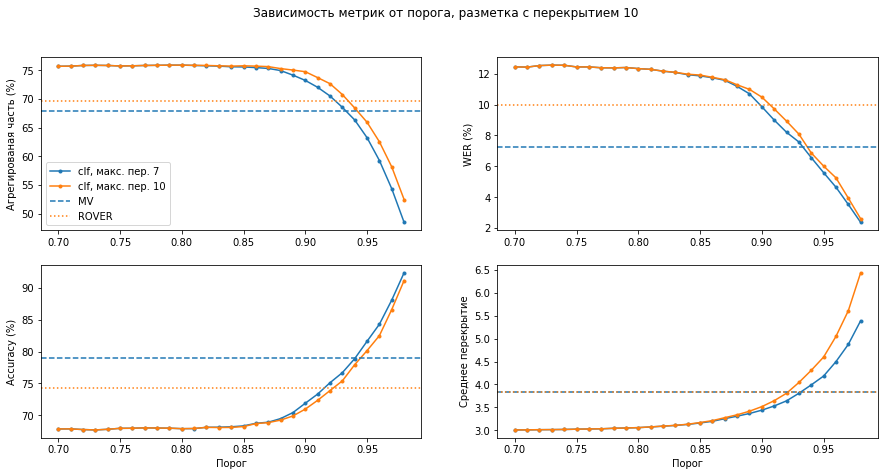

In [165]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разметка с перекрытием 10')
plt.subplot(221)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_clf_new_assistant_true.png")
plt.show()

In [166]:
len(data_assistant_test_valid)

3486

In [167]:
from scipy.stats import norm

In [168]:
def err(value, n, conf=0.95):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [169]:
scores_clf_assistant_new_max_cost_7[:, 1]

array([0.75731497, 0.75760184, 0.75874928, 0.75903614, 0.75874928,
       0.7578887 , 0.75817556, 0.75874928, 0.75903614, 0.75932301,
       0.75932301, 0.75874928, 0.75817556, 0.75760184, 0.75645439,
       0.75616753, 0.75502008, 0.75358577, 0.74985657, 0.74182444,
       0.73264487, 0.72059667, 0.705393  , 0.68559954, 0.66351119,
       0.63253012, 0.59265634, 0.54331612, 0.48450947])

In [170]:
test_words_count = [
    len(row['text'].split()) for row in data_assistant_test_valid
]
test_words_count = sum(test_words_count)

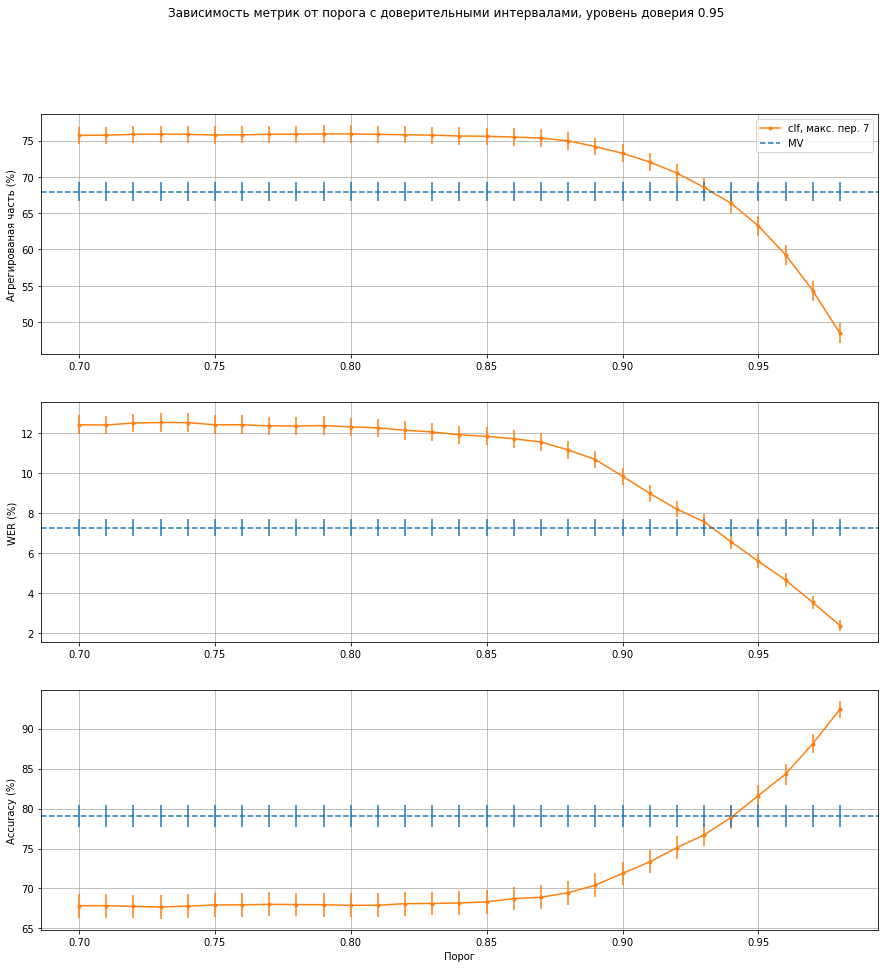

In [171]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(311)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 1] * 100,
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[0] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[0]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[1] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
            [prod_agg_metrics[1]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(data_assistant_test_valid), conf=conf) * 100 for metrics in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[2] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            yerr=[err(val, prod_agg_metrics[0] * len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[2]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_assistant_true.png")
plt.show()

In [172]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.7315%
WER: 12.4355%
Accuracy: 67.8409%
Mean overlap: 3.006
0.71
Aggregated: 75.7602%
WER: 12.4196%
Accuracy: 67.8531%
Mean overlap: 3.008
0.72
Aggregated: 75.8749%
WER: 12.5205%
Accuracy: 67.7505%
Mean overlap: 3.012
0.73
Aggregated: 75.9036%
WER: 12.5474%
Accuracy: 67.6871%
Mean overlap: 3.014
0.74
Aggregated: 75.8749%
WER: 12.5400%
Accuracy: 67.7883%
Mean overlap: 3.017
0.75
Aggregated: 75.7889%
WER: 12.4311%
Accuracy: 67.9410%
Mean overlap: 3.023
0.76
Aggregated: 75.8176%
WER: 12.4330%
Accuracy: 67.9531%
Mean overlap: 3.028
0.77
Aggregated: 75.8749%
WER: 12.3781%
Accuracy: 68.0151%
Mean overlap: 3.031
0.7799999999999999
Aggregated: 75.9036%
WER: 12.3701%
Accuracy: 67.9894%
Mean overlap: 3.042
0.7899999999999999
Aggregated: 75.9323%
WER: 12.3942%
Accuracy: 67.9637%
Mean overlap: 3.049
0.7999999999999999
Aggregated: 75.9323%
WER: 12.3228%
Accuracy: 67.8882%
Mean overlap: 3.057
0.8099999999999999
Aggregated: 75.8749%
WER: 12.2764%
Accuracy: 67.9017%
Mean overlap: 3.0

In [173]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [174]:
scores_clf_assistant_new_max_cost_7[-6:-3, 3] * 100 + [err(metrics[3], metrics[1] * len(data_assistant_test_valid), conf=conf) * 100 for metrics in
            scores_clf_assistant_new_max_cost_7[:]][-6:-3]

array([78.11701796, 80.29727973, 82.98902292])

In [175]:
[err(val, len(data_assistant_test_valid), conf=0.95) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:, 1]][-6:-3]

[1.293422495960713, 1.3163549323763684, 1.3431207060685555]

In [176]:
scores_clf_assistant_new_max_cost_7[-6:-3]

array([[9.30000000e-01, 6.85599541e-01, 7.57600259e-02, 7.66945607e-01,
        3.80636833e+00, 1.23680000e+04, 0.00000000e+00],
       [9.40000000e-01, 6.63511188e-01, 6.56412842e-02, 7.89018591e-01,
        3.98938612e+00, 1.18980000e+04, 0.00000000e+00],
       [9.50000000e-01, 6.32530120e-01, 5.59384942e-02, 8.16326531e-01,
        4.18215720e+00, 1.13160000e+04, 0.00000000e+00]])

In [177]:
err(prod_agg_metrics[2], prod_agg_metrics[0] * len(data_assistant_test_valid), conf=conf) * 100

1.3754722115547573

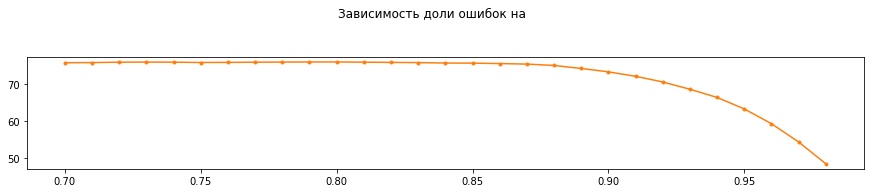

In [178]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость доли ошибок на')
plt.subplot(311)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')

In [179]:
def aggregate_rover_with_clf_and_empty_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [180]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    aggregated_empty = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if hyp == '':
            aggregated_empty += 1
            if row['text'] != '':
                false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if aggregated_empty:
        false_empty /= aggregated_empty
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}\nEmpty error part: {:.4%}".format(
            aggregated_part, wer, accuracy, cost, false_empty
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [181]:
def evaluate_metrics_clf_and_empty_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_and_empty_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [182]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 93.5456%
WER: 9.0667%
Accuracy: 79.7608%
Mean overlap: 3.641
Empty error part: 5.9850%


(0.9354561101549054,
 0.0906672924978487,
 0.797608095676173,
 3.6411359724612735,
 12783,
 0.059850374064837904)

In [183]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.92,
                                    max_cost=7)

Aggregated: 70.5393%
WER: 8.2050%
Accuracy: 75.1118%
Mean overlap: 3.641
Empty error part: 0.0000%


(0.7053930005737234,
 0.082050067124694,
 0.7511183407889386,
 3.6411359724612735,
 12663,
 0.0)

In [184]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.93,
                                    max_cost=7)

Aggregated: 91.1933%
WER: 8.3026%
Accuracy: 81.2520%
Mean overlap: 3.806
Empty error part: 4.9430%


(0.9119334480780263,
 0.08302583025830258,
 0.8125196602705254,
 3.806368330464716,
 12466,
 0.049429657794676805)

In [185]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.93,
                                    max_cost=7)

Aggregated: 68.5600%
WER: 7.5760%
Accuracy: 76.6946%
Mean overlap: 3.806
Empty error part: 0.0000%


(0.6855995410212278,
 0.07576002587322121,
 0.7669456066945607,
 3.806368330464716,
 12368,
 0.0)

In [186]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

Aggregated: 88.4108%
WER: 7.1339%
Accuracy: 83.1927%
Mean overlap: 3.989
Empty error part: 3.9012%


(0.8841078600114745,
 0.07133906941775958,
 0.8319273199221285,
 3.98938611589214,
 11971,
 0.03901170351105332)

In [187]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

Aggregated: 66.3511%
WER: 6.5641%
Accuracy: 78.9019%
Mean overlap: 3.989
Empty error part: 0.0000%


(0.6635111876075731,
 0.06564128424945369,
 0.7890185905750108,
 3.98938611589214,
 11898,
 0.0)

In [188]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.95,
                                    max_cost=7)

Aggregated: 63.2530%
WER: 5.5938%
Accuracy: 81.6327%
Mean overlap: 4.182
Empty error part: 0.0000%


(0.6325301204819277,
 0.05593849416755037,
 0.8163265306122449,
 4.182157200229489,
 11316,
 0.0)

In [189]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.948,
                                    max_cost=7)

Aggregated: 63.7694%
WER: 5.7573%
Accuracy: 81.3315%
Mean overlap: 4.15
Empty error part: 0.0000%


(0.6376936316695353,
 0.05757284101846181,
 0.8133153396311291,
 4.1497418244406195,
 11429,
 0.0)

In [190]:
clf_new.save_model("backup_assistant_2019-09-23_prototype.clf")